In [2]:
%matplotlib inline
import pandas as pd 
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.formula.api import ols
from scipy import stats

In [3]:
data = pd.read_csv("playlists.csv", sep=";", encoding = "ISO-8859-1") 

In [4]:
data.describe(include="all")

company  playlist_sample  \
count           1782      1782.000000   
unique             6              NaN   
top     Arte Francés              NaN   
freq             441              NaN   
mean             NaN         2.084175   
std              NaN         1.114796   
min              NaN         1.000000   
25%              NaN         1.000000   
50%              NaN         2.000000   
75%              NaN         3.000000   
max              NaN         5.000000   

                                               namesfiles           no  \
count                                                1782  1782.000000   
unique                                                515          NaN   
top     21 - Galantis, Uffie - Spaceship (feat. Uffie)...          NaN   
freq                                                    6          NaN   
mean                                                  NaN    17.116162   
std                                                   NaN    11.837401   
min                                                   NaN     1.000000   
25%                                                   NaN     8.000000   
50%                                                   NaN    15.500000   
75%                                                   NaN    24.000000   
max                                                   NaN    65.000000   

                 artist                                               song  \
count              1782                                               1782   
unique              353                                                443   
top      Satin Jackets    Hula Hoop.mp3                                ...   
freq                 51                                                 12   
mean                NaN                                                NaN   
std                 NaN                                                NaN   
min                 NaN                                                NaN   
25%                 NaN                                                NaN   
50%                 NaN                                                NaN   
75%                 NaN                                                NaN   
max                 NaN                                                NaN   

        sampleratefiles  totalsamplesfiles  durationfiles  bitratefiles  \
count            1782.0       1.782000e+03    1782.000000   1782.000000   
unique              NaN                NaN            NaN           NaN   
top                 NaN                NaN            NaN           NaN   
freq                NaN                NaN            NaN           NaN   
mean            44100.0       1.043632e+07     236.651237    252.336700   
std                 0.0       3.227105e+06      73.176981     88.377597   
min             44100.0       5.965054e+06     135.262000    128.000000   
25%             44100.0       8.353151e+06     189.413850    128.000000   
50%             44100.0       9.480378e+06     214.974562    320.000000   
75%             44100.0       1.146931e+07     260.075075    320.000000   
max             44100.0       2.843136e+07     644.702000    320.000000   

             ...         chromagramfiles_5  chromagramfiles_6  \
count        ...               1782.000000        1782.000000   
unique       ...                       NaN                NaN   
top          ...                       NaN                NaN   
freq         ...                       NaN                NaN   
mean         ...                  0.332301           0.319191   
std          ...                  0.270616           0.263919   
min          ...                  0.000000           0.000000   
25%          ...                  0.116591           0.109123   
50%          ...                  0.262799           0.259887   
75%          ...                  0.494897           0.469603   
max          ...                  1.000000           1.000000   

        chro

Find positives and negatives songs of the process for every company.

In [5]:
companies = data['company'].unique()
by_company = [data[data.company == company] for company in companies]
positives = []
negatives = []
for data_com in by_company:
    data_com = data_com.sort_values('playlist_sample')
    last_pl = int(data_com.tail(1).playlist_sample)
    pls = pd.DataFrame({'pl':range (1,last_pl+1), 'old':[0]*last_pl, 'new':[0]*last_pl})
    # pls.new[0]=(data_com.query('playlist_sample == '+str(1)).shape[0])/3
    # for i in range(2,last_pl+1):
      #  curr_pl = data_com.query('playlist_sample == '+str(i))
      #  pre_pl = data_com.query('playlist_sample == '+str(i-1))
      #  olds = curr_pl['song'].map(pre_pl['song'].value_counts()).sum(axis = 0)/3
      #  pls.old[i-1]= olds/3 
      #  pls.new[i-1]=(curr_pl.shape[0]-olds)/3
    # pls[['old','new']].plot(kind='bar', stacked=True, title=data_com.iloc[0,0])
    df_last_pl= data_com.query('playlist_sample == '+str(last_pl))
    positives.append(df_last_pl)
    pos_loc = pd.DataFrame({}, columns=data_com.columns)
    for index, row in data_com[data_com.playlist_sample<last_pl].iterrows(): 
        if not ((df_last_pl['artist'] == row['artist']) & (df_last_pl['song'] ==  row['song'])).any():
            pos_loc= pos_loc.append(row, ignore_index=True)
    # n_vs_p = pd.DataFrame({'sam':['pos', 'neg'],'num':[df_last_pl.shape[0]/3,pos_loc.shape[0]/3]})
    # n_vs_p.plot.bar(x='sam', y='num', rot=0, title=data_com.iloc[0,0])
    negatives.append(pos_loc)

In [6]:
df_n_ps = []
for i in range(len(negatives)):
    negatives[i]['chosen']=0
    positives[i]['chosen']=1
    df_n_ps.append(negatives[i].append(positives[i]))

D:\Usuarios\1144084318\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


## ANOVA

In [7]:
import warnings
import matplotlib.pyplot as plt
import math
import seaborn as sns
warnings.filterwarnings('ignore')

In [ ]:
alpha = 0.05
for df_n_p in df_n_ps:
    df_n_p = df_n_p.fillna(0)
    fig = plt.figure(figsize=(17,200))
    i=1
    for index in range(8,df_n_p.shape[1]-1):
        name= df_n_p.columns.values[index]
        df_n_p[name]=df_n_p[name].astype('float64') 
        mc = MultiComparison(df_n_p[name], df_n_p['chosen'])
        mc_results = mc.tukeyhsd()
        if mc_results._results_table.data[1:][0][5]:
            # print(name)
            results = ols(name+' ~ C(chosen)', data=df_n_p).fit()
            homogeneity_test = stats.levene(df_n_p[name][df_n_p['chosen'] == 0], df_n_p[name][df_n_p['chosen'] == 1])[1]
            normality_test = stats.shapiro(results.resid)[1]
            if homogeneity_test > alpha and normality_test > alpha:
                # print(results.summary())
                ax = fig.add_subplot(math.ceil(df_n_p.shape[1]-9/2), 2, i)
                sns.kdeplot(df_n_p.loc[df_n_p.chosen==0][name], shade=True, ax=ax);
                sns.kdeplot(df_n_p.loc[df_n_p.chosen==1][name], shade=True, ax=ax);
                plt.title(df_n_p.iloc[0,0].upper()+" "+name)
                plt.legend(['neg', 'pos'])
                i+=1

In [8]:
from collections import Counter


from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_samples, silhouette_score, calinski_harabaz_score
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [9]:
for i in range(len(companies)):
    df_n_ps[i].bitratefiles = df_n_ps[i].bitratefiles.astype('float64')
    df_n_ps[i].pitchfiles = df_n_ps[i].pitchfiles.astype('float64')
    df_n_ps[i].bestkeyfiles = df_n_ps[i].bestkeyfiles.astype('float64')
df_n_ps[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 0 to 179
Data columns (total 65 columns):
company                 372 non-null object
playlist_sample         372 non-null object
namesfiles              372 non-null object
no                      372 non-null object
artist                  372 non-null object
song                    372 non-null object
sampleratefiles         372 non-null object
totalsamplesfiles       372 non-null object
durationfiles           372 non-null float64
bitratefiles            372 non-null float64
rmsfiles                372 non-null float64
rmsmedianfiles          372 non-null float64
lowenergyfiles          372 non-null float64
ASRfiles                372 non-null float64
beatspectrumfiles       372 non-null float64
eventdensityfiles       372 non-null float64
tempofiles              372 non-null float64
pulseclarityfiles       372 non-null float64
zerocrossfiles          372 non-null float64
rolloffsfiles           372 non-null float64
bri

Vamos a reemplazar los NaN y entonces a normalizar los datos para que todas las variables tengan la misma importancia. Solo vamos a considerar los datos numéricos.

In [10]:
df_n_ps_std = [0]*len(companies)
for i in range(len(companies)):
    df_n_ps[i] = df_n_ps[i].fillna(0)
    df_n_ps_std[i] = pd.DataFrame(preprocessing.scale(df_n_ps[i].iloc[:,8:]))
    df_n_ps_std[i].columns=df_n_ps[i].columns[8:]
df_n_ps_std[0].mean(axis=0)

durationfiles          -4.261824e-16
bitratefiles            0.000000e+00
rmsfiles                4.303606e-16
rmsmedianfiles         -4.279731e-16
lowenergyfiles         -2.387576e-18
ASRfiles               -2.023471e-16
beatspectrumfiles       2.477111e-16
eventdensityfiles      -7.879002e-17
tempofiles             -3.133694e-17
pulseclarityfiles       3.103849e-17
zerocrossfiles         -2.930750e-16
rolloffsfiles           5.789873e-16
brightnessfiles        -8.356517e-17
spreadfiles            -3.842506e-16
centroidfiles          -2.142850e-16
kurtosisfiles          -6.327077e-17
flatnessfiles           1.366887e-16
entropyfiles            3.516900e-15
mfccfiles_1            -1.921999e-16
mfccfiles_2            -5.372047e-18
mfccfiles_3            -1.178120e-16
mfccfiles_4            -2.648718e-17
mfccfiles_5            -4.655774e-17
mfccfiles_6            -1.193788e-18
mfccfiles_7             6.002516e-17
mfccfiles_8             1.492235e-17
mfccfiles_9             5.133289e-17
m

In [11]:
df_n_ps_std[0].std(axis=0)

durationfiles           1.001347
bitratefiles            0.000000
rmsfiles                1.001347
rmsmedianfiles          1.001347
lowenergyfiles          1.001347
ASRfiles                1.001347
beatspectrumfiles       1.001347
eventdensityfiles       1.001347
tempofiles              1.001347
pulseclarityfiles       1.001347
zerocrossfiles          1.001347
rolloffsfiles           1.001347
brightnessfiles         1.001347
spreadfiles             1.001347
centroidfiles           1.001347
kurtosisfiles           1.001347
flatnessfiles           1.001347
entropyfiles            1.001347
mfccfiles_1             1.001347
mfccfiles_2             1.001347
mfccfiles_3             1.001347
mfccfiles_4             1.001347
mfccfiles_5             1.001347
mfccfiles_6             1.001347
mfccfiles_7             1.001347
mfccfiles_8             1.001347
mfccfiles_9             1.001347
mfccfiles_10            1.001347
mfccfiles_11            1.001347
mfccfiles_12            1.001347
mfccfiles_

Borramos pitch y bitrate porque todos sus valores son 0.

In [12]:
for i in range(len(companies)):
    df_n_ps_std[i] = df_n_ps_std[i].drop(columns="pitchfiles")
    df_n_ps_std[i] = df_n_ps_std[i].drop(columns="bitratefiles")

In [16]:
df_n_ps_std[0].columns

Index(['durationfiles', 'rmsfiles', 'rmsmedianfiles', 'lowenergyfiles',
       'ASRfiles', 'beatspectrumfiles', 'eventdensityfiles', 'tempofiles',
       'pulseclarityfiles', 'zerocrossfiles', 'rolloffsfiles',
       'brightnessfiles', 'spreadfiles', 'centroidfiles', 'kurtosisfiles',
       'flatnessfiles', 'entropyfiles', 'mfccfiles_1', 'mfccfiles_2',
       'mfccfiles_3', 'mfccfiles_4', 'mfccfiles_5', 'mfccfiles_6',
       'mfccfiles_7', 'mfccfiles_8', 'mfccfiles_9', 'mfccfiles_10',
       'mfccfiles_11', 'mfccfiles_12', 'mfccfiles_13', 'inharmonicityfiles',
       'bestkeyfiles', 'keyclarityfiles', 'modalityfiles',
       'tonalcentroidfiles_1', 'tonalcentroidfiles_2', 'tonalcentroidfiles_3',
       'tonalcentroidfiles_4', 'tonalcentroidfiles_5', 'tonalcentroidfiles_6',
       'chromagramfiles_1', 'chromagramfiles_2', 'chromagramfiles_3',
       'chromagramfiles_4', 'chromagramfiles_5', 'chromagramfiles_6',
       'chromagramfiles_7', 'chromagramfiles_8', 'chromagramfiles_9',
      

# MFCC

In [175]:
df_n_ps_std[0].columns[17:30]

Index(['mfccfiles_1', 'mfccfiles_2', 'mfccfiles_3', 'mfccfiles_4',
       'mfccfiles_5', 'mfccfiles_6', 'mfccfiles_7', 'mfccfiles_8',
       'mfccfiles_9', 'mfccfiles_10', 'mfccfiles_11', 'mfccfiles_12',
       'mfccfiles_13'],
      dtype='object')

In [176]:
df_n_ps_std_mfcc = [None]*len(companies)
for i in range(len(companies)):
    df_n_ps_std_mfcc[i] = pd.DataFrame(df_n_ps_std[i].iloc[:,17:30])
    df_n_ps_std_mfcc[i].columns=df_n_ps_std[i].columns[17:30]
df_n_ps_std_mfcc[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 13 columns):
mfccfiles_1     372 non-null float64
mfccfiles_2     372 non-null float64
mfccfiles_3     372 non-null float64
mfccfiles_4     372 non-null float64
mfccfiles_5     372 non-null float64
mfccfiles_6     372 non-null float64
mfccfiles_7     372 non-null float64
mfccfiles_8     372 non-null float64
mfccfiles_9     372 non-null float64
mfccfiles_10    372 non-null float64
mfccfiles_11    372 non-null float64
mfccfiles_12    372 non-null float64
mfccfiles_13    372 non-null float64
dtypes: float64(13)
memory usage: 37.9 KB


## Arte Francés

### ANN

In [13]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.0'

In [14]:
from keras.layers import Input, Flatten, Dense#, Lambda
from keras.models import Model
from keras import layers
from keras import models, optimizers

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV #permite buscar la mejor configuración de parámetros con C-V
from sklearn.metrics import make_scorer # permite crear una clase scorer a partir de una función de score (necesario para el kappa)
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.preprocessing import StandardScaler

In [177]:
X = df_n_ps_std_mfcc[0]

In [178]:
y = df_n_ps[0]['chosen']

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [180]:
X_train.shape

(279, 13)

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [25]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [26]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [27]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.006, 'max_iter': 300}, que permiten obtener un Accuracy de 82.08% y un Kappa del 43.49
Tiempo total: 29.12 minutos


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [181]:
grid.best_params_['hidden_layer_sizes']=[20]
n0=X_train.shape[1]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.006
epochs = 300

In [182]:
input_tensor = Input(shape = (n0,))

In [183]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [184]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [185]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 21        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


In [186]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 279 samples, validate on 93 samples
Epoch 1/300
279/279 [==============================] - 0s 641us/step - loss: 0.7161 - accuracy: 0.5556 - val_loss: 0.6348 - val_accuracy: 0.6667
Epoch 2/300
279/279 [==============================] - 0s 47us/step - loss: 0.5940 - accuracy: 0.7025 - val_loss: 0.6026 - val_accuracy: 0.6989
Epoch 3/300
279/279 [==============================] - 0s 47us/step - loss: 0.5317 - accuracy: 0.7599 - val_loss: 0.5880 - val_accuracy: 0.7097
Epoch 4/300
279/279 [==============================] - 0s 47us/step - loss: 0.4879 - accuracy: 0.7849 - val_loss: 0.5798 - val_accuracy: 0.7097
Epoch 5/300
279/279 [==============================] - 0s 50us/step - loss: 0.4620 - accuracy: 0.7957 - val_loss: 0.5636 - val_accuracy: 0.7312
Epoch 6/300
279/279 [==============================] - 0s 50us/step - loss: 0.4473 - accuracy: 0.7993 - val_loss: 0.5569 - val_accuracy: 0.7204
Epoch 7/300
279/279 [==============================] - 0s 79us/step - loss: 0.4387 - accur

279/279 [==============================] - 0s 54us/step - loss: 0.2941 - accuracy: 0.8674 - val_loss: 0.5889 - val_accuracy: 0.7097

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.000375000003259629.
Epoch 56/300
279/279 [==============================] - 0s 54us/step - loss: 0.2933 - accuracy: 0.8710 - val_loss: 0.5887 - val_accuracy: 0.7097
Epoch 57/300
279/279 [==============================] - 0s 75us/step - loss: 0.2931 - accuracy: 0.8746 - val_loss: 0.5885 - val_accuracy: 0.7097
Epoch 58/300
279/279 [==============================] - 0s 64us/step - loss: 0.2927 - accuracy: 0.8746 - val_loss: 0.5887 - val_accuracy: 0.7097
Epoch 59/300
279/279 [==============================] - 0s 61us/step - loss: 0.2923 - accuracy: 0.8781 - val_loss: 0.5899 - val_accuracy: 0.7097
Epoch 60/300
279/279 [==============================] - 0s 54us/step - loss: 0.2919 - accuracy: 0.8781 - val_loss: 0.5899 - val_accuracy: 0.7097
Epoch 61/300
279/279 [==============================] - 0s 57us

279/279 [==============================] - 0s 47us/step - loss: 0.2867 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 109/300
279/279 [==============================] - 0s 54us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 110/300
279/279 [==============================] - 0s 50us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 111/300
279/279 [==============================] - 0s 50us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 112/300
279/279 [==============================] - 0s 75us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 113/300
279/279 [==============================] - 0s 57us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy: 0.7097
Epoch 114/300
279/279 [==============================] - 0s 57us/step - loss: 0.2866 - accuracy: 0.8817 - val_loss: 0.5912 - val_accuracy:

279/279 [==============================] - 0s 57us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 162/300
279/279 [==============================] - 0s 82us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 163/300
279/279 [==============================] - 0s 57us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 164/300
279/279 [==============================] - 0s 57us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 165/300
279/279 [==============================] - 0s 54us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097

Epoch 00165: ReduceLROnPlateau reducing learning rate to 1.8310547034161573e-07.
Epoch 166/300
279/279 [==============================] - 0s 54us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 167/300
279/279 [==============================] -

279/279 [==============================] - 0s 50us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 215/300
279/279 [==============================] - 0s 61us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097

Epoch 00215: ReduceLROnPlateau reducing learning rate to 5.7220459481754915e-09.
Epoch 216/300
279/279 [==============================] - 0s 57us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 217/300
279/279 [==============================] - 0s 54us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 218/300
279/279 [==============================] - 0s 50us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 219/300
279/279 [==============================] - 0s 54us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 220/300
279/279 [==============================] -

Epoch 267/300
279/279 [==============================] - 0s 72us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 268/300
279/279 [==============================] - 0s 54us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 269/300
279/279 [==============================] - 0s 50us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 270/300
279/279 [==============================] - 0s 50us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 271/300
279/279 [==============================] - 0s 61us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 272/300
279/279 [==============================] - 0s 47us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 - val_accuracy: 0.7097
Epoch 273/300
279/279 [==============================] - 0s 50us/step - loss: 0.2865 - accuracy: 0.8817 - val_loss: 0.5913 -

range(0, 300)


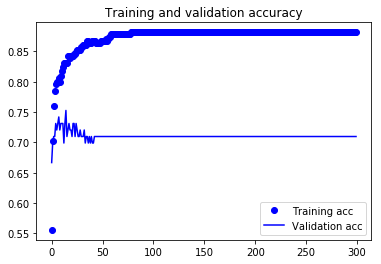

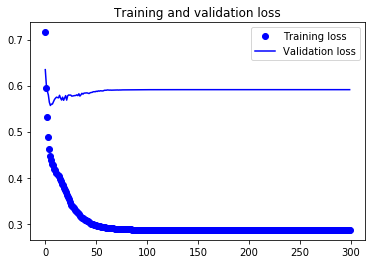

In [187]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [188]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

93/93 [==============================] - 0s 43us/step
test loss: 0.5912757192247657, test accuracy: 0.7096773982048035


In [190]:
y_pred = model.predict(X_test)
y_pred_d = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred_d))
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

Kappa:  0.17860647693817455
AUC ROC:  0.6812570145903478


### KMeans

In [191]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.303210     1.253016    -0.394054     0.592598     0.106623   
1       0.647559    -1.553511    -1.648243    -1.010792    -0.857927   
2       2.266625    -0.333664     0.685765    -2.001143    -0.820018   
3       0.672266    -0.397422     0.105106    -1.822060    -1.335294   
4       0.747622     0.110331    -0.079109    -1.108698    -0.391749   
5       2.072441    -1.565884    -0.268750    -1.648648    -3.149219   
6      -0.163654     0.470736     0.440011     0.594090    -1.227236   
7       0.477732    -0.217651    -0.908178    -1.257961    -1.360625   
8       0.897786    -3.040013     0.311694    -0.386220    -0.321124   
9      -0.977087     1.088438    -0.184899    -0.626934     0.577247   
10      0.328615    -1.292300    -1.398337    -0.677268    -1.070980   
11     -0.199470     0.110219     0.238637     0.455154    -0.116209   
12     -0.711256     0.124802     0.734425    -0.445078    -0.503247   
13     -0.806898    -0.126740    -0.383726     0.035489    -1.164460   
14     -0.077242    -0.331495     0.550493    -0.008575    -0.215759   
15      0.244538     0.777957     0.464181     0.169574    -0.433604   
16      0.602329    -0.035069     0.178352    -0.036690     0.180302   
17     -0.570258    -0.759570     0.108993     0.657477     0.342355   
18     -0.288268    -1.202534    -0.544058     0.295908     0.568680   
19     -0.497305    -0.552590     0.332470     0.660607     0.293725   
20      1.386141    -0.516432    -0.074640     0.751101    -1.151864   
21      0.076772     0.072900     0.122544     0.799017    -1.121011   
22      0.670757    -0.167252    -0.352765     0.189499    -1.232602   
23      0.639283     0.699164     0.621380    -0.725771    -0.890352   
24     -0.907399     2.155157     0.873522     1.655111     0.871099   
25     -1.152272     1.601470     0.221927     1.296592     0.572807   
26     -0.676596     0.405600     0.553370     0.691531    -0.292469   
27     -0.704834    -0.058170     0.609171    -0.735340    -0.512747   
28      0.273095     1.014503    -0.772750    -0.065028    -0.513485   
29      1.216372     0.637021     0.649194     0.099873    -0.816614   
..           ...          ...          ...          ...          ...   
342     0.056741     0.169776     0.434163    -0.208821     0.498957   
343    -0.845812    -0.163165     0.268174     1.312135     1.241686   
344     0.056854     0.089458    -0.128149     0.123107    -0.879175   
345     1.322735    -0.970372    -1.058427     1.018282    -1.228871   
346    -0.159679    -0.200313    -0.181878     0.221536    -0.604018   
347    -0.510690    -0.141874    -0.170690    -0.486309    -1.066447   
348     0.441393     0.403987     0.538948     1.253198    -0.158511   
349     0.548477     0.987769     0.505748     0.779668     0.504327   
350     0.278851    -0.150632     1.015313     0.158731    -1.435466   
351     1.781784    -0.680962    -0.140043     1.730156     0.760657   
352     1.110023    -0.419764    -0.451242     1.471440     0.860531   
353     0.463780     0.094111     0.074193     0.457058    -0.494585   
354     0.162857     1.300630    -0.374191    -0.148478    -0.275205   
355    -0.261040     1.897992     0.324175     0.250461    -0.326921   
356    -2.412627    -0.912657     0.924859     1.091412    -0.430459   
357    -1.610420    -0.171488     1.308910     1.557149    -0.783120   
358    -1.627642    -0.225022     1.420291     1.585386    -0.623077   
359     1.658650     0.261694     0.694273    -0.634006    -0.742717   
360    -0.472450     1.290735     1.251486     0.902820     1.064267   
361     0.145973     1.078298    -0.110458     0.396705     0.465683   
362     1.354053     0.408020    -1.449365    -0.144038     0.735070   
363     3.546326    -0.337767    -0.983896    -3.155084     1.922015   
364     3.564797    -0.492960    -0.663172    -2.465245     2.044991   
365    -0.480041     0.390140     0.283493   

In [60]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[4836.0,
 4367.616182778379,
 3974.0733975762073,
 3720.4477504020774,
 3549.9823424876267,
 3386.093163495573,
 3254.3815559758523,
 3136.90996141146,
 3048.6934734702136,
 2957.186911982338,
 2855.333306370868,
 2802.0220333671496,
 2712.5965714921504,
 2657.189981994876]

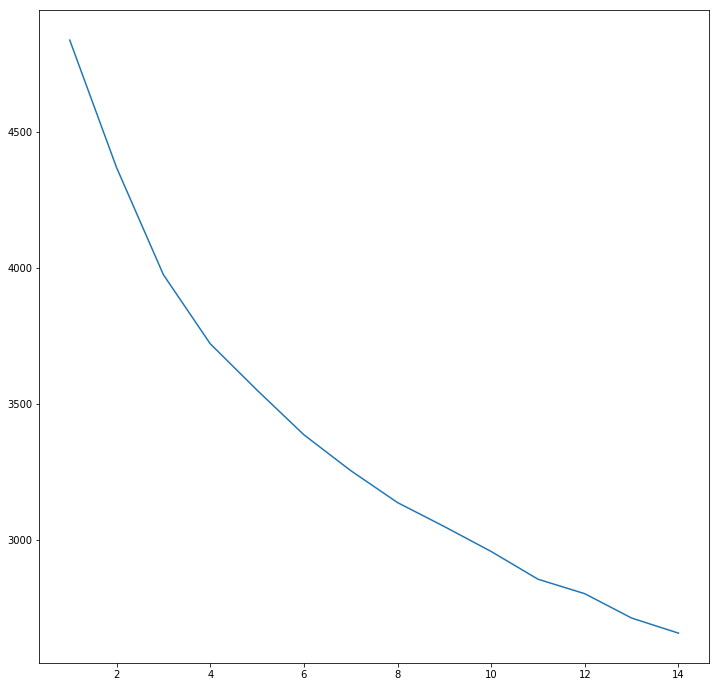

In [89]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [81]:
kmeans_mfcc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [82]:
kmeans_mfcc.labels_

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [83]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [84]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [85]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.303210     1.253016    -0.394054     0.592598     0.106623   
1       0.647559    -1.553511    -1.648243    -1.010792    -0.857927   
2       2.266625    -0.333664     0.685765    -2.001143    -0.820018   
3       0.672266    -0.397422     0.105106    -1.822060    -1.335294   
4       0.747622     0.110331    -0.079109    -1.108698    -0.391749   
5       2.072441    -1.565884    -0.268750    -1.648648    -3.149219   
6      -0.163654     0.470736     0.440011     0.594090    -1.227236   
7       0.477732    -0.217651    -0.908178    -1.257961    -1.360625   
8       0.897786    -3.040013     0.311694    -0.386220    -0.321124   
9      -0.977087     1.088438    -0.184899    -0.626934     0.577247   
10      0.328615    -1.292300    -1.398337    -0.677268    -1.070980   
11     -0.199470     0.110219     0.238637     0.455154    -0.116209   
12     -0.711256     0.124802     0.734425    -0.445078    -0.503247   
13     -0.806898    -0.126740    -0.383726     0.035489    -1.164460   
14     -0.077242    -0.331495     0.550493    -0.008575    -0.215759   
15      0.244538     0.777957     0.464181     0.169574    -0.433604   
16      0.602329    -0.035069     0.178352    -0.036690     0.180302   
17     -0.570258    -0.759570     0.108993     0.657477     0.342355   
18     -0.288268    -1.202534    -0.544058     0.295908     0.568680   
19     -0.497305    -0.552590     0.332470     0.660607     0.293725   
20      1.386141    -0.516432    -0.074640     0.751101    -1.151864   
21      0.076772     0.072900     0.122544     0.799017    -1.121011   
22      0.670757    -0.167252    -0.352765     0.189499    -1.232602   
23      0.639283     0.699164     0.621380    -0.725771    -0.890352   
24     -0.907399     2.155157     0.873522     1.655111     0.871099   
25     -1.152272     1.601470     0.221927     1.296592     0.572807   
26     -0.676596     0.405600     0.553370     0.691531    -0.292469   
27     -0.704834    -0.058170     0.609171    -0.735340    -0.512747   
28      0.273095     1.014503    -0.772750    -0.065028    -0.513485   
29      1.216372     0.637021     0.649194     0.099873    -0.816614   
..           ...          ...          ...          ...          ...   
342     0.056741     0.169776     0.434163    -0.208821     0.498957   
343    -0.845812    -0.163165     0.268174     1.312135     1.241686   
344     0.056854     0.089458    -0.128149     0.123107    -0.879175   
345     1.322735    -0.970372    -1.058427     1.018282    -1.228871   
346    -0.159679    -0.200313    -0.181878     0.221536    -0.604018   
347    -0.510690    -0.141874    -0.170690    -0.486309    -1.066447   
348     0.441393     0.403987     0.538948     1.253198    -0.158511   
349     0.548477     0.987769     0.505748     0.779668     0.504327   
350     0.278851    -0.150632     1.015313     0.158731    -1.435466   
351     1.781784    -0.680962    -0.140043     1.730156     0.760657   
352     1.110023    -0.419764    -0.451242     1.471440     0.860531   
353     0.463780     0.094111     0.074193     0.457058    -0.494585   
354     0.162857     1.300630    -0.374191    -0.148478    -0.275205   
355    -0.261040     1.897992     0.324175     0.250461    -0.326921   
356    -2.412627    -0.912657     0.924859     1.091412    -0.430459   
357    -1.610420    -0.171488     1.308910     1.557149    -0.783120   
358    -1.627642    -0.225022     1.420291     1.585386    -0.623077   
359     1.658650     0.261694     0.694273    -0.634006    -0.742717   
360    -0.472450     1.290735     1.251486     0.902820     1.064267   
361     0.145973     1.078298    -0.110458     0.396705     0.465683   
362     1.354053     0.408020    -1.449365    -0.144038     0.735070   
363     3.546326    -0.337767    -0.983896    -3.155084     1.922015   
364     3.564797    -0.492960    -0.663172    -2.465245     2.044991   
365    -0.480041     0.390140     0.283493   

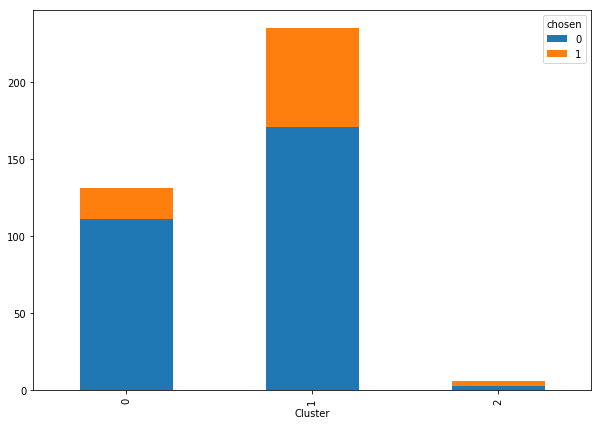

In [86]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [16]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[1]))

## Club De Banqueros y Empresarios

### ANN

In [193]:
X = df_n_ps_std_mfcc[1]

In [194]:
y = df_n_ps[1]['chosen']

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [196]:
X_train.shape

(191, 13)

In [47]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [48]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [49]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [50]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.01, 'max_iter': 2000}, que permiten obtener un Accuracy de 81.68% y un Kappa del 52.97
Tiempo total: 25.07 minutos


In [197]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,20,20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.01
epochs = 2000

In [198]:
input_tensor = Input(shape = (n0,))

In [199]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [200]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [201]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [202]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size= 32,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 191 samples, validate on 64 samples
Epoch 1/2000
191/191 [==============================] - 0s 1ms/step - loss: 0.6261 - accuracy: 0.6387 - val_loss: 0.5919 - val_accuracy: 0.7031
Epoch 2/2000
191/191 [==============================] - 0s 63us/step - loss: 0.4675 - accuracy: 0.7487 - val_loss: 0.5618 - val_accuracy: 0.7188
Epoch 3/2000
191/191 [==============================] - 0s 68us/step - loss: 0.4415 - accuracy: 0.7906 - val_loss: 0.6494 - val_accuracy: 0.7500
Epoch 4/2000
191/191 [==============================] - 0s 68us/step - loss: 0.3992 - accuracy: 0.8220 - val_loss: 0.6424 - val_accuracy: 0.7188
Epoch 5/2000
191/191 [==============================] - 0s 68us/step - loss: 0.3713 - accuracy: 0.8429 - val_loss: 0.6325 - val_accuracy: 0.7344
Epoch 6/2000
191/191 [==============================] - 0s 63us/step - loss: 0.3457 - accuracy: 0.8586 - val_loss: 0.6120 - val_accuracy: 0.7188
Epoch 7/2000
191/191 [==============================] - 0s 58us/step - loss: 0.3136 - 

191/191 [==============================] - 0s 63us/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 1.2960 - val_accuracy: 0.7344
Epoch 55/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 1.2973 - val_accuracy: 0.7344
Epoch 56/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.2994 - val_accuracy: 0.7344
Epoch 57/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.3012 - val_accuracy: 0.7344
Epoch 58/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.3040 - val_accuracy: 0.7344

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 59/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.3054 - val_accuracy: 0.7344
Epoch 60/2000
191/191 [==============================] - 

191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3272 - val_accuracy: 0.7344
Epoch 108/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3273 - val_accuracy: 0.7344

Epoch 00108: ReduceLROnPlateau reducing learning rate to 9.765624781721272e-06.
Epoch 109/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3273 - val_accuracy: 0.7344
Epoch 110/2000
191/191 [==============================] - 0s 131us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.7344
Epoch 111/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.7344
Epoch 112/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3274 - val_accuracy: 0.7344
Epoch 113/2000
191/191 [===========================

191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 160/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 161/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 162/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 163/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 164/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 165/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

Epoch 212/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 213/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 214/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 215/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 216/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 217/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 218/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1

191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 266/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 267/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 268/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00268: ReduceLROnPlateau reducing learning rate to 1.490116086078075e-10.
Epoch 269/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 270/2000
191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 271/2000
191/191 [===========================

Epoch 318/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00318: ReduceLROnPlateau reducing learning rate to 4.656612768993984e-12.
Epoch 319/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 320/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 321/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 322/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 323/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 324/2000
191/191 [=============

191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 371/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 372/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 373/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 374/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 375/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 376/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 424/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 425/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 426/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 427/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 428/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00428: ReduceLROnPlateau reducing learning rate to 2.2737367036103438e-15.
Epoch 429/2000
191/191 [===========================

191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 477/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 478/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00478: ReduceLROnPlateau reducing learning rate to 7.105427198782324e-17.
Epoch 479/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 480/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 481/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 482/2000
191/191 [============================

191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 530/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 531/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 532/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 533/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 534/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 535/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 583/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 584/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 585/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 586/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 587/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 588/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 636/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 637/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 638/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00638: ReduceLROnPlateau reducing learning rate to 1.0842021482516974e-21.
Epoch 639/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 640/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 641/2000
191/191 [===========================

191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00688: ReduceLROnPlateau reducing learning rate to 3.3881317132865545e-23.
Epoch 689/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 690/2000
191/191 [==============================] - 0s 73us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 691/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 692/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 693/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 694/2000
191/191 [===========================

191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 741/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 742/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 743/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 744/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 745/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 746/2000
191/191 [==============================] - 0s 63us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 794/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 795/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 796/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 797/2000
191/191 [==============================] - 0s 68us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 798/2000
191/191 [==============================] - 0s 58us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00798: ReduceLROnPlateau reducing learning rate to 1.6543611881282004e-26.
Epoch 799/2000
191/191 [===========================

Epoch 846/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 847/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 848/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 00848: ReduceLROnPlateau reducing learning rate to 5.169878712900626e-28.
Epoch 849/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 850/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 851/2000
191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 852/2000
191/191 [============


Epoch 00898: ReduceLROnPlateau reducing learning rate to 1.6155870977814457e-29.
Epoch 899/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 900/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 901/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 902/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 903/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 904/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 905/2000
191/191 [===========

191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 952/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 953/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 954/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 955/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 956/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 957/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_acc

Epoch 1004/2000
191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1005/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1006/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1007/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1008/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 01008: ReduceLROnPlateau reducing learning rate to 7.888608875885965e-33.
Epoch 1009/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1010/2000
191/191 [====

191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1057/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1058/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 01058: ReduceLROnPlateau reducing learning rate to 2.465190273714364e-34.
Epoch 1059/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1060/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1061/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1062/2000
191/191 [======================


Epoch 01108: ReduceLROnPlateau reducing learning rate to 7.703719605357388e-36.
Epoch 1109/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1110/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1111/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1112/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1113/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1114/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1115/2000
191/191 [====

191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1162/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1163/2000
191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1164/2000
191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1165/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1166/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1167/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 

191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1214/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1215/2000
191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1216/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1217/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1218/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 01218: ReduceLROnPlateau reducing learning rate to 3.761581838553412e-39.
Epoch 1219/2000
191/191 [==================

Epoch 1265/2000
191/191 [==============================] - 0s 126us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1266/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1267/2000
191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1268/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 01268: ReduceLROnPlateau reducing learning rate to 1.175493229783516e-40.
Epoch 1269/2000
191/191 [==============================] - 0s 120us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1270/2000
191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1271/2000
191/191 [=

191/191 [==============================] - 0s 115us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1318/2000
191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344

Epoch 01318: ReduceLROnPlateau reducing learning rate to 3.673503924227508e-42.
Epoch 1319/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1320/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1321/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1322/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1323/2000
191/191 [=================

191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1370/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1371/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1372/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1373/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1374/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1375/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - 

191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1422/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1423/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1424/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1425/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1426/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1427/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1476/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1477/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1478/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1479/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1480/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1481/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1531/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1532/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1533/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1534/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1535/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1536/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1586/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1587/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1588/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1589/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1590/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1591/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1641/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1642/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1643/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1644/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1645/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1646/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1696/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1697/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1698/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1699/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1700/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1701/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - 

191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1751/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1752/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1753/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1754/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1755/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1756/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1806/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1807/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1808/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1809/2000
191/191 [==============================] - 0s 199us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1810/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1811/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 -

191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1861/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1862/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1863/2000
191/191 [==============================] - 0s 78us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1864/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1865/2000
191/191 [==============================] - 0s 89us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1866/2000
191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - 

191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1916/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1917/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1918/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1919/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1920/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1921/2000
191/191 [==============================] - 0s 84us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - v

191/191 [==============================] - 0s 110us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1971/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1972/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1973/2000
191/191 [==============================] - 0s 99us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1974/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1975/2000
191/191 [==============================] - 0s 94us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282 - val_accuracy: 0.7344
Epoch 1976/2000
191/191 [==============================] - 0s 105us/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.3282

range(0, 2000)


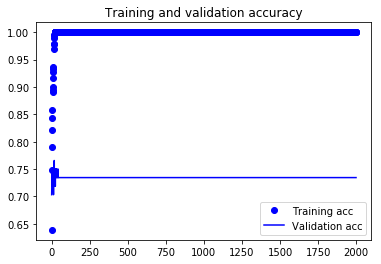

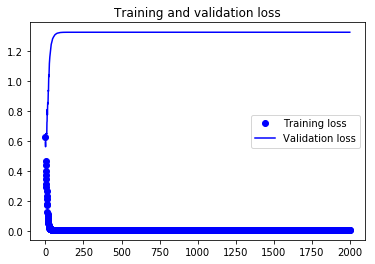

In [203]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [204]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

64/64 [==============================] - 0s 47us/step
test loss: 1.3282248377799988, test accuracy: 0.734375


In [205]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.8006362672322375


In [206]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.39420935412026725


### KMeans

In [66]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

In [67]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3315.0,
 2972.7888695817974,
 2748.18187155972,
 2544.9420084212106,
 2413.687059384553,
 2278.037996783226,
 2213.3487507256823,
 2123.4282707474663,
 2067.8299633414163,
 1977.777252698108,
 1956.5229777214513,
 1880.0296166971755,
 1815.5096049846275,
 1785.9955747862728]

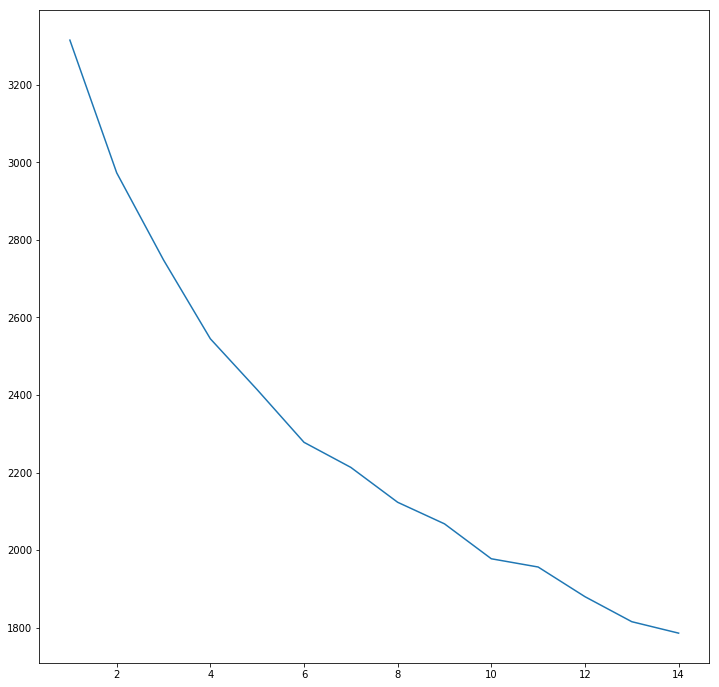

In [68]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=6

In [69]:
kmeans_mfcc = KMeans(n_clusters=6, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [70]:
kmeans_mfcc.labels_

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [71]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [72]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [73]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

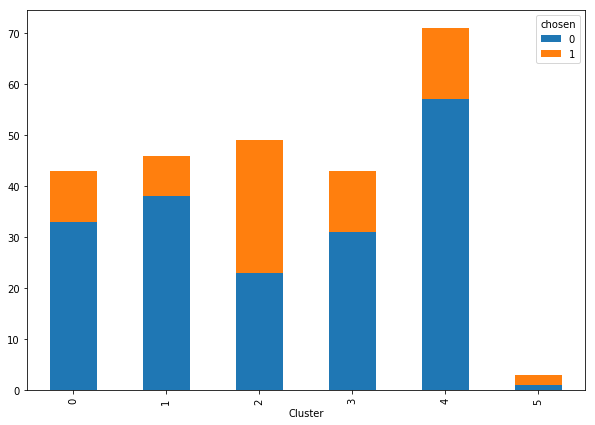

In [74]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [207]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[2]))

## Gramma

### ANN

In [208]:
X = df_n_ps_std_mfcc[2]

In [209]:
y = df_n_ps[2]['chosen']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [211]:
X_train.shape

(231, 13)

In [80]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [81]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [82]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [83]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001, 'max_iter': 1000}, que permiten obtener un Accuracy de 84.42% y un Kappa del 45.84
Tiempo total: 27.81 minutos


In [212]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.001
epochs = 1000

In [213]:
input_tensor = Input(shape = (n0,))

In [214]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [215]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [216]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 13)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 30)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 31        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [217]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size= 32,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 231 samples, validate on 78 samples
Epoch 1/1000
231/231 [==============================] - 0s 653us/step - loss: 0.6856 - accuracy: 0.5628 - val_loss: 0.6899 - val_accuracy: 0.5769
Epoch 2/1000
231/231 [==============================] - 0s 52us/step - loss: 0.6619 - accuracy: 0.6147 - val_loss: 0.6783 - val_accuracy: 0.6154
Epoch 3/1000
231/231 [==============================] - 0s 52us/step - loss: 0.6436 - accuracy: 0.6623 - val_loss: 0.6683 - val_accuracy: 0.6026
Epoch 4/1000
231/231 [==============================] - 0s 82us/step - loss: 0.6261 - accuracy: 0.6840 - val_loss: 0.6598 - val_accuracy: 0.6154
Epoch 5/1000
231/231 [==============================] - 0s 56us/step - loss: 0.6105 - accuracy: 0.7273 - val_loss: 0.6508 - val_accuracy: 0.6282
Epoch 6/1000
231/231 [==============================] - 0s 56us/step - loss: 0.5965 - accuracy: 0.7489 - val_loss: 0.6424 - val_accuracy: 0.6154
Epoch 7/1000
231/231 [==============================] - 0s 56us/step - loss: 0.5832 

231/231 [==============================] - 0s 65us/step - loss: 0.3750 - accuracy: 0.8571 - val_loss: 0.5673 - val_accuracy: 0.6923
Epoch 56/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3747 - accuracy: 0.8571 - val_loss: 0.5673 - val_accuracy: 0.6923
Epoch 57/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3745 - accuracy: 0.8571 - val_loss: 0.5674 - val_accuracy: 0.6923
Epoch 58/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3742 - accuracy: 0.8528 - val_loss: 0.5674 - val_accuracy: 0.6923
Epoch 59/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3740 - accuracy: 0.8571 - val_loss: 0.5677 - val_accuracy: 0.6923
Epoch 60/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3736 - accuracy: 0.8528 - val_loss: 0.5680 - val_accuracy: 0.6923
Epoch 61/1000
231/231 [==============================] - 0s 74us/step - loss: 0.3734 - accuracy: 0.8571 - val_loss: 0.5679 - val_accuracy:

231/231 [==============================] - 0s 69us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923
Epoch 109/1000
231/231 [==============================] - 0s 74us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923
Epoch 110/1000
231/231 [==============================] - 0s 78us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923
Epoch 111/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923

Epoch 00111: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 112/1000
231/231 [==============================] - 0s 69us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923
Epoch 113/1000
231/231 [==============================] - 0s 78us/step - loss: 0.3707 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.6923
Epoch 114/1000
231/231 [===========================

Epoch 161/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00161: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
Epoch 162/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 163/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 164/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 165/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 166/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 167/1000
231/231 [=============

231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 214/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 215/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 216/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 217/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 218/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 219/1000
231/231 [==============================] - 0s 74us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_acc

231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 267/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 268/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 269/1000
231/231 [==============================] - 0s 82us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 270/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 271/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00271: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
Epoch 272/1000
231/231 [============================

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 320/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 321/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00321: ReduceLROnPlateau reducing learning rate to 9.313226188509272e-13.
Epoch 322/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 323/1000
231/231 [==============================] - 0s 69us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 324/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 325/1000
231/231 [============================

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 373/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 374/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 375/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 376/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 377/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 378/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_acc

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 426/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 427/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 428/1000
231/231 [==============================] - 0s 74us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 429/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 430/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 431/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_acc

231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 479/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 480/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 481/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00481: ReduceLROnPlateau reducing learning rate to 1.4210855390181384e-17.
Epoch 482/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 483/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 484/1000
231/231 [===========================

231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00531: ReduceLROnPlateau reducing learning rate to 4.440892309431682e-19.
Epoch 532/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 533/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 534/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 535/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 536/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 537/1000
231/231 [============================

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 584/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 585/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 586/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 587/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 588/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 589/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_acc

Epoch 636/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 637/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 638/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 639/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 640/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 641/1000
231/231 [==============================] - 0s 78us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00641: ReduceLROnPlateau reducing learning rate to 2.1684044479646887e-22.
Epoch 642/1000
231/231 [============

Epoch 689/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 690/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 691/1000
231/231 [==============================] - 0s 78us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00691: ReduceLROnPlateau reducing learning rate to 6.776263899889652e-24.
Epoch 692/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 693/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 694/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 695/1000
231/231 [=============


Epoch 00741: ReduceLROnPlateau reducing learning rate to 2.1175824687155163e-25.
Epoch 742/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 743/1000
231/231 [==============================] - 0s 74us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 744/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 745/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 746/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 747/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 748/1000
231/231 [============

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 795/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 796/1000
231/231 [==============================] - 0s 78us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 797/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 798/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 799/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 800/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_acc

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 848/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 849/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 850/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 851/1000
231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00851: ReduceLROnPlateau reducing learning rate to 1.0339758148024982e-28.
Epoch 852/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 853/1000
231/231 [===========================

231/231 [==============================] - 0s 56us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 901/1000
231/231 [==============================] - 0s 52us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923

Epoch 00901: ReduceLROnPlateau reducing learning rate to 3.231174421257807e-30.
Epoch 902/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 903/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 904/1000
231/231 [==============================] - 0s 65us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 905/1000
231/231 [==============================] - 0s 61us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 906/1000
231/231 [============================

231/231 [==============================] - 0s 100us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 953/1000
231/231 [==============================] - 0s 108us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 954/1000
231/231 [==============================] - 0s 91us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 955/1000
231/231 [==============================] - 0s 91us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 956/1000
231/231 [==============================] - 0s 100us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 957/1000
231/231 [==============================] - 0s 91us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val_accuracy: 0.6923
Epoch 958/1000
231/231 [==============================] - 0s 104us/step - loss: 0.3706 - accuracy: 0.8571 - val_loss: 0.5696 - val

range(0, 1000)


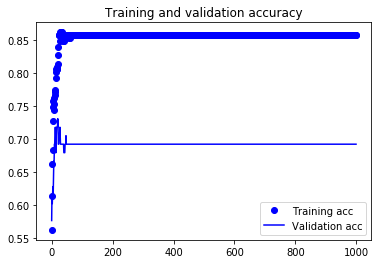

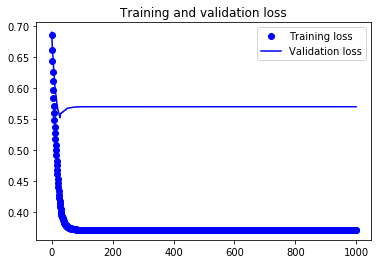

In [218]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [219]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

78/78 [==============================] - 0s 51us/step
test loss: 0.5695895949999491, test accuracy: 0.692307710647583


In [220]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.6775271512113618


In [221]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.009523809523809601


### KMeans

In [93]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.784459     0.109342     0.681608     1.151904    -0.707724   
1       0.213444     0.453851     0.215705     0.987439    -1.851748   
2       1.478029     0.664210     0.484232     0.450284    -0.427587   
3      -0.846386    -0.742706    -0.734786    -0.199585    -0.328948   
4      -0.952033    -0.794706    -1.141199    -0.070979     0.454453   
5      -1.244473     2.250723     2.321007     0.549219     1.971653   
6      -0.128652     0.958605     1.191477     0.705974     0.793937   
7      -1.148662     0.562286     0.636059     0.222732     0.741470   
8      -0.440190     0.461355    -0.016542    -0.158636     0.985626   
9      -0.695730     0.398404     1.069978    -0.124019     0.736597   
10     -0.006662     0.163832     1.373872    -0.095120     1.621755   
11     -0.771763    -0.484525    -0.874411     0.647747    -1.241650   
12      0.140770     1.869847    -1.926303    -2.491201    -2.679759   
13     -1.952477    -0.949813     0.063314     1.188657     1.059601   
14     -0.895529     0.398850    -0.469782     1.216393     0.657294   
15     -1.161372     1.475106     1.486594     0.127516     0.213940   
16     -0.476792     2.179287     0.101035    -1.393755    -0.740834   
17     -0.089088    -0.841832     0.674093    -0.842623     0.904577   
18     -1.772732     0.488101     0.057829     0.041074     0.732429   
19     -0.640351     0.068493     0.619966    -0.599171     0.860806   
20      0.590240     0.699904    -0.097902     0.127319    -0.882999   
21      0.500240     0.875222    -0.833826     0.377484     0.023480   
22     -0.076653     0.518030     0.003390     0.452969    -0.218736   
23      0.010763    -0.352873    -0.460051     0.423968    -0.228393   
24      0.874600     0.173728    -1.041125     0.845285     1.139221   
25      0.200637     0.337376     0.022126     1.189135    -0.210135   
26      0.362627     0.159292    -1.211688    -0.555502     0.107540   
27     -0.504648    -0.561515    -2.173809    -1.525691    -0.810132   
28     -0.339646    -2.140319    -1.409226    -0.207553    -1.216547   
29     -1.279089     1.555887     0.890503     2.134195     0.337580   
..           ...          ...          ...          ...          ...   
279    -1.132789    -0.931481    -0.350024    -0.228575    -1.201208   
280    -0.375948     0.058369     0.489068     0.862825    -1.876102   
281     0.412883    -1.703432    -0.514845    -1.382818    -0.713972   
282    -0.152329    -2.012108    -0.217355    -1.122627    -0.851075   
283     0.348443    -2.381428     1.267515    -1.713290     0.161262   
284    -0.895866     1.001673     1.059356     0.166883    -0.710729   
285     0.417102     1.957515     2.350604    -1.125042    -2.206390   
286    -0.900897    -0.289100     0.433265    -0.281829    -0.379951   
287    -0.002448    -0.853612     0.441903     0.406478    -0.823085   
288    -0.528092    -1.022206    -0.348679     0.093718    -1.642833   
289    -0.387248    -1.305014    -0.365540     0.202745    -0.906016   
290     0.425324    -2.583173    -2.181080    -1.262030    -0.179265   
291    -0.572282    -0.375532    -2.067885    -0.361247    -0.315065   
292    -0.084382    -1.508230    -0.105496    -1.930204    -1.529664   
293    -1.172703     0.783209    -1.141589    -0.982768    -0.513216   
294    -1.293038     0.838303    -1.049071    -0.708031    -0.779995   
295     0.809878    -0.351504    -2.231752    -0.556719    -1.430264   
296     0.305449    -0.148924    -0.727054    -0.126830     0.467272   
297     1.212224     1.916789     0.287969    -0.073842     0.289112   
298    -0.121307     0.217217     0.030920    -0.201270    -0.752001   
299    -0.622824    -0.595352     0.256282    -0.111551     0.023990   
300    -0.667480    -0.808638     0.730781     0.054549     0.191421   
301     0.928382    -2.375767    -0.427528    -0.852350    -1.137004   
302    -0.483888     0.443846     0.129714   

In [94]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[4016.9999999999995,
 3599.8293806720085,
 3349.349727264702,
 3159.6428991584926,
 3002.905895600155,
 2909.3645052598604,
 2804.695882234172,
 2720.275460001156,
 2622.695881163609,
 2543.6022931320426,
 2484.176525692807,
 2436.6681239209124,
 2402.363548718592,
 2338.201438573343]

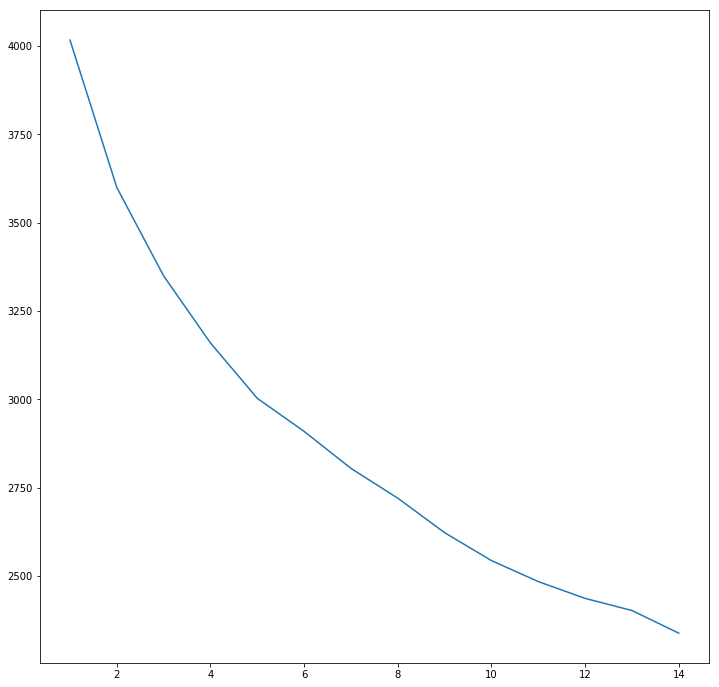

In [95]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [96]:
kmeans_mfcc = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [97]:
kmeans_mfcc.labels_

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,

In [98]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,

In [99]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [100]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.784459     0.109342     0.681608     1.151904    -0.707724   
1       0.213444     0.453851     0.215705     0.987439    -1.851748   
2       1.478029     0.664210     0.484232     0.450284    -0.427587   
3      -0.846386    -0.742706    -0.734786    -0.199585    -0.328948   
4      -0.952033    -0.794706    -1.141199    -0.070979     0.454453   
5      -1.244473     2.250723     2.321007     0.549219     1.971653   
6      -0.128652     0.958605     1.191477     0.705974     0.793937   
7      -1.148662     0.562286     0.636059     0.222732     0.741470   
8      -0.440190     0.461355    -0.016542    -0.158636     0.985626   
9      -0.695730     0.398404     1.069978    -0.124019     0.736597   
10     -0.006662     0.163832     1.373872    -0.095120     1.621755   
11     -0.771763    -0.484525    -0.874411     0.647747    -1.241650   
12      0.140770     1.869847    -1.926303    -2.491201    -2.679759   
13     -1.952477    -0.949813     0.063314     1.188657     1.059601   
14     -0.895529     0.398850    -0.469782     1.216393     0.657294   
15     -1.161372     1.475106     1.486594     0.127516     0.213940   
16     -0.476792     2.179287     0.101035    -1.393755    -0.740834   
17     -0.089088    -0.841832     0.674093    -0.842623     0.904577   
18     -1.772732     0.488101     0.057829     0.041074     0.732429   
19     -0.640351     0.068493     0.619966    -0.599171     0.860806   
20      0.590240     0.699904    -0.097902     0.127319    -0.882999   
21      0.500240     0.875222    -0.833826     0.377484     0.023480   
22     -0.076653     0.518030     0.003390     0.452969    -0.218736   
23      0.010763    -0.352873    -0.460051     0.423968    -0.228393   
24      0.874600     0.173728    -1.041125     0.845285     1.139221   
25      0.200637     0.337376     0.022126     1.189135    -0.210135   
26      0.362627     0.159292    -1.211688    -0.555502     0.107540   
27     -0.504648    -0.561515    -2.173809    -1.525691    -0.810132   
28     -0.339646    -2.140319    -1.409226    -0.207553    -1.216547   
29     -1.279089     1.555887     0.890503     2.134195     0.337580   
..           ...          ...          ...          ...          ...   
279    -1.132789    -0.931481    -0.350024    -0.228575    -1.201208   
280    -0.375948     0.058369     0.489068     0.862825    -1.876102   
281     0.412883    -1.703432    -0.514845    -1.382818    -0.713972   
282    -0.152329    -2.012108    -0.217355    -1.122627    -0.851075   
283     0.348443    -2.381428     1.267515    -1.713290     0.161262   
284    -0.895866     1.001673     1.059356     0.166883    -0.710729   
285     0.417102     1.957515     2.350604    -1.125042    -2.206390   
286    -0.900897    -0.289100     0.433265    -0.281829    -0.379951   
287    -0.002448    -0.853612     0.441903     0.406478    -0.823085   
288    -0.528092    -1.022206    -0.348679     0.093718    -1.642833   
289    -0.387248    -1.305014    -0.365540     0.202745    -0.906016   
290     0.425324    -2.583173    -2.181080    -1.262030    -0.179265   
291    -0.572282    -0.375532    -2.067885    -0.361247    -0.315065   
292    -0.084382    -1.508230    -0.105496    -1.930204    -1.529664   
293    -1.172703     0.783209    -1.141589    -0.982768    -0.513216   
294    -1.293038     0.838303    -1.049071    -0.708031    -0.779995   
295     0.809878    -0.351504    -2.231752    -0.556719    -1.430264   
296     0.305449    -0.148924    -0.727054    -0.126830     0.467272   
297     1.212224     1.916789     0.287969    -0.073842     0.289112   
298    -0.121307     0.217217     0.030920    -0.201270    -0.752001   
299    -0.622824    -0.595352     0.256282    -0.111551     0.023990   
300    -0.667480    -0.808638     0.730781     0.054549     0.191421   
301     0.928382    -2.375767    -0.427528    -0.852350    -1.137004   
302    -0.483888     0.443846     0.129714   

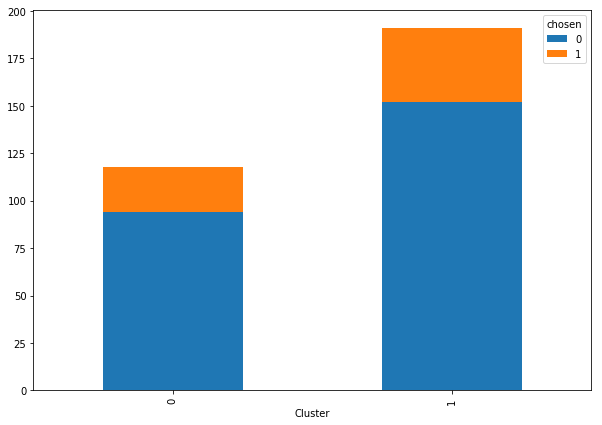

In [101]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [222]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[3]))

## Hotel Marrakech

### ANN

In [268]:
X = df_n_ps_std_mfcc[3]

In [269]:
y = df_n_ps[3]['chosen']

In [270]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [271]:
X_train.shape

(139, 13)

In [107]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [108]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [109]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [110]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30, 20, 10), 'learning_rate_init': 0.003, 'max_iter': 75}, que permiten obtener un Accuracy de 86.33% y un Kappa del 66.54
Tiempo total: 21.38 minutos


In [272]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.003
epochs = 75

In [273]:
input_tensor = Input(shape = (n0,))

In [274]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [275]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [276]:
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 13)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 30)                420       
_________________________________________________________________
dense_38 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_39 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 11        
Total params: 1,261
Trainable params: 1,261
Non-trainable params: 0
_________________________________________________________________


In [277]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 139 samples, validate on 47 samples
Epoch 1/75
139/139 [==============================] - 0s 2ms/step - loss: 0.7119 - accuracy: 0.4748 - val_loss: 0.6764 - val_accuracy: 0.5957
Epoch 2/75
139/139 [==============================] - 0s 79us/step - loss: 0.6629 - accuracy: 0.6619 - val_loss: 0.6286 - val_accuracy: 0.7021
Epoch 3/75
139/139 [==============================] - 0s 72us/step - loss: 0.6227 - accuracy: 0.7914 - val_loss: 0.5921 - val_accuracy: 0.7447
Epoch 4/75
139/139 [==============================] - 0s 79us/step - loss: 0.5865 - accuracy: 0.8058 - val_loss: 0.5597 - val_accuracy: 0.7660
Epoch 5/75
139/139 [==============================] - 0s 72us/step - loss: 0.5507 - accuracy: 0.8201 - val_loss: 0.5260 - val_accuracy: 0.7660
Epoch 6/75
139/139 [==============================] - 0s 79us/step - loss: 0.5136 - accuracy: 0.8489 - val_loss: 0.4960 - val_accuracy: 0.7872
Epoch 7/75
139/139 [==============================] - 0s 86us/step - loss: 0.4773 - accuracy: 0.84

139/139 [==============================] - 0s 86us/step - loss: 0.1964 - accuracy: 0.9281 - val_loss: 0.4860 - val_accuracy: 0.8085
Epoch 56/75
139/139 [==============================] - 0s 93us/step - loss: 0.1960 - accuracy: 0.9281 - val_loss: 0.4854 - val_accuracy: 0.8085
Epoch 57/75
139/139 [==============================] - 0s 93us/step - loss: 0.1955 - accuracy: 0.9281 - val_loss: 0.4850 - val_accuracy: 0.8085
Epoch 58/75
139/139 [==============================] - 0s 101us/step - loss: 0.1950 - accuracy: 0.9281 - val_loss: 0.4849 - val_accuracy: 0.8298
Epoch 59/75
139/139 [==============================] - 0s 79us/step - loss: 0.1946 - accuracy: 0.9281 - val_loss: 0.4848 - val_accuracy: 0.8298
Epoch 60/75
139/139 [==============================] - 0s 93us/step - loss: 0.1940 - accuracy: 0.9281 - val_loss: 0.4851 - val_accuracy: 0.8298
Epoch 61/75
139/139 [==============================] - 0s 86us/step - loss: 0.1936 - accuracy: 0.9281 - val_loss: 0.4849 - val_accuracy: 0.8298
Epo

range(0, 75)


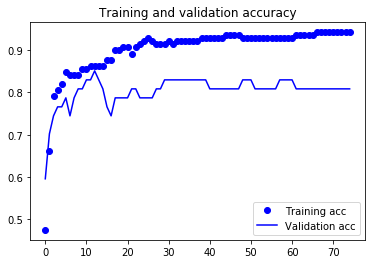

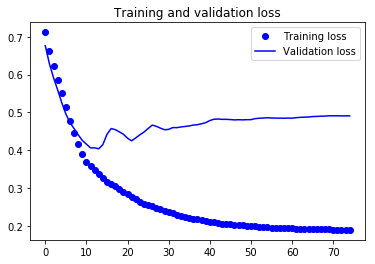

In [278]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [279]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

47/47 [==============================] - 0s 170us/step
test loss: 0.49097854279457254, test accuracy: 0.8085106611251831


In [280]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.8571428571428572


In [281]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.5346534653465347


### KMeans

In [121]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.311006     1.696486     0.912001    -0.211934    -0.513557   
1       0.947147    -0.576741    -1.258913    -0.786859     0.887961   
2      -0.115048     1.257050     0.043002    -2.677464     3.902183   
3       0.621032     1.417449     1.399722    -0.625673     1.012110   
4       0.340978     1.662814    -1.775422     0.156552     1.678811   
5       0.426765    -1.056701    -1.244088    -0.696846    -0.372415   
6       0.210857    -1.779497    -2.206121    -0.832640     0.636169   
7      -0.821293    -0.049796     0.237440     0.379918     0.714133   
8       0.420103    -0.662020    -0.550543    -0.566406    -0.923203   
9      -1.436247     0.435343     2.482690     1.099668    -0.392845   
10     -1.574051    -1.334372    -1.636184     1.768991    -0.369456   
11     -1.798986    -1.632467    -1.314854     2.656006    -0.096678   
12     -0.708207     0.931180     0.258840    -0.189291    -0.204832   
13     -2.007033    -0.288096     0.099713     0.390909     1.333138   
14     -0.497985     0.020592    -0.123619     0.165046    -0.765078   
15      1.200625     0.984580    -0.234312     0.348855     0.175663   
16      0.435253     3.280178     0.407736     1.143148     2.291571   
17     -0.398944     0.035026    -1.634042    -1.354378     0.854385   
18     -0.454008    -0.234096    -0.930672    -0.507506     0.545773   
19      0.149846     0.062252    -0.002122     0.786346     0.810930   
20     -0.314274     0.446482     0.889744     0.891114     1.249237   
21      0.659365     1.053258    -0.877939    -0.295954    -1.122110   
22      0.568507    -0.357318    -1.183577    -0.069205     0.462644   
23      0.696474     0.477607    -1.637469    -1.158983    -2.224208   
24     -0.221795    -0.513464    -0.506448     0.594506     0.033232   
25      0.036099    -0.007586     0.116729     0.438081    -1.526141   
26     -0.291576    -0.372192    -1.176599     0.078535     0.516288   
27      0.953536     0.427304    -0.554063     0.425439     1.368674   
28     -1.172014     1.307258    -1.059323    -0.655908     1.591107   
29     -0.954427     0.000731    -0.367958     0.281024     0.303337   
..           ...          ...          ...          ...          ...   
156     0.232363    -1.167339    -0.114632     1.240724    -0.209611   
157    -1.686193    -0.806140    -0.531342    -0.411912     0.312945   
158     0.487798     1.116042    -0.308817     0.175231    -0.191701   
159     1.049575     0.742765     0.000505     0.670386     0.235663   
160     0.285967     0.602916    -0.009050     0.802464     0.333031   
161     2.568510    -0.180837     0.794882     1.410838     0.898076   
162     0.821849     0.906757     0.282262     0.304716    -0.691824   
163     2.581037     0.239015     1.212048     0.498566     0.095720   
164    -0.247271    -0.874145    -0.840584     0.233138     0.034101   
165     0.188979    -0.519200     0.108496    -0.513645    -0.637646   
166    -0.015438    -0.656621    -0.739614     0.302131     0.583862   
167    -1.567081    -1.052883    -0.417918     0.636963    -0.531279   
168    -1.883530    -0.172892    -0.340073    -0.255266    -0.480237   
169    -1.577057    -0.602693     0.448785     1.073850    -0.714538   
170     0.667824    -0.298287    -0.412356    -1.154598     0.171532   
171     0.626343    -0.046406    -0.168999    -1.278941     0.502027   
172    -0.441233    -0.987406     0.015664    -2.982951    -0.379800   
173     0.331514     0.334707    -0.187508     0.489055     1.133140   
174     0.480131     0.345645     0.202709    -0.423456     1.184414   
175     1.039410    -0.773764     0.113739    -0.796036    -1.053802   
176     0.194148    -0.229033    -0.571129    -0.704359    -0.204400   
177    -0.169188     0.025195    -0.189648     0.376353     0.802036   
178     1.433007     0.217051    -0.388425    -1.158798     2.068592   
179     1.371536     0.624596    -0.082552   

In [122]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2418.0,
 2172.1027618675616,
 1998.025251732407,
 1881.5714074571665,
 1790.4988909951144,
 1710.5509624175916,
 1638.1160961205187,
 1594.2979605381602,
 1541.5219098889218,
 1492.348355544395,
 1435.6626781919845,
 1397.526425851007,
 1339.3046499586067,
 1333.0833102955885]

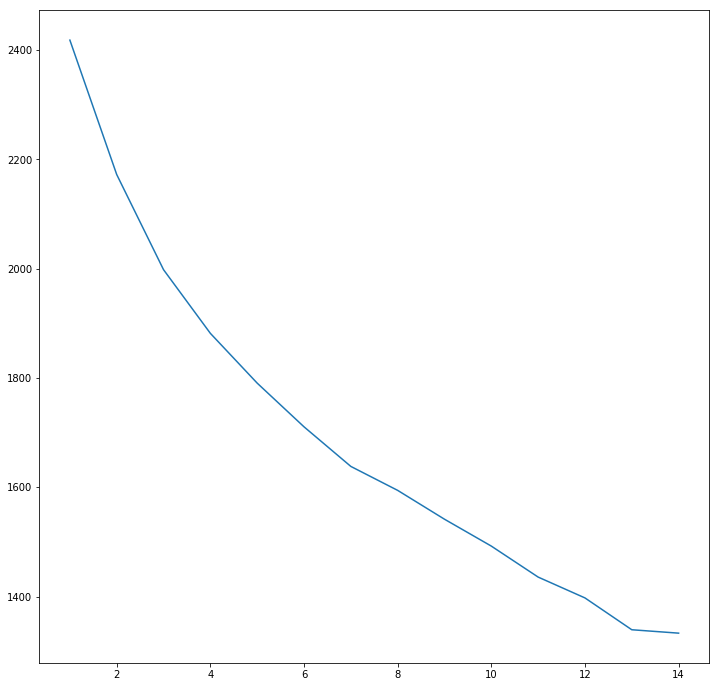

In [123]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [124]:
kmeans_mfcc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [125]:
kmeans_mfcc.labels_

array([1, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1,
       1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1,
       1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 2,
       0, 1, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2,
       1, 0, 0, 0, 2, 2, 0, 0, 2, 2])

In [126]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([1, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1,
       1, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 1, 0, 2, 2, 2, 0, 2, 1, 1, 1,
       1, 2, 0, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2, 2,
       0, 1, 1, 0, 1, 0, 2, 2, 2, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1,
       2, 2, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 2, 1, 0, 2, 2, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 1, 2, 0, 0, 2,
       1, 0, 0, 0, 2, 2, 0, 0, 2, 2])

In [127]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [128]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.311006     1.696486     0.912001    -0.211934    -0.513557   
1       0.947147    -0.576741    -1.258913    -0.786859     0.887961   
2      -0.115048     1.257050     0.043002    -2.677464     3.902183   
3       0.621032     1.417449     1.399722    -0.625673     1.012110   
4       0.340978     1.662814    -1.775422     0.156552     1.678811   
5       0.426765    -1.056701    -1.244088    -0.696846    -0.372415   
6       0.210857    -1.779497    -2.206121    -0.832640     0.636169   
7      -0.821293    -0.049796     0.237440     0.379918     0.714133   
8       0.420103    -0.662020    -0.550543    -0.566406    -0.923203   
9      -1.436247     0.435343     2.482690     1.099668    -0.392845   
10     -1.574051    -1.334372    -1.636184     1.768991    -0.369456   
11     -1.798986    -1.632467    -1.314854     2.656006    -0.096678   
12     -0.708207     0.931180     0.258840    -0.189291    -0.204832   
13     -2.007033    -0.288096     0.099713     0.390909     1.333138   
14     -0.497985     0.020592    -0.123619     0.165046    -0.765078   
15      1.200625     0.984580    -0.234312     0.348855     0.175663   
16      0.435253     3.280178     0.407736     1.143148     2.291571   
17     -0.398944     0.035026    -1.634042    -1.354378     0.854385   
18     -0.454008    -0.234096    -0.930672    -0.507506     0.545773   
19      0.149846     0.062252    -0.002122     0.786346     0.810930   
20     -0.314274     0.446482     0.889744     0.891114     1.249237   
21      0.659365     1.053258    -0.877939    -0.295954    -1.122110   
22      0.568507    -0.357318    -1.183577    -0.069205     0.462644   
23      0.696474     0.477607    -1.637469    -1.158983    -2.224208   
24     -0.221795    -0.513464    -0.506448     0.594506     0.033232   
25      0.036099    -0.007586     0.116729     0.438081    -1.526141   
26     -0.291576    -0.372192    -1.176599     0.078535     0.516288   
27      0.953536     0.427304    -0.554063     0.425439     1.368674   
28     -1.172014     1.307258    -1.059323    -0.655908     1.591107   
29     -0.954427     0.000731    -0.367958     0.281024     0.303337   
..           ...          ...          ...          ...          ...   
156     0.232363    -1.167339    -0.114632     1.240724    -0.209611   
157    -1.686193    -0.806140    -0.531342    -0.411912     0.312945   
158     0.487798     1.116042    -0.308817     0.175231    -0.191701   
159     1.049575     0.742765     0.000505     0.670386     0.235663   
160     0.285967     0.602916    -0.009050     0.802464     0.333031   
161     2.568510    -0.180837     0.794882     1.410838     0.898076   
162     0.821849     0.906757     0.282262     0.304716    -0.691824   
163     2.581037     0.239015     1.212048     0.498566     0.095720   
164    -0.247271    -0.874145    -0.840584     0.233138     0.034101   
165     0.188979    -0.519200     0.108496    -0.513645    -0.637646   
166    -0.015438    -0.656621    -0.739614     0.302131     0.583862   
167    -1.567081    -1.052883    -0.417918     0.636963    -0.531279   
168    -1.883530    -0.172892    -0.340073    -0.255266    -0.480237   
169    -1.577057    -0.602693     0.448785     1.073850    -0.714538   
170     0.667824    -0.298287    -0.412356    -1.154598     0.171532   
171     0.626343    -0.046406    -0.168999    -1.278941     0.502027   
172    -0.441233    -0.987406     0.015664    -2.982951    -0.379800   
173     0.331514     0.334707    -0.187508     0.489055     1.133140   
174     0.480131     0.345645     0.202709    -0.423456     1.184414   
175     1.039410    -0.773764     0.113739    -0.796036    -1.053802   
176     0.194148    -0.229033    -0.571129    -0.704359    -0.204400   
177    -0.169188     0.025195    -0.189648     0.376353     0.802036   
178     1.433007     0.217051    -0.388425    -1.158798     2.068592   
179     1.371536     0.624596    -0.082552   

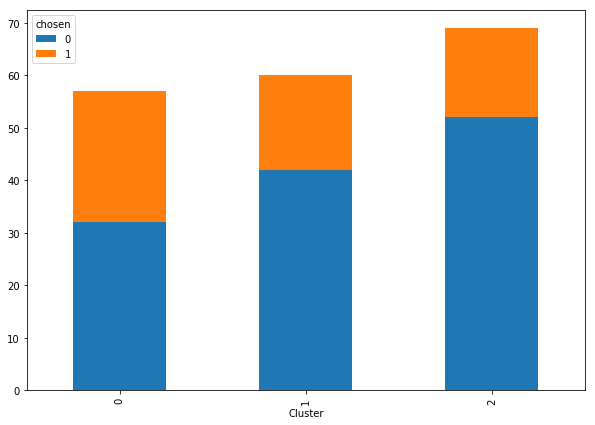

In [129]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [237]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[4]))

## Specialized

### ANN

In [282]:
X = df_n_ps_std_mfcc[4]

In [283]:
y = df_n_ps[4]['chosen']

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [285]:
X_train.shape

(164, 13)

In [135]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [136]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [137]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [138]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.003, 'max_iter': 400}, que permiten obtener un Accuracy de 72.56% y un Kappa del 45.12
Tiempo total: 20.25 minutos


In [286]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,20,20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.003
epochs = 400

In [287]:
input_tensor = Input(shape = (n0,))

In [288]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [289]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [290]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 13)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_42 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_43 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [291]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 164 samples, validate on 55 samples
Epoch 1/400
164/164 [==============================] - 0s 1ms/step - loss: 0.7168 - accuracy: 0.4817 - val_loss: 0.6811 - val_accuracy: 0.5636
Epoch 2/400
164/164 [==============================] - 0s 85us/step - loss: 0.6669 - accuracy: 0.5854 - val_loss: 0.6870 - val_accuracy: 0.6000
Epoch 3/400
164/164 [==============================] - 0s 98us/step - loss: 0.6599 - accuracy: 0.6220 - val_loss: 0.7104 - val_accuracy: 0.5818
Epoch 4/400
164/164 [==============================] - 0s 98us/step - loss: 0.6420 - accuracy: 0.6341 - val_loss: 0.7219 - val_accuracy: 0.5636
Epoch 5/400
164/164 [==============================] - 0s 85us/step - loss: 0.6310 - accuracy: 0.6829 - val_loss: 0.7212 - val_accuracy: 0.5636
Epoch 6/400
164/164 [==============================] - 0s 91us/step - loss: 0.6193 - accuracy: 0.6951 - val_loss: 0.7314 - val_accuracy: 0.4727
Epoch 7/400
164/164 [==============================] - 0s 85us/step - loss: 0.6119 - accurac

164/164 [==============================] - 0s 104us/step - loss: 0.4507 - accuracy: 0.7805 - val_loss: 0.9486 - val_accuracy: 0.3818
Epoch 55/400
164/164 [==============================] - 0s 85us/step - loss: 0.4503 - accuracy: 0.7805 - val_loss: 0.9493 - val_accuracy: 0.3818
Epoch 56/400
164/164 [==============================] - 0s 79us/step - loss: 0.4499 - accuracy: 0.7805 - val_loss: 0.9502 - val_accuracy: 0.3818
Epoch 57/400
164/164 [==============================] - 0s 85us/step - loss: 0.4495 - accuracy: 0.7866 - val_loss: 0.9506 - val_accuracy: 0.3818
Epoch 58/400
164/164 [==============================] - 0s 91us/step - loss: 0.4490 - accuracy: 0.7866 - val_loss: 0.9514 - val_accuracy: 0.3818
Epoch 59/400
164/164 [==============================] - 0s 79us/step - loss: 0.4486 - accuracy: 0.7866 - val_loss: 0.9518 - val_accuracy: 0.3818
Epoch 60/400
164/164 [==============================] - 0s 79us/step - loss: 0.4482 - accuracy: 0.7866 - val_loss: 0.9530 - val_accuracy: 0.40

164/164 [==============================] - 0s 91us/step - loss: 0.4432 - accuracy: 0.8049 - val_loss: 0.9541 - val_accuracy: 0.4182
Epoch 108/400
164/164 [==============================] - 0s 91us/step - loss: 0.4432 - accuracy: 0.8049 - val_loss: 0.9541 - val_accuracy: 0.4182
Epoch 109/400
164/164 [==============================] - 0s 98us/step - loss: 0.4432 - accuracy: 0.8049 - val_loss: 0.9541 - val_accuracy: 0.4182
Epoch 110/400
164/164 [==============================] - 0s 85us/step - loss: 0.4432 - accuracy: 0.8049 - val_loss: 0.9541 - val_accuracy: 0.4182
Epoch 111/400
164/164 [==============================] - 0s 79us/step - loss: 0.4431 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 112/400
164/164 [==============================] - 0s 98us/step - loss: 0.4431 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182

Epoch 00112: ReduceLROnPlateau reducing learning rate to 1.4648437627329258e-06.
Epoch 113/400
164/164 [==============================] -

164/164 [==============================] - 0s 97us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 161/400
164/164 [==============================] - 0s 85us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 162/400
164/164 [==============================] - 0s 79us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182

Epoch 00162: ReduceLROnPlateau reducing learning rate to 4.577636758540393e-08.
Epoch 163/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 164/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 165/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 166/400
164/164 [==============================] - 

Epoch 213/400
164/164 [==============================] - 0s 91us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 214/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 215/400
164/164 [==============================] - 0s 85us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 216/400
164/164 [==============================] - 0s 85us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 217/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 218/400
164/164 [==============================] - 0s 79us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 219/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 -

164/164 [==============================] - 0s 85us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 267/400
164/164 [==============================] - 0s 91us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 268/400
164/164 [==============================] - 0s 79us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 269/400
164/164 [==============================] - 0s 79us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 270/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 271/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 272/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy:

164/164 [==============================] - 0s 79us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 320/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 321/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 322/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182

Epoch 00322: ReduceLROnPlateau reducing learning rate to 6.984919370331411e-13.
Epoch 323/400
164/164 [==============================] - 0s 91us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 324/400
164/164 [==============================] - 0s 91us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 325/400
164/164 [==============================] - 

164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182

Epoch 00372: ReduceLROnPlateau reducing learning rate to 2.1827873032285658e-14.
Epoch 373/400
164/164 [==============================] - 0s 73us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 374/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 375/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 376/400
164/164 [==============================] - 0s 67us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 377/400
164/164 [==============================] - 0s 91us/step - loss: 0.4430 - accuracy: 0.8049 - val_loss: 0.9542 - val_accuracy: 0.4182
Epoch 378/400
164/164 [==============================] -

range(0, 400)


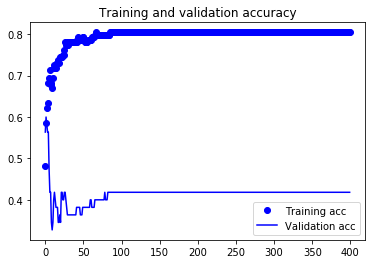

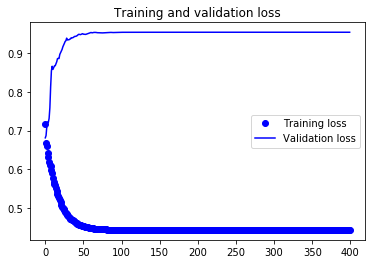

In [292]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [293]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

55/55 [==============================] - 0s 55us/step
test loss: 0.9541770685802806, test accuracy: 0.41818180680274963


In [294]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.4260752688172043


In [295]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  -0.13989637305699487


### KMeans

In [149]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.992062    -0.477172    -1.079451    -2.369470    -1.705431   
1       0.843575    -0.507672    -0.731713    -0.334904     1.442336   
2       0.816922    -0.263544     0.639646    -0.865417     1.276602   
3       4.368525     0.851784    -0.671158    -0.128467     2.141169   
4       0.001312     0.535305    -0.648296     0.221414     0.549478   
5      -0.236754     0.488978     0.203743     0.088401    -0.151814   
6      -0.842496     0.742173     0.068601     1.394492    -0.276167   
7      -0.952702     1.078642    -0.563379    -0.018149    -0.073042   
8       0.046457    -0.093025    -0.804385     0.542662    -0.130939   
9      -0.781158     0.099463     0.196737     2.462131     0.316140   
10     -0.906167     0.568017     0.700382     2.876646    -0.809125   
11      1.172687     1.292213    -0.402038     0.087342     0.324539   
12      0.367875     1.949889     0.516382     0.657124    -0.534306   
13      1.270520     1.194102     0.267933     0.676186     0.394734   
14     -0.095931     0.792392     0.626113     0.189989     0.315198   
15     -0.322645     0.977766     0.685697     0.670670     0.997903   
16      0.565974     0.440551     0.402995     1.815814     1.906139   
17     -0.863540     0.887127     1.387720    -0.082168    -0.694633   
18     -0.822258    -0.630193    -0.672294    -0.279417    -0.731983   
19     -0.889164     0.641922     2.278761     0.190213    -0.341231   
20      0.795964     0.484784     0.898919     0.027625     0.415359   
21      0.168183    -0.077353     1.019887    -0.637065     0.731534   
22      0.510023    -0.099060     0.064384    -0.039933     0.786951   
23      0.216210    -0.069447     0.974822    -0.626273     0.835854   
24     -0.239273    -0.518568    -0.127834     0.045011     0.403223   
25     -1.241907     1.355534    -0.693470     0.793789     0.606007   
26     -0.847436     1.180146    -0.489592     1.189572    -0.457645   
27     -0.378383     1.017722    -1.812001     0.443514     0.583209   
28      0.245370     1.187084     1.056929     2.013063    -0.505622   
29     -0.623386     1.368898     1.216933     1.961377     0.744541   
..           ...          ...          ...          ...          ...   
189    -0.565077     0.809784     0.557457     0.815038     0.823053   
190    -0.602848     0.638838     0.763481    -0.424641    -0.810302   
191    -1.094031    -0.896961     0.400325    -1.635971    -1.099938   
192    -0.348357     0.944340     0.239675     0.003612    -1.370450   
193     2.110671    -1.005236     0.268022     0.459390    -1.985350   
194     1.222194    -1.600122    -1.149302     0.230839    -0.213026   
195    -0.509789    -0.757711     0.189267     0.516644     0.750906   
196     0.194175    -0.618441    -1.090420     0.233017    -1.492602   
197     0.297635    -0.727616    -1.927078    -0.145347    -0.990256   
198    -0.271030    -0.575137    -1.005334    -0.238705    -0.931830   
199     0.059096    -0.370313    -0.760047     0.706270    -2.488266   
200     0.147539    -0.233608    -0.578016     0.870637    -2.418094   
201    -0.076214    -1.055629     0.159389    -0.403318    -0.111273   
202     1.468986     0.518464     1.475456    -1.400891     0.408186   
203    -1.739107     0.192104    -0.670709    -1.236237    -1.672915   
204    -0.663868    -0.862566    -0.329803    -0.857680     0.167824   
205    -0.739818    -0.668220    -0.077479     0.026286     0.027801   
206     0.475752     0.695473    -0.072097     1.081397    -0.366985   
207    -1.331365    -1.632552    -0.876636     0.076190     1.187799   
208    -0.397476     0.090963     1.217996     0.773741     1.107204   
209    -0.465823    -1.372705    -0.445436     0.316510    -1.492946   
210    -0.594535    -1.761364    -1.069906    -0.502969    -1.411276   
211    -1.022693     0.373374    -0.104205    -0.815628    -0.574733   
212    -0.967902     0.155275     0.013938   

In [150]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2847.0,
 2572.5760570812117,
 2370.209947155015,
 2235.6129406180157,
 2112.951551625758,
 2041.1809211260454,
 1982.3615393500422,
 1899.0667595696164,
 1851.9267246215204,
 1760.4468946465518,
 1745.79714786859,
 1689.1350809615656,
 1657.4940102564742,
 1625.370413913055]

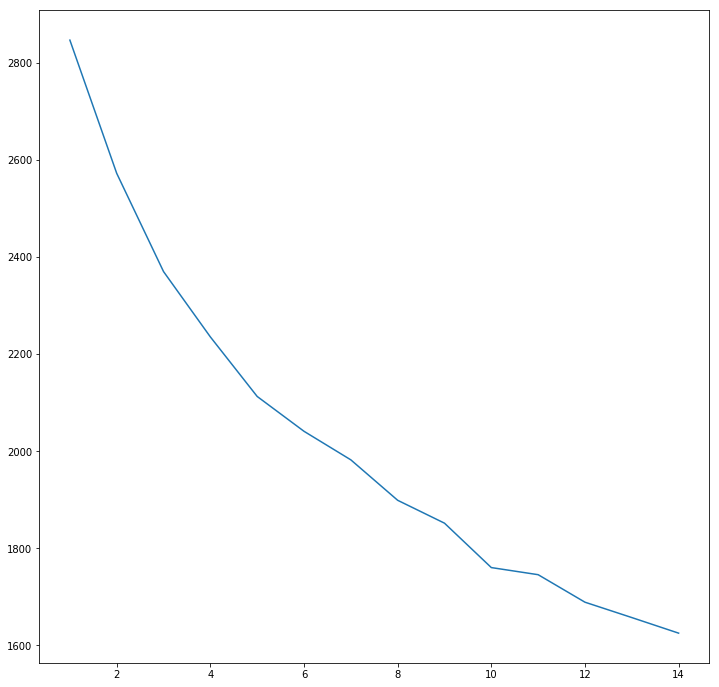

In [151]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [152]:
kmeans_mfcc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [153]:
kmeans_mfcc.labels_

array([1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2,
       1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2,
       0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 0, 1])

In [154]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 2,
       1, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 1, 1, 2, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 2,
       0, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       0, 0, 1, 0, 2, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1, 2, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 2, 2, 2, 0, 2,
       2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 2, 0, 0, 1, 0, 1])

In [155]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [156]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0       0.992062    -0.477172    -1.079451    -2.369470    -1.705431   
1       0.843575    -0.507672    -0.731713    -0.334904     1.442336   
2       0.816922    -0.263544     0.639646    -0.865417     1.276602   
3       4.368525     0.851784    -0.671158    -0.128467     2.141169   
4       0.001312     0.535305    -0.648296     0.221414     0.549478   
5      -0.236754     0.488978     0.203743     0.088401    -0.151814   
6      -0.842496     0.742173     0.068601     1.394492    -0.276167   
7      -0.952702     1.078642    -0.563379    -0.018149    -0.073042   
8       0.046457    -0.093025    -0.804385     0.542662    -0.130939   
9      -0.781158     0.099463     0.196737     2.462131     0.316140   
10     -0.906167     0.568017     0.700382     2.876646    -0.809125   
11      1.172687     1.292213    -0.402038     0.087342     0.324539   
12      0.367875     1.949889     0.516382     0.657124    -0.534306   
13      1.270520     1.194102     0.267933     0.676186     0.394734   
14     -0.095931     0.792392     0.626113     0.189989     0.315198   
15     -0.322645     0.977766     0.685697     0.670670     0.997903   
16      0.565974     0.440551     0.402995     1.815814     1.906139   
17     -0.863540     0.887127     1.387720    -0.082168    -0.694633   
18     -0.822258    -0.630193    -0.672294    -0.279417    -0.731983   
19     -0.889164     0.641922     2.278761     0.190213    -0.341231   
20      0.795964     0.484784     0.898919     0.027625     0.415359   
21      0.168183    -0.077353     1.019887    -0.637065     0.731534   
22      0.510023    -0.099060     0.064384    -0.039933     0.786951   
23      0.216210    -0.069447     0.974822    -0.626273     0.835854   
24     -0.239273    -0.518568    -0.127834     0.045011     0.403223   
25     -1.241907     1.355534    -0.693470     0.793789     0.606007   
26     -0.847436     1.180146    -0.489592     1.189572    -0.457645   
27     -0.378383     1.017722    -1.812001     0.443514     0.583209   
28      0.245370     1.187084     1.056929     2.013063    -0.505622   
29     -0.623386     1.368898     1.216933     1.961377     0.744541   
..           ...          ...          ...          ...          ...   
189    -0.565077     0.809784     0.557457     0.815038     0.823053   
190    -0.602848     0.638838     0.763481    -0.424641    -0.810302   
191    -1.094031    -0.896961     0.400325    -1.635971    -1.099938   
192    -0.348357     0.944340     0.239675     0.003612    -1.370450   
193     2.110671    -1.005236     0.268022     0.459390    -1.985350   
194     1.222194    -1.600122    -1.149302     0.230839    -0.213026   
195    -0.509789    -0.757711     0.189267     0.516644     0.750906   
196     0.194175    -0.618441    -1.090420     0.233017    -1.492602   
197     0.297635    -0.727616    -1.927078    -0.145347    -0.990256   
198    -0.271030    -0.575137    -1.005334    -0.238705    -0.931830   
199     0.059096    -0.370313    -0.760047     0.706270    -2.488266   
200     0.147539    -0.233608    -0.578016     0.870637    -2.418094   
201    -0.076214    -1.055629     0.159389    -0.403318    -0.111273   
202     1.468986     0.518464     1.475456    -1.400891     0.408186   
203    -1.739107     0.192104    -0.670709    -1.236237    -1.672915   
204    -0.663868    -0.862566    -0.329803    -0.857680     0.167824   
205    -0.739818    -0.668220    -0.077479     0.026286     0.027801   
206     0.475752     0.695473    -0.072097     1.081397    -0.366985   
207    -1.331365    -1.632552    -0.876636     0.076190     1.187799   
208    -0.397476     0.090963     1.217996     0.773741     1.107204   
209    -0.465823    -1.372705    -0.445436     0.316510    -1.492946   
210    -0.594535    -1.761364    -1.069906    -0.502969    -1.411276   
211    -1.022693     0.373374    -0.104205    -0.815628    -0.574733   
212    -0.967902     0.155275     0.013938   

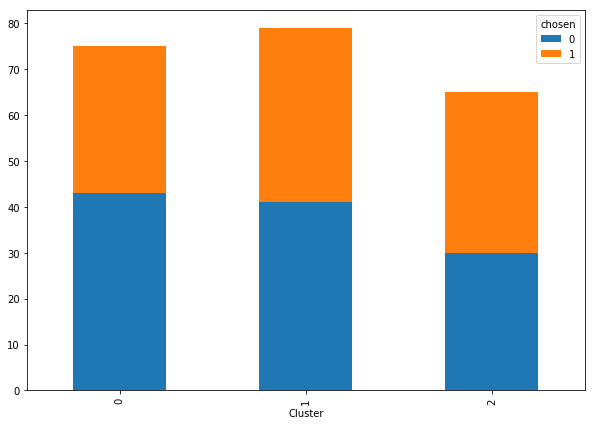

In [157]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [252]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[5]))

## Urban Place

### ANN

In [296]:
X = df_n_ps_std_mfcc[5]

In [297]:
y = df_n_ps[5]['chosen']

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [299]:
X_train.shape

(168, 13)

In [163]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [164]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [165]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [166]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'logistic', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.009, 'max_iter': 1000}, que permiten obtener un Accuracy de 73.81% y un Kappa del 36.33
Tiempo total: 24.57 minutos


In [300]:
n0=X_train.shape[1]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = grid.best_params_['learning_rate_init']
epochs = grid.best_params_['max_iter']

In [301]:
input_tensor = Input(shape = (n0,))

In [302]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [303]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [304]:
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 13)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 20)                280       
_________________________________________________________________
dense_46 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_47 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 21        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [305]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 168 samples, validate on 57 samples
Epoch 1/100
168/168 [==============================] - 0s 1ms/step - loss: 0.6734 - accuracy: 0.5714 - val_loss: 0.6686 - val_accuracy: 0.5789
Epoch 2/100
168/168 [==============================] - 0s 107us/step - loss: 0.6107 - accuracy: 0.6667 - val_loss: 0.6513 - val_accuracy: 0.5614
Epoch 3/100
168/168 [==============================] - 0s 77us/step - loss: 0.5755 - accuracy: 0.7202 - val_loss: 0.6565 - val_accuracy: 0.5965
Epoch 4/100
168/168 [==============================] - 0s 71us/step - loss: 0.5608 - accuracy: 0.7262 - val_loss: 0.6731 - val_accuracy: 0.5965
Epoch 5/100
168/168 [==============================] - 0s 65us/step - loss: 0.5544 - accuracy: 0.7321 - val_loss: 0.6889 - val_accuracy: 0.5789
Epoch 6/100
168/168 [==============================] - 0s 71us/step - loss: 0.5457 - accuracy: 0.7321 - val_loss: 0.6953 - val_accuracy: 0.6316
Epoch 7/100
168/168 [==============================] - 0s 65us/step - loss: 0.5374 - accura

168/168 [==============================] - 0s 65us/step - loss: 0.0740 - accuracy: 1.0000 - val_loss: 0.8995 - val_accuracy: 0.6667
Epoch 57/100
168/168 [==============================] - 0s 71us/step - loss: 0.0733 - accuracy: 1.0000 - val_loss: 0.8922 - val_accuracy: 0.7018
Epoch 58/100
168/168 [==============================] - 0s 65us/step - loss: 0.0719 - accuracy: 1.0000 - val_loss: 0.8924 - val_accuracy: 0.6842
Epoch 59/100
168/168 [==============================] - 0s 65us/step - loss: 0.0707 - accuracy: 1.0000 - val_loss: 0.8931 - val_accuracy: 0.6842
Epoch 60/100
168/168 [==============================] - 0s 65us/step - loss: 0.0695 - accuracy: 1.0000 - val_loss: 0.8913 - val_accuracy: 0.6842
Epoch 61/100
168/168 [==============================] - 0s 77us/step - loss: 0.0685 - accuracy: 1.0000 - val_loss: 0.8970 - val_accuracy: 0.6842
Epoch 62/100
168/168 [==============================] - 0s 71us/step - loss: 0.0674 - accuracy: 1.0000 - val_loss: 0.8957 - val_accuracy: 0.701

range(0, 100)


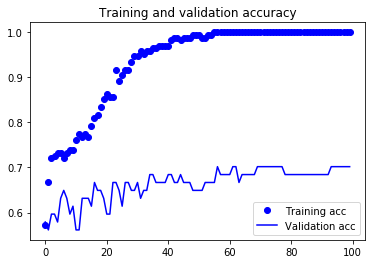

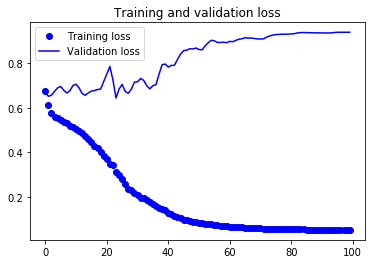

In [306]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [307]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

57/57 [==============================] - 0s 53us/step
test loss: 0.9380739571755392, test accuracy: 0.7017543911933899


In [308]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7188365650969529


In [309]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.37037037037037035


### KMeans

In [177]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -1.430409    -0.286045     0.490919     0.872836    -0.908379   
1      -0.282157    -1.478798    -1.125065     1.134727     0.294401   
2      -0.419749     0.440468     0.853257     0.239250    -0.398831   
3      -0.431942    -1.517593     0.673149     0.786628    -1.306695   
4       0.011173     0.536562    -0.966199    -0.482951     0.331291   
5       0.126251    -0.590904    -1.517639    -1.072279     0.624234   
6       0.830490    -0.982750     2.985373     1.132038     0.506664   
7      -0.461917     0.208363     0.278132     2.301636     1.667266   
8       0.249199    -0.247143    -0.916299     0.679460    -0.342859   
9       0.311144     1.364526    -0.004701     0.405862    -0.939024   
10      1.334587     0.242352     0.597807     1.994512    -0.050194   
11      1.318614    -0.797973     0.011175    -0.735851    -0.310309   
12      0.824621     1.143049     0.195198    -0.036161     0.107483   
13     -0.568472    -0.848858     0.090767     1.154534    -0.215999   
14      0.406968     1.201176     1.075155    -0.124700     0.135767   
15     -0.287723     1.515404     0.539186     0.427811    -0.006824   
16      0.522131     0.617054     0.277861    -0.836147    -1.629099   
17     -0.896889    -1.308091    -0.693222     0.501341    -0.162478   
18      0.875184     0.085665     0.080385     0.242890    -0.938716   
19     -0.659140    -0.549349    -0.129098     1.107800    -3.028026   
20     -0.563764    -2.009854     0.074903    -0.464555    -1.109839   
21      1.250269     0.010904     0.201698    -0.957619    -0.013951   
22     -1.190023    -0.268956    -0.555588    -0.621566    -0.230031   
23     -0.802365     0.152404    -0.567015     0.381822     0.592009   
24     -0.893865     0.341962    -0.830315     0.329795     0.563212   
25     -0.121562     1.347439     0.744281     0.698770    -0.746534   
26     -1.615036     1.323285     0.625582     0.721012    -0.691466   
27     -0.522333     1.534988    -0.017521    -0.056191     0.437400   
28      0.020009    -0.529617    -0.687843    -1.068170    -0.317981   
29      0.294921    -0.175540    -2.170589     0.206338     0.608432   
..           ...          ...          ...          ...          ...   
195    -0.713121    -0.124100     0.184524    -0.289193     1.143155   
196     0.088904    -0.480222     0.314568     0.011773    -0.871197   
197    -0.819978    -0.214030     0.603520    -0.224844     0.008606   
198     0.089868    -0.642488    -0.163873     0.162352    -2.220413   
199     0.490718    -0.570100    -0.601226    -1.373455    -2.219961   
200    -0.725311     0.995058     1.698440    -0.409174     1.345314   
201    -0.088956     0.381477     0.665527     0.871194     0.436489   
202    -0.627833     0.625737     0.574533     0.351258     0.679287   
203    -0.591412    -1.691897    -1.280443     0.004164     0.029231   
204    -0.213359    -0.655305    -0.545729    -0.525488    -0.788705   
205     0.561065    -0.270819    -0.376934     1.362033    -0.711445   
206     0.905511     0.711971     1.427482     0.086910    -0.261378   
207     0.067531     0.386370    -0.307384    -0.040460    -0.049760   
208    -0.059758     0.045608    -0.194712    -0.038341    -0.248229   
209     0.486749    -0.756717    -0.874808    -0.729025    -1.528664   
210    -0.009918     0.023157    -0.108599    -0.353482    -0.525150   
211    -0.852239    -0.126721     1.768756    -0.139569     1.457419   
212    -1.605282     0.546705    -0.027523    -0.007901     0.390982   
213    -1.537486     0.438542    -0.054954    -0.009054     0.565426   
214     0.478176    -0.623588    -1.163628    -0.024044    -0.377051   
215    -0.653553    -0.272142     0.596156     0.881373    -2.295187   
216    -0.746791    -0.229040     0.929885     0.869993    -2.913181   
217    -0.402132     0.567649     0.658617     1.252447     0.282722   
218     0.253416     2.028743    -0.249389   

In [178]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2925.0,
 2654.4694551642833,
 2487.537140339455,
 2347.3385606542174,
 2241.219607532395,
 2187.984558812649,
 2078.2651666536785,
 1992.3748205985125,
 1984.6213758642439,
 1904.4598519281963,
 1850.0132981301954,
 1816.2106987200941,
 1761.4652710138919,
 1722.4326028221699]

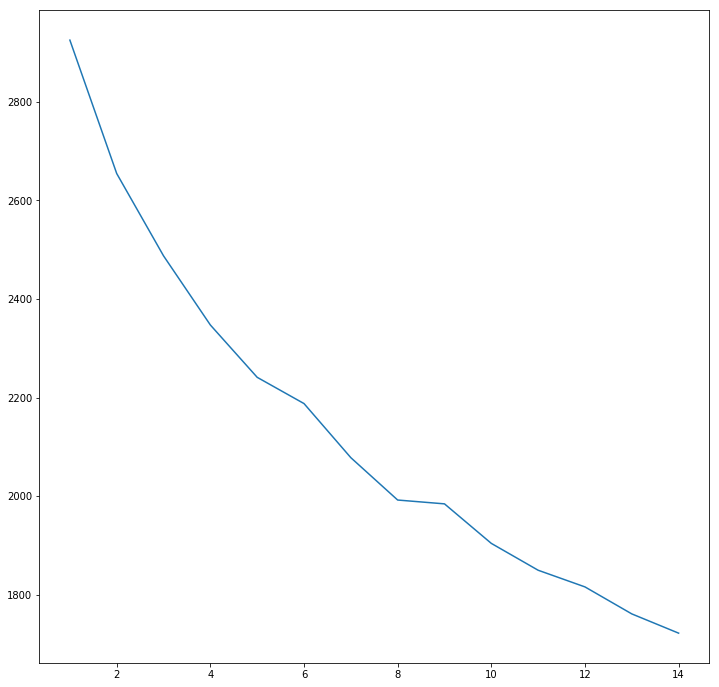

In [179]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [180]:
kmeans_mfcc = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_mfcc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [181]:
kmeans_mfcc.labels_

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0])

In [182]:
clusters_mfcc = kmeans_mfcc.predict(X)
clusters_mfcc

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0])

In [183]:
X.loc[:,'Cluster'] = clusters_mfcc
X.loc[:,'chosen'] = list(y)

In [184]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -1.430409    -0.286045     0.490919     0.872836    -0.908379   
1      -0.282157    -1.478798    -1.125065     1.134727     0.294401   
2      -0.419749     0.440468     0.853257     0.239250    -0.398831   
3      -0.431942    -1.517593     0.673149     0.786628    -1.306695   
4       0.011173     0.536562    -0.966199    -0.482951     0.331291   
5       0.126251    -0.590904    -1.517639    -1.072279     0.624234   
6       0.830490    -0.982750     2.985373     1.132038     0.506664   
7      -0.461917     0.208363     0.278132     2.301636     1.667266   
8       0.249199    -0.247143    -0.916299     0.679460    -0.342859   
9       0.311144     1.364526    -0.004701     0.405862    -0.939024   
10      1.334587     0.242352     0.597807     1.994512    -0.050194   
11      1.318614    -0.797973     0.011175    -0.735851    -0.310309   
12      0.824621     1.143049     0.195198    -0.036161     0.107483   
13     -0.568472    -0.848858     0.090767     1.154534    -0.215999   
14      0.406968     1.201176     1.075155    -0.124700     0.135767   
15     -0.287723     1.515404     0.539186     0.427811    -0.006824   
16      0.522131     0.617054     0.277861    -0.836147    -1.629099   
17     -0.896889    -1.308091    -0.693222     0.501341    -0.162478   
18      0.875184     0.085665     0.080385     0.242890    -0.938716   
19     -0.659140    -0.549349    -0.129098     1.107800    -3.028026   
20     -0.563764    -2.009854     0.074903    -0.464555    -1.109839   
21      1.250269     0.010904     0.201698    -0.957619    -0.013951   
22     -1.190023    -0.268956    -0.555588    -0.621566    -0.230031   
23     -0.802365     0.152404    -0.567015     0.381822     0.592009   
24     -0.893865     0.341962    -0.830315     0.329795     0.563212   
25     -0.121562     1.347439     0.744281     0.698770    -0.746534   
26     -1.615036     1.323285     0.625582     0.721012    -0.691466   
27     -0.522333     1.534988    -0.017521    -0.056191     0.437400   
28      0.020009    -0.529617    -0.687843    -1.068170    -0.317981   
29      0.294921    -0.175540    -2.170589     0.206338     0.608432   
..           ...          ...          ...          ...          ...   
195    -0.713121    -0.124100     0.184524    -0.289193     1.143155   
196     0.088904    -0.480222     0.314568     0.011773    -0.871197   
197    -0.819978    -0.214030     0.603520    -0.224844     0.008606   
198     0.089868    -0.642488    -0.163873     0.162352    -2.220413   
199     0.490718    -0.570100    -0.601226    -1.373455    -2.219961   
200    -0.725311     0.995058     1.698440    -0.409174     1.345314   
201    -0.088956     0.381477     0.665527     0.871194     0.436489   
202    -0.627833     0.625737     0.574533     0.351258     0.679287   
203    -0.591412    -1.691897    -1.280443     0.004164     0.029231   
204    -0.213359    -0.655305    -0.545729    -0.525488    -0.788705   
205     0.561065    -0.270819    -0.376934     1.362033    -0.711445   
206     0.905511     0.711971     1.427482     0.086910    -0.261378   
207     0.067531     0.386370    -0.307384    -0.040460    -0.049760   
208    -0.059758     0.045608    -0.194712    -0.038341    -0.248229   
209     0.486749    -0.756717    -0.874808    -0.729025    -1.528664   
210    -0.009918     0.023157    -0.108599    -0.353482    -0.525150   
211    -0.852239    -0.126721     1.768756    -0.139569     1.457419   
212    -1.605282     0.546705    -0.027523    -0.007901     0.390982   
213    -1.537486     0.438542    -0.054954    -0.009054     0.565426   
214     0.478176    -0.623588    -1.163628    -0.024044    -0.377051   
215    -0.653553    -0.272142     0.596156     0.881373    -2.295187   
216    -0.746791    -0.229040     0.929885     0.869993    -2.913181   
217    -0.402132     0.567649     0.658617     1.252447     0.282722   
218     0.253416     2.028743    -0.249389   

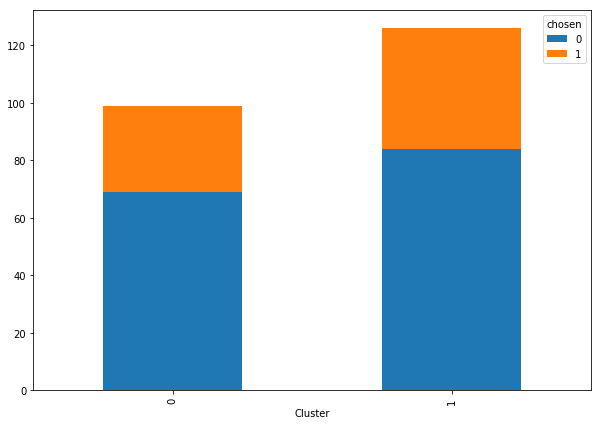

In [185]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

# Tonal Centroid

In [310]:
df_n_ps_std[0].columns

Index(['durationfiles', 'rmsfiles', 'rmsmedianfiles', 'lowenergyfiles',
       'ASRfiles', 'beatspectrumfiles', 'eventdensityfiles', 'tempofiles',
       'pulseclarityfiles', 'zerocrossfiles', 'rolloffsfiles',
       'brightnessfiles', 'spreadfiles', 'centroidfiles', 'kurtosisfiles',
       'flatnessfiles', 'entropyfiles', 'mfccfiles_1', 'mfccfiles_2',
       'mfccfiles_3', 'mfccfiles_4', 'mfccfiles_5', 'mfccfiles_6',
       'mfccfiles_7', 'mfccfiles_8', 'mfccfiles_9', 'mfccfiles_10',
       'mfccfiles_11', 'mfccfiles_12', 'mfccfiles_13', 'inharmonicityfiles',
       'bestkeyfiles', 'keyclarityfiles', 'modalityfiles',
       'tonalcentroidfiles_1', 'tonalcentroidfiles_2', 'tonalcentroidfiles_3',
       'tonalcentroidfiles_4', 'tonalcentroidfiles_5', 'tonalcentroidfiles_6',
       'chromagramfiles_1', 'chromagramfiles_2', 'chromagramfiles_3',
       'chromagramfiles_4', 'chromagramfiles_5', 'chromagramfiles_6',
       'chromagramfiles_7', 'chromagramfiles_8', 'chromagramfiles_9',
      

In [311]:
df_n_ps_std[0].columns[34:40]

Index(['tonalcentroidfiles_1', 'tonalcentroidfiles_2', 'tonalcentroidfiles_3',
       'tonalcentroidfiles_4', 'tonalcentroidfiles_5', 'tonalcentroidfiles_6'],
      dtype='object')

In [312]:
df_n_ps_std_tc = [None]*len(companies)
for i in range(len(companies)):
    df_n_ps_std_tc[i] = pd.DataFrame(df_n_ps_std[i].iloc[:,34:40])
    df_n_ps_std_tc[i].columns=df_n_ps_std[i].columns[34:40]
df_n_ps_std_tc[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 6 columns):
tonalcentroidfiles_1    372 non-null float64
tonalcentroidfiles_2    372 non-null float64
tonalcentroidfiles_3    372 non-null float64
tonalcentroidfiles_4    372 non-null float64
tonalcentroidfiles_5    372 non-null float64
tonalcentroidfiles_6    372 non-null float64
dtypes: float64(6)
memory usage: 17.5 KB


## Arte Francés

### ANN

In [313]:
X = df_n_ps_std_tc[0]

In [314]:
y = df_n_ps[0]['chosen']

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [316]:
X_train.shape

(279, 6)

In [193]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [194]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [195]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [196]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (30, 30, 30), 'learning_rate_init': 0.02, 'max_iter': 2000}, que permiten obtener un Accuracy de 78.85% y un Kappa del 15.23
Tiempo total: 15.53 minutos


In [317]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,30,30]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.02
epochs = 2000

In [318]:
input_tensor = Input(shape = (n0,))

In [319]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [320]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [321]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_49 (Dense)             (None, 30)                210       
_________________________________________________________________
dense_50 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_51 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 31        
Total params: 2,101
Trainable params: 2,101
Non-trainable params: 0
_________________________________________________________________


In [322]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 279 samples, validate on 93 samples
Epoch 1/2000
279/279 [==============================] - 0s 795us/step - loss: 0.6163 - accuracy: 0.6810 - val_loss: 0.6134 - val_accuracy: 0.7312
Epoch 2/2000
279/279 [==============================] - 0s 57us/step - loss: 0.5435 - accuracy: 0.7778 - val_loss: 0.6137 - val_accuracy: 0.7204
Epoch 3/2000
279/279 [==============================] - 0s 54us/step - loss: 0.5501 - accuracy: 0.7742 - val_loss: 0.6025 - val_accuracy: 0.7312
Epoch 4/2000
279/279 [==============================] - 0s 61us/step - loss: 0.5280 - accuracy: 0.7814 - val_loss: 0.5825 - val_accuracy: 0.7419
Epoch 5/2000
279/279 [==============================] - 0s 54us/step - loss: 0.5163 - accuracy: 0.7670 - val_loss: 0.5768 - val_accuracy: 0.7312
Epoch 6/2000
279/279 [==============================] - 0s 57us/step - loss: 0.4872 - accuracy: 0.7849 - val_loss: 0.5917 - val_accuracy: 0.7312
Epoch 7/2000
279/279 [==============================] - 0s 75us/step - loss: 0.4670 

279/279 [==============================] - 0s 61us/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 1.3377 - val_accuracy: 0.6989

Epoch 00054: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 55/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 1.3390 - val_accuracy: 0.6989
Epoch 56/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0283 - accuracy: 1.0000 - val_loss: 1.3404 - val_accuracy: 0.6989
Epoch 57/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0279 - accuracy: 1.0000 - val_loss: 1.3436 - val_accuracy: 0.6989
Epoch 58/2000
279/279 [==============================] - 0s 111us/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 1.3453 - val_accuracy: 0.6989
Epoch 59/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 1.3486 - val_accuracy: 0.6989
Epoch 60/2000
279/279 [==============================] -

279/279 [==============================] - 0s 61us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4033 - val_accuracy: 0.6989
Epoch 107/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4035 - val_accuracy: 0.6989
Epoch 108/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4036 - val_accuracy: 0.6989
Epoch 109/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4038 - val_accuracy: 0.6989
Epoch 110/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4038 - val_accuracy: 0.6989
Epoch 111/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4039 - val_accuracy: 0.6989
Epoch 112/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0224 - accuracy: 1.0000 - val_loss: 1.4041 - val_acc

279/279 [==============================] - 0s 72us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 160/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 161/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 162/2000
279/279 [==============================] - 0s 54us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 163/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 164/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00164: ReduceLROnPlateau reducing learning rate to 3.0517577442878974e-07.
Epoch 165/2000
279/279 [===========================

279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 212/2000
279/279 [==============================] - 0s 54us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 213/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 214/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00214: ReduceLROnPlateau reducing learning rate to 9.53674295089968e-09.
Epoch 215/2000
279/279 [==============================] - 0s 72us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 216/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 217/2000
279/279 [=============================

279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00264: ReduceLROnPlateau reducing learning rate to 2.98023217215615e-10.
Epoch 265/2000
279/279 [==============================] - 0s 72us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 266/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 267/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 268/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 269/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 270/2000
279/279 [=============================

279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 317/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 318/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 319/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 320/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 321/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 322/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_acc

279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 370/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 371/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 372/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 373/2000
279/279 [==============================] - 0s 68us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 374/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00374: ReduceLROnPlateau reducing learning rate to 1.45519149031062e-13.
Epoch 375/2000
279/279 [=============================

279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 423/2000
279/279 [==============================] - ETA: 0s - loss: 0.0257 - accuracy: 1.00 - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 424/2000
279/279 [==============================] - 0s 64us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00424: ReduceLROnPlateau reducing learning rate to 4.5474734072206875e-15.
Epoch 425/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 426/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 427/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 428


Epoch 00474: ReduceLROnPlateau reducing learning rate to 1.4210854397564648e-16.
Epoch 475/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 476/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 477/2000
279/279 [==============================] - 0s 68us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 478/2000
279/279 [==============================] - 0s 72us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 479/2000
279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 480/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 481/2000
279/279 [===========

279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 528/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 529/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 530/2000
279/279 [==============================] - 0s 72us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 531/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 532/2000
279/279 [==============================] - 0s 57us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 533/2000
279/279 [==============================] - 0s 61us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_acc

279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 581/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 582/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 583/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 584/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00584: ReduceLROnPlateau reducing learning rate to 6.938893748810864e-20.
Epoch 585/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 586/2000
279/279 [===========================

279/279 [==============================] - 0s 111us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 634/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00634: ReduceLROnPlateau reducing learning rate to 2.168404296503395e-21.
Epoch 635/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 636/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 637/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 638/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 639/2000
279/279 [========================

279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 686/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 687/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 688/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 689/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 690/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 691/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_acc

279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 739/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 740/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 741/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 742/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 743/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 744/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_acc

279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 792/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 793/2000
279/279 [==============================] - 0s 111us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 794/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00794: ReduceLROnPlateau reducing learning rate to 3.308722376256401e-26.
Epoch 795/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 796/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 797/2000
279/279 [==========================

Epoch 844/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00844: ReduceLROnPlateau reducing learning rate to 1.0339757425801253e-27.
Epoch 845/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 846/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 847/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 848/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 849/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 850/2000
279/279 [============

279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 897/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 898/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 899/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 900/2000
279/279 [==============================] - 0s 115us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 901/2000
279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 902/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_a

Epoch 949/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 950/2000
279/279 [==============================] - 0s 111us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 951/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 952/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 953/2000
279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 954/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 00954: ReduceLROnPlateau reducing learning rate to 5.048709680567018e-31.
Epoch 955/2000
279/279 [========

Epoch 1002/2000
279/279 [==============================] - 0s 115us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1003/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1004/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 01004: ReduceLROnPlateau reducing learning rate to 1.577721775177193e-32.
Epoch 1005/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1006/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1007/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1008/2000
279/279 [===

279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 01054: ReduceLROnPlateau reducing learning rate to 4.930380547428728e-34.
Epoch 1055/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1056/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1057/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1058/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1059/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1060/2000
279/279 [======================

Epoch 1106/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1107/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1108/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1109/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1110/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1111/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1112/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - va

279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1159/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1160/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1161/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1162/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1163/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1164/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - v

279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1211/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1212/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1213/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1214/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 01214: ReduceLROnPlateau reducing learning rate to 7.523163677106824e-39.
Epoch 1215/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1216/2000
279/279 [======================

279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1263/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1264/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 01264: ReduceLROnPlateau reducing learning rate to 2.350986459567032e-40.
Epoch 1265/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1266/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1267/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1268/2000
279/279 [=====================


Epoch 01314: ReduceLROnPlateau reducing learning rate to 7.347007848455016e-42.
Epoch 1315/2000
279/279 [==============================] - 0s 111us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1316/2000
279/279 [==============================] - 0s 122us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1317/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1318/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1319/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1320/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1321/2000
279/279 [===

279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1368/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1369/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1370/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1371/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1372/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1373/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 -

Epoch 1420/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1421/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1422/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1423/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1424/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989

Epoch 01424: ReduceLROnPlateau reducing learning rate to 3.5032461608120427e-45.
Epoch 1425/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1426/2000
279/279 [=====

279/279 [==============================] - 0s 136us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1474/2000
279/279 [==============================] - 0s 136us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1475/2000
279/279 [==============================] - 0s 115us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1476/2000
279/279 [==============================] - 0s 111us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1477/2000
279/279 [==============================] - 0s 125us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1478/2000
279/279 [==============================] - 0s 115us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1479/2000
279/279 [==============================] - 0s 122us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4

279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1529/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1530/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1531/2000
279/279 [==============================] - 0s 115us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1532/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1533/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1534/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.405

279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1584/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1585/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1586/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1587/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1588/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1589/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 -

279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1639/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1640/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1641/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1642/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1643/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1644/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - v

279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1694/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1695/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1696/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1697/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1698/2000
279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1699/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - 

279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1749/2000
279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1750/2000
279/279 [==============================] - 0s 100us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1751/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1752/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1753/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1754/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058

279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1804/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1805/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1806/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1807/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1808/2000
279/279 [==============================] - 0s 75us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1809/2000
279/279 [==============================] - 0s 90us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - v

279/279 [==============================] - 0s 97us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1859/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1860/2000
279/279 [==============================] - 0s 118us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1861/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1862/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1863/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1864/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 -

279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1914/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1915/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1916/2000
279/279 [==============================] - 0s 79us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1917/2000
279/279 [==============================] - 0s 93us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1918/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1919/2000
279/279 [==============================] - 0s 86us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - v

279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1969/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1970/2000
279/279 [==============================] - 0s 129us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1971/2000
279/279 [==============================] - 0s 125us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1972/2000
279/279 [==============================] - 0s 107us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1973/2000
279/279 [==============================] - 0s 82us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058 - val_accuracy: 0.6989
Epoch 1974/2000
279/279 [==============================] - 0s 104us/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.4058

range(0, 2000)


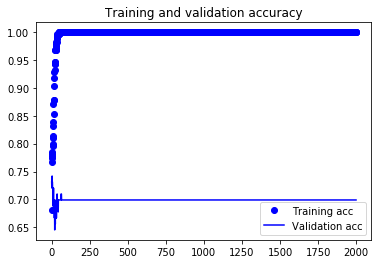

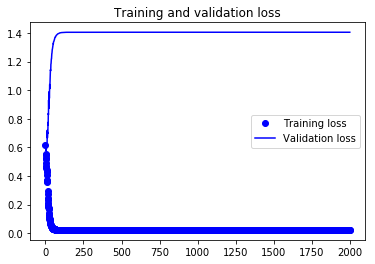

In [323]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [324]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

93/93 [==============================] - 0s 43us/step
test loss: 1.405830939610799, test accuracy: 0.698924720287323


In [325]:
y_pred = model.predict(X_test)
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

Kappa:  0.1712285168682367
AUC ROC:  0.5791176470588235


### KMeans

In [216]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.574572              0.885785             -0.744040   
1                1.110821              0.925768              0.226451   
2               -0.106107              1.808295              1.961049   
3                0.083078              1.385239              1.506771   
4               -0.164331              0.169248              0.525026   
5               -0.601767              0.100025              2.894764   
6               -0.436923             -0.300019              1.146480   
7               -0.587280              1.210009              0.829948   
8               -0.072320              0.439239             -0.084262   
9                0.177494              0.386052              0.266785   
10               0.473878              0.893926             -0.138418   
11               0.245249              0.482974              0.995106   
12               0.011981             -0.373717             -0.589054   
13               0.190041             -0.273603              0.483229   
14              -1.064192             -0.043564             -1.313412   
15              -0.197842              0.773898              0.917595   
16              -0.610344              0.615674              0.638901   
17               0.804488             -1.479012              0.374228   
18               0.490692             -1.982800             -0.516405   
19               0.592053             -1.492906              0.420008   
20              -1.787738              1.285484             -0.785859   
21              -1.742165             -0.033766             -0.693835   
22              -1.729041              0.173705             -1.150118   
23               0.437142              1.722799             -2.129021   
24               1.350380              0.970678              0.076009   
25               0.496482             -0.133100             -0.887460   
26               0.364827              1.228853             -0.931602   
27               1.022426              1.569202             -1.345165   
28               0.458228              1.620487             -0.211045   
29               0.607951              1.683390             -0.591685   
..                    ...                   ...                   ...   
342              0.736233             -1.887137              0.319724   
343              2.234360             -0.046651              1.657368   
344              0.911113              0.039319             -1.297534   
345              1.384636             -0.476054             -1.183101   
346              0.961181              0.071015             -0.810140   
347              0.937051             -1.450311             -0.319702   
348             -3.281761              0.179415             -1.446642   
349             -2.344820              0.180118              0.106773   
350              1.460135              0.906456             -0.147713   
351              2.114961              0.965145             -1.378351   
352              1.504768              0.846661             -1.860231   
353             -0.213580              0.437840              0.427356   
354             -0.063245              0.024794              0.060996   
355              0.116032              0.004823              0.235041   
356             -0.330558              0.187426             -0.234587   
357              0.380368              0.608654             -0.308912   
358              0.893056              0.389669             -0.426997   
359             -1.019517             -2.497618              0.166376   
360             -0.784247             -1.148191             -0.802374   
361              0.139494             -2.036594             -1.137199   
362              1.494839             -2.022204             -0.164524   
363              3.128156             -1.231830              0.035160   
364              2.010326             -1.482568             -1.

In [217]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2232.0,
 1860.320016741722,
 1609.923817414493,
 1413.3293251834796,
 1299.2594621943642,
 1187.9595776711437,
 1107.911820622218,
 1042.5800837127117,
 995.2457858732439,
 962.2198115266042,
 937.080734625301,
 898.72618782214,
 866.9993526105154,
 833.7799456003584]

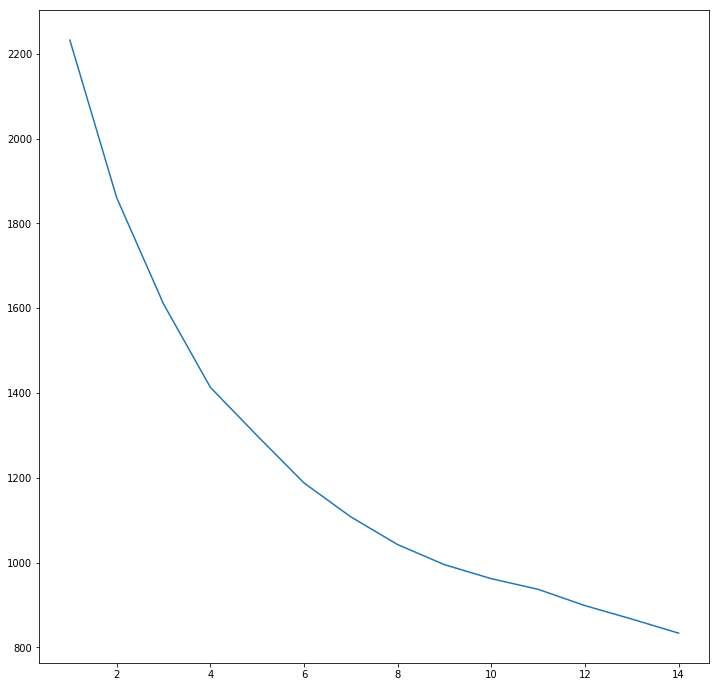

In [218]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=4

In [219]:
kmeans_tc = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [220]:
kmeans_tc.labels_

array([2, 2, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3,
       1, 3, 2, 2, 2, 2, 3, 2, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 3,
       3, 3, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 2, 3, 1, 3, 1, 3, 3,
       0, 0, 0, 3, 3, 3, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0,
       2, 1, 0, 3, 2, 1, 1, 2, 0, 3, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 2, 2, 2, 0, 3, 2, 0, 3, 2, 3, 1, 1, 1, 0, 2, 0,
       3, 3, 3, 3, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 3, 0, 2,
       0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 3, 2, 3, 0, 1, 1, 2,
       0, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1,
       2, 1, 1, 3, 0, 1, 2, 3, 2, 2, 3, 2, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1,
       2, 3, 3, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 0, 0, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3,
       2, 1, 1, 1, 3, 3, 1, 1, 1, 2, 2, 1, 3, 2, 0, 2, 2, 3, 3, 3, 3, 1,
       0, 2, 2, 3, 2, 0, 3, 1, 3, 2, 1, 0, 0, 3, 0,

In [221]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([2, 2, 0, 0, 0, 0, 1, 0, 0, 3, 2, 0, 1, 1, 3, 3, 3, 1, 1, 1, 3, 3,
       1, 3, 2, 2, 2, 2, 3, 2, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 0, 0, 0, 3,
       3, 3, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 2, 2, 3, 1, 3, 1, 3, 3,
       0, 0, 0, 3, 3, 3, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 3, 3, 0, 0,
       2, 1, 0, 3, 2, 1, 1, 2, 0, 3, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 2, 2, 2, 0, 3, 2, 0, 3, 2, 3, 1, 1, 1, 0, 2, 0,
       3, 3, 3, 3, 1, 2, 0, 1, 0, 1, 1, 2, 1, 0, 1, 1, 0, 0, 0, 3, 0, 2,
       0, 0, 0, 1, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 1, 3, 2, 3, 0, 1, 1, 2,
       0, 1, 1, 1, 1, 2, 1, 2, 2, 3, 3, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1,
       2, 1, 1, 3, 0, 1, 2, 3, 2, 2, 3, 2, 0, 2, 2, 1, 0, 1, 0, 1, 2, 1,
       2, 3, 3, 3, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 3, 2, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 0, 0, 2, 2, 2, 1, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3,
       2, 1, 1, 1, 3, 3, 1, 1, 1, 2, 2, 1, 3, 2, 0, 2, 2, 3, 3, 3, 3, 1,
       0, 2, 2, 3, 2, 0, 3, 1, 3, 2, 1, 0, 0, 3, 0,

In [222]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [223]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.574572              0.885785             -0.744040   
1                1.110821              0.925768              0.226451   
2               -0.106107              1.808295              1.961049   
3                0.083078              1.385239              1.506771   
4               -0.164331              0.169248              0.525026   
5               -0.601767              0.100025              2.894764   
6               -0.436923             -0.300019              1.146480   
7               -0.587280              1.210009              0.829948   
8               -0.072320              0.439239             -0.084262   
9                0.177494              0.386052              0.266785   
10               0.473878              0.893926             -0.138418   
11               0.245249              0.482974              0.995106   
12               0.011981             -0.373717             -0.589054   
13               0.190041             -0.273603              0.483229   
14              -1.064192             -0.043564             -1.313412   
15              -0.197842              0.773898              0.917595   
16              -0.610344              0.615674              0.638901   
17               0.804488             -1.479012              0.374228   
18               0.490692             -1.982800             -0.516405   
19               0.592053             -1.492906              0.420008   
20              -1.787738              1.285484             -0.785859   
21              -1.742165             -0.033766             -0.693835   
22              -1.729041              0.173705             -1.150118   
23               0.437142              1.722799             -2.129021   
24               1.350380              0.970678              0.076009   
25               0.496482             -0.133100             -0.887460   
26               0.364827              1.228853             -0.931602   
27               1.022426              1.569202             -1.345165   
28               0.458228              1.620487             -0.211045   
29               0.607951              1.683390             -0.591685   
..                    ...                   ...                   ...   
342              0.736233             -1.887137              0.319724   
343              2.234360             -0.046651              1.657368   
344              0.911113              0.039319             -1.297534   
345              1.384636             -0.476054             -1.183101   
346              0.961181              0.071015             -0.810140   
347              0.937051             -1.450311             -0.319702   
348             -3.281761              0.179415             -1.446642   
349             -2.344820              0.180118              0.106773   
350              1.460135              0.906456             -0.147713   
351              2.114961              0.965145             -1.378351   
352              1.504768              0.846661             -1.860231   
353             -0.213580              0.437840              0.427356   
354             -0.063245              0.024794              0.060996   
355              0.116032              0.004823              0.235041   
356             -0.330558              0.187426             -0.234587   
357              0.380368              0.608654             -0.308912   
358              0.893056              0.389669             -0.426997   
359             -1.019517             -2.497618              0.166376   
360             -0.784247             -1.148191             -0.802374   
361              0.139494             -2.036594             -1.137199   
362              1.494839             -2.022204             -0.164524   
363              3.128156             -1.231830              0.035160   
364              2.010326             -1.482568             -1.

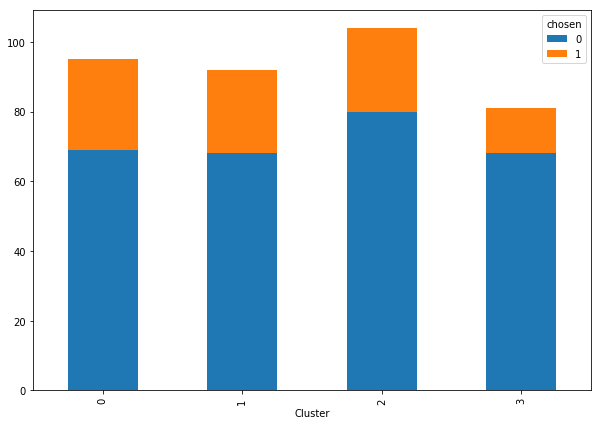

In [224]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [326]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[1]))

## Club De Banqueros y Empresarios

### ANN

In [327]:
X = df_n_ps_std_tc[1]

In [328]:
y = df_n_ps[1]['chosen']

In [329]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [330]:
X_train.shape

(191, 6)

In [229]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [230]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [231]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [232]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.004, 'max_iter': 400}, que permiten obtener un Accuracy de 77.49% y un Kappa del 29.13
Tiempo total: 27.26 minutos


In [331]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.004
epochs = 400

In [332]:
input_tensor = Input(shape = (n0,))

In [333]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [334]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [335]:
model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_53 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [336]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 191 samples, validate on 64 samples
Epoch 1/400
191/191 [==============================] - 0s 691us/step - loss: 0.7329 - accuracy: 0.4346 - val_loss: 0.6526 - val_accuracy: 0.6250
Epoch 2/400
191/191 [==============================] - 0s 63us/step - loss: 0.6918 - accuracy: 0.5340 - val_loss: 0.6515 - val_accuracy: 0.6250
Epoch 3/400
191/191 [==============================] - 0s 52us/step - loss: 0.6588 - accuracy: 0.6754 - val_loss: 0.6536 - val_accuracy: 0.6406
Epoch 4/400
191/191 [==============================] - 0s 58us/step - loss: 0.6310 - accuracy: 0.7225 - val_loss: 0.6568 - val_accuracy: 0.6406
Epoch 5/400
191/191 [==============================] - 0s 52us/step - loss: 0.6102 - accuracy: 0.7277 - val_loss: 0.6612 - val_accuracy: 0.6094
Epoch 6/400
191/191 [==============================] - 0s 58us/step - loss: 0.5927 - accuracy: 0.7435 - val_loss: 0.6655 - val_accuracy: 0.6094
Epoch 7/400
191/191 [==============================] - 0s 52us/step - loss: 0.5802 - accur

191/191 [==============================] - 0s 58us/step - loss: 0.5069 - accuracy: 0.7487 - val_loss: 0.6851 - val_accuracy: 0.6719
Epoch 56/400
191/191 [==============================] - 0s 58us/step - loss: 0.5067 - accuracy: 0.7487 - val_loss: 0.6848 - val_accuracy: 0.6719
Epoch 57/400
191/191 [==============================] - 0s 52us/step - loss: 0.5066 - accuracy: 0.7487 - val_loss: 0.6848 - val_accuracy: 0.6719

Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 58/400
191/191 [==============================] - 0s 73us/step - loss: 0.5064 - accuracy: 0.7487 - val_loss: 0.6848 - val_accuracy: 0.6719
Epoch 59/400
191/191 [==============================] - 0s 73us/step - loss: 0.5063 - accuracy: 0.7487 - val_loss: 0.6848 - val_accuracy: 0.6719
Epoch 60/400
191/191 [==============================] - 0s 68us/step - loss: 0.5063 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 61/400
191/191 [==============================] - 0s 58u

191/191 [==============================] - 0s 78us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 109/400
191/191 [==============================] - 0s 63us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 110/400
191/191 [==============================] - 0s 52us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 111/400
191/191 [==============================] - 0s 84us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 112/400
191/191 [==============================] - 0s 63us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 113/400
191/191 [==============================] - 0s 63us/step - loss: 0.5050 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 114/400
191/191 [==============================] - 0s 58us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy:

191/191 [==============================] - 0s 78us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 162/400
191/191 [==============================] - 0s 78us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 163/400
191/191 [==============================] - 0s 78us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 164/400
191/191 [==============================] - 0s 94us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 165/400
191/191 [==============================] - 0s 78us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 166/400
191/191 [==============================] - 0s 99us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 167/400
191/191 [==============================] - 0s 84us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy:

191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 215/400
191/191 [==============================] - 0s 84us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 216/400
191/191 [==============================] - 0s 84us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 217/400
191/191 [==============================] - 0s 84us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719

Epoch 00217: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 218/400
191/191 [==============================] - 0s 78us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 219/400
191/191 [==============================] - 0s 68us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 220/400
191/191 [==============================] - 

191/191 [==============================] - 0s 58us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719

Epoch 00267: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.
Epoch 268/400
191/191 [==============================] - 0s 58us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 269/400
191/191 [==============================] - 0s 58us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 270/400
191/191 [==============================] - 0s 58us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 271/400
191/191 [==============================] - 0s 63us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 272/400
191/191 [==============================] - 0s 63us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 273/400
191/191 [==============================] -

Epoch 320/400
191/191 [==============================] - 0s 99us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 321/400
191/191 [==============================] - 0s 94us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 322/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 323/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 324/400
191/191 [==============================] - 0s 94us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 325/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 326/400
191/191 [==============================] - 0s 99us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 -

191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 374/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 375/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 376/400
191/191 [==============================] - 0s 84us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 377/400
191/191 [==============================] - 0s 89us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719

Epoch 00377: ReduceLROnPlateau reducing learning rate to 5.820766367818295e-14.
Epoch 378/400
191/191 [==============================] - 0s 94us/step - loss: 0.5049 - accuracy: 0.7487 - val_loss: 0.6847 - val_accuracy: 0.6719
Epoch 379/400
191/191 [==============================] - 

range(0, 400)


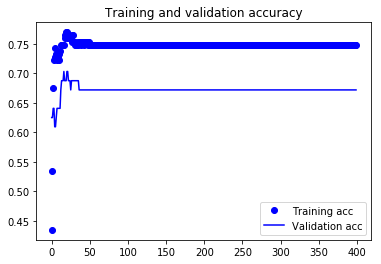

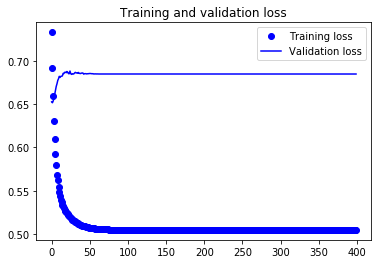

In [337]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [338]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

64/64 [==============================] - 0s 47us/step
test loss: 0.6846858859062195, test accuracy: 0.671875


In [339]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.4842105263157894


In [340]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.08943089430894313


### KMeans

In [243]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                0.898091              0.151819             -1.172713   
1                0.618513             -0.762588              0.061946   
2                0.685649              0.002933              0.719805   
3                1.175209             -0.552349              0.336427   
4                1.350337             -1.407757              0.258917   
5                0.907564             -1.769301              1.177857   
6               -0.071420             -0.800769              0.238726   
7                0.476433             -1.202140             -1.713665   
8                0.572039             -1.488738             -0.403914   
9                0.741137              0.139987              0.726307   
10               0.533655             -0.111619              0.435253   
11              -0.667308              0.502566             -1.137726   
12               0.161812              0.294263              0.659166   
13              -0.373777             -1.439681              0.009190   
14               0.745550              0.214669              0.209787   
15               0.320726              0.108060              0.208510   
16               0.646392             -0.726119              0.153724   
17              -0.042981             -0.672256              0.358250   
18               0.822192              0.184879              1.658679   
19               0.175070              0.195153              1.969940   
20               1.339692             -1.202498              0.487937   
21               1.290923             -0.546138              0.120024   
22               1.528224             -0.912727              0.962682   
23              -0.486779             -1.124424              0.559106   
24              -0.230729              0.999926             -0.678209   
25              -0.632681              0.618852             -0.778803   
26              -1.151505             -1.127449              1.500641   
27               0.265739             -3.078847             -0.939567   
28               0.623357             -1.241561             -1.149654   
29               0.930863             -1.763587             -1.608926   
..                    ...                   ...                   ...   
225             -1.444140             -0.088370             -0.458428   
226             -0.297006              0.887935              0.467148   
227             -1.624166              0.777486              0.635044   
228              0.230618              1.438780              0.301556   
229             -0.163123              1.329205              0.721279   
230             -1.337576              0.249897              0.081067   
231              0.304553              0.584052              0.915910   
232             -0.291785              0.247731             -0.740382   
233             -0.532056              1.686101              0.358185   
234             -1.223692              0.723005              0.599197   
235              1.412552             -0.817418              0.038464   
236              0.141392             -0.756740             -1.981390   
237              1.157567             -0.442417             -1.342532   
238             -1.683225             -0.036571              0.297162   
239             -0.997159              0.655257              2.239993   
240             -1.142741              0.931927              1.440876   
241             -0.151675             -0.971306              0.447819   
242             -0.837654             -1.170592              0.622658   
243             -0.059101             -0.857751              0.253657   
244              1.455210             -1.123798              1.124970   
245              1.459407             -1.071308             -0.261053   
246              1.850117             -1.364586              1.015519   
247              0.468703              0.776904             -1.

In [244]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[1530.0000000000002,
 1266.8988304034983,
 1085.4171102625123,
 963.5827926636907,
 872.5239995069635,
 797.6140851961846,
 747.1323294070899,
 703.670300371115,
 664.3614627122823,
 637.5590430281768,
 607.7011770650902,
 585.4389967082509,
 558.8506960652073,
 540.5660329891642]

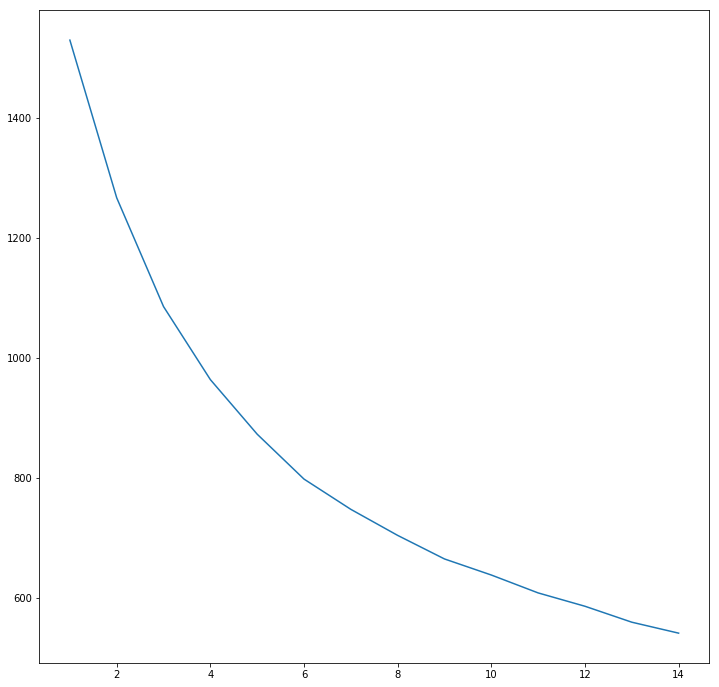

In [245]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [248]:
kmeans_tc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [249]:
kmeans_tc.labels_

array([2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 1,
       1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0,
       2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1])

In [250]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([2, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0,
       0, 2, 2, 0, 1, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0,
       1, 1, 1, 1, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1,
       1, 1, 2, 2, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 2, 1, 1,
       1, 0, 1, 2, 0, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1, 0, 2, 1, 0, 0,
       2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 1, 1,
       1, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 2,
       1, 2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 2, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2,
       2, 2, 1, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 1, 1, 1, 0,
       0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1])

In [251]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [252]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                0.898091              0.151819             -1.172713   
1                0.618513             -0.762588              0.061946   
2                0.685649              0.002933              0.719805   
3                1.175209             -0.552349              0.336427   
4                1.350337             -1.407757              0.258917   
5                0.907564             -1.769301              1.177857   
6               -0.071420             -0.800769              0.238726   
7                0.476433             -1.202140             -1.713665   
8                0.572039             -1.488738             -0.403914   
9                0.741137              0.139987              0.726307   
10               0.533655             -0.111619              0.435253   
11              -0.667308              0.502566             -1.137726   
12               0.161812              0.294263              0.659166   
13              -0.373777             -1.439681              0.009190   
14               0.745550              0.214669              0.209787   
15               0.320726              0.108060              0.208510   
16               0.646392             -0.726119              0.153724   
17              -0.042981             -0.672256              0.358250   
18               0.822192              0.184879              1.658679   
19               0.175070              0.195153              1.969940   
20               1.339692             -1.202498              0.487937   
21               1.290923             -0.546138              0.120024   
22               1.528224             -0.912727              0.962682   
23              -0.486779             -1.124424              0.559106   
24              -0.230729              0.999926             -0.678209   
25              -0.632681              0.618852             -0.778803   
26              -1.151505             -1.127449              1.500641   
27               0.265739             -3.078847             -0.939567   
28               0.623357             -1.241561             -1.149654   
29               0.930863             -1.763587             -1.608926   
..                    ...                   ...                   ...   
225             -1.444140             -0.088370             -0.458428   
226             -0.297006              0.887935              0.467148   
227             -1.624166              0.777486              0.635044   
228              0.230618              1.438780              0.301556   
229             -0.163123              1.329205              0.721279   
230             -1.337576              0.249897              0.081067   
231              0.304553              0.584052              0.915910   
232             -0.291785              0.247731             -0.740382   
233             -0.532056              1.686101              0.358185   
234             -1.223692              0.723005              0.599197   
235              1.412552             -0.817418              0.038464   
236              0.141392             -0.756740             -1.981390   
237              1.157567             -0.442417             -1.342532   
238             -1.683225             -0.036571              0.297162   
239             -0.997159              0.655257              2.239993   
240             -1.142741              0.931927              1.440876   
241             -0.151675             -0.971306              0.447819   
242             -0.837654             -1.170592              0.622658   
243             -0.059101             -0.857751              0.253657   
244              1.455210             -1.123798              1.124970   
245              1.459407             -1.071308             -0.261053   
246              1.850117             -1.364586              1.015519   
247              0.468703              0.776904             -1.

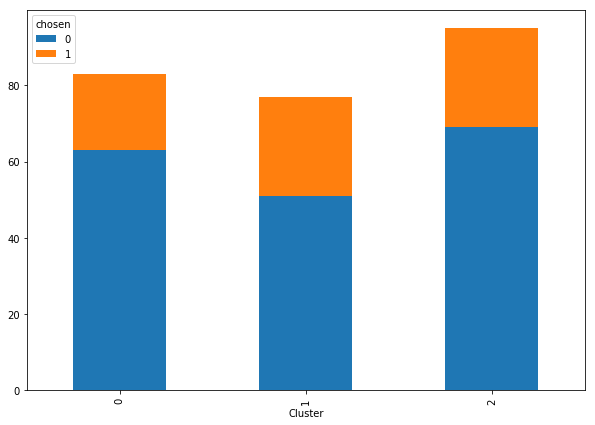

In [253]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [75]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[2]))

## Gramma

### ANN

In [341]:
X = df_n_ps_std_tc[2]

In [342]:
y = df_n_ps[2]['chosen']

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [344]:
X_train.shape

(231, 6)

In [260]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [261]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [262]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [263]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'logistic', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'max_iter': 10}, que permiten obtener un Accuracy de 81.82% y un Kappa del 6.27
Tiempo total: 28.04 minutos


In [345]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.01
epochs = 10

In [346]:
input_tensor = Input(shape = (n0,))

In [347]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [348]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [349]:
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                70        
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 11        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [350]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 231 samples, validate on 78 samples
Epoch 1/10
231/231 [==============================] - 0s 632us/step - loss: 0.7179 - accuracy: 0.5281 - val_loss: 0.6663 - val_accuracy: 0.6026
Epoch 2/10
231/231 [==============================] - 0s 52us/step - loss: 0.6066 - accuracy: 0.7013 - val_loss: 0.6283 - val_accuracy: 0.6667
Epoch 3/10
231/231 [==============================] - 0s 56us/step - loss: 0.5464 - accuracy: 0.7576 - val_loss: 0.6155 - val_accuracy: 0.6538
Epoch 4/10
231/231 [==============================] - 0s 56us/step - loss: 0.5144 - accuracy: 0.7706 - val_loss: 0.5962 - val_accuracy: 0.7308
Epoch 5/10
231/231 [==============================] - 0s 56us/step - loss: 0.4943 - accuracy: 0.8009 - val_loss: 0.5916 - val_accuracy: 0.7436
Epoch 6/10
231/231 [==============================] - 0s 56us/step - loss: 0.4849 - accuracy: 0.8095 - val_loss: 0.5781 - val_accuracy: 0.7436
Epoch 7/10
231/231 [==============================] - 0s 56us/step - loss: 0.4773 - accuracy: 0.

range(0, 10)


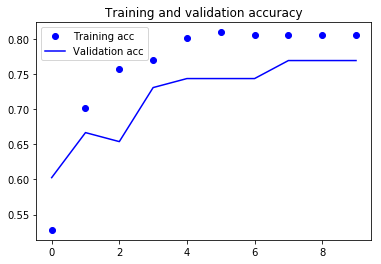

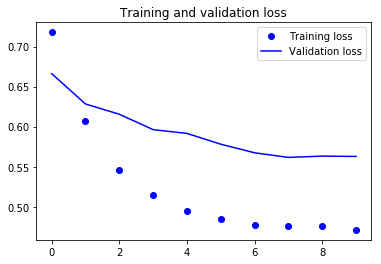

In [351]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [352]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

78/78 [==============================] - 0s 51us/step
test loss: 0.5627795901053991, test accuracy: 0.7692307829856873


In [353]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.5194444444444444


In [354]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.05645161290322598


### KMeans

In [274]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                0.609365              0.535135              0.096066   
1               -0.157519             -1.311578             -0.486252   
2               -1.148976             -1.325889              0.573178   
3               -0.996141             -0.557658              0.998693   
4               -0.648977             -0.248473              0.461357   
5                0.642800             -1.165140             -1.792767   
6                0.443136             -0.482419             -1.016712   
7               -0.022060             -0.811084             -0.405764   
8                0.961630              1.407288              1.551164   
9                0.798279              1.109447             -0.137057   
10               0.685212              1.076167             -0.288224   
11               0.803628              1.560996              0.774426   
12               0.099890              1.445746             -1.453815   
13              -0.212854              1.286504              0.720036   
14              -1.537501             -0.213678             -1.834954   
15              -1.440013              0.872943             -0.809520   
16              -1.697309              0.606859             -1.747229   
17               1.508685              0.904715              2.767009   
18               0.675946              0.502807              1.115627   
19               1.299159              0.428687              1.764048   
20               0.769693             -0.740825              0.452717   
21               0.495856             -0.499875             -0.034482   
22               0.772290             -0.678641              0.547946   
23               0.137654              1.496537              0.060579   
24               0.347129              0.809472              0.948516   
25               0.029111              1.842864              0.123391   
26              -1.473729              0.531152              0.801294   
27              -0.484210              0.210847              1.009613   
28              -0.013618             -2.024383             -0.832429   
29              -1.746529              0.488857             -0.774537   
..                    ...                   ...                   ...   
279             -0.218279             -0.903841             -1.454712   
280              0.264235             -1.579208             -1.404331   
281             -0.895563              0.461466              0.497480   
282             -1.010758              0.423694              0.383226   
283             -1.300227              0.920815              0.844807   
284              1.450169              0.335733              1.585783   
285              1.913390              0.883060              1.899591   
286              1.444559              0.481538              1.742822   
287              1.470621             -0.218928             -0.057911   
288              1.040063             -0.416007              0.629628   
289              1.328762             -0.491263              0.742595   
290              0.397008              1.213991             -0.429044   
291              0.172503              0.897500             -0.272973   
292              0.661186              1.163101             -0.294020   
293             -0.773212             -0.895468              0.318110   
294             -0.370777             -1.414554             -1.094557   
295              0.138250             -1.936963              0.151220   
296              0.819776             -0.472427             -0.322556   
297              0.754438             -1.235411              0.322527   
298              1.007225             -0.846471             -0.431575   
299              0.218592             -0.968903             -0.899045   
300              0.664524             -0.896436             -1.249763   
301              0.711838             -1.301487             -0.

In [275]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[1854.0,
 1536.8736642821204,
 1324.7285075839484,
 1167.9156349888185,
 1059.6165149053068,
 950.057768838126,
 894.4360136638212,
 823.7421512103674,
 771.932101822877,
 716.3847905620515,
 681.7237006830833,
 653.1513609666642,
 638.9262100013641,
 609.9795957680683]

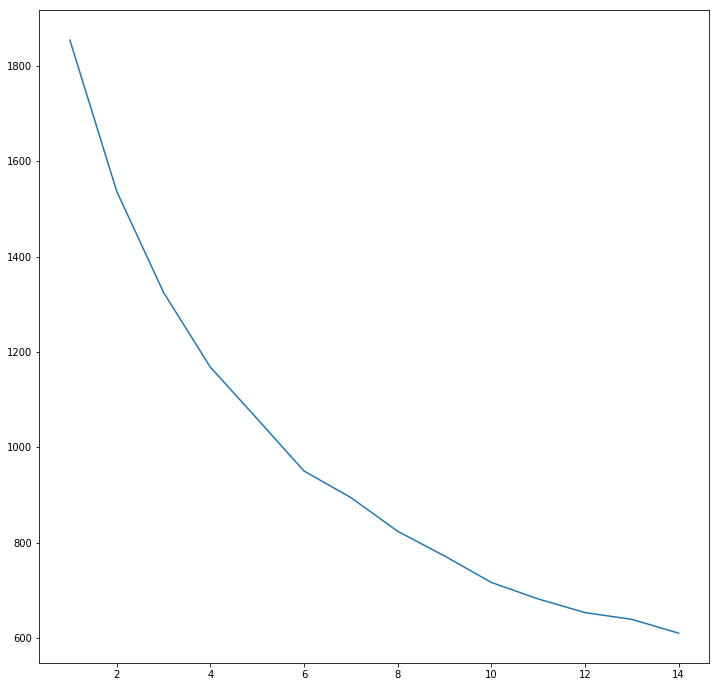

In [276]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=4

In [277]:
kmeans_tc = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [278]:
kmeans_tc.labels_

array([2, 1, 3, 1, 3, 2, 2, 2, 1, 2, 2, 3, 1, 0, 0, 0, 0, 3, 0, 1, 3, 2,
       3, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 3, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 3, 3, 3, 1, 1, 1, 0, 0, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 2,
       3, 1, 1, 1, 1, 3, 3, 3, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 3, 3,
       3, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 3, 0, 1, 1, 1, 3, 2, 0, 2,
       0, 3, 3, 3, 2, 0, 0, 1, 0, 0, 3, 3, 0, 1, 1, 0, 3, 3, 2, 0, 2, 0,
       0, 0, 3, 2, 1, 0, 0, 0, 3, 3, 1, 2, 3, 3, 0, 1, 0, 0, 3, 0, 1, 3,
       2, 0, 3, 1, 3, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 3,
       3, 2, 2, 2, 2, 2, 2, 3, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 3, 3, 1, 0,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 3, 3, 3, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1,
       1, 2, 2, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 0, 0, 1,
       1, 3, 3, 1, 2, 3, 2, 3, 1, 3, 2, 0, 1, 2, 2, 2, 0, 1, 0, 3, 2, 3,
       0, 0, 2, 0, 0, 0, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 2, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2,

In [279]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([2, 1, 3, 1, 3, 2, 2, 2, 1, 2, 2, 3, 1, 0, 0, 0, 0, 3, 0, 1, 3, 2,
       3, 0, 1, 0, 0, 1, 2, 0, 2, 2, 2, 1, 0, 2, 2, 3, 1, 1, 1, 2, 2, 2,
       2, 2, 1, 3, 3, 3, 1, 1, 1, 0, 0, 0, 2, 2, 3, 2, 0, 2, 0, 2, 2, 2,
       3, 1, 1, 1, 1, 3, 3, 3, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 1, 0, 3, 3,
       3, 2, 0, 1, 0, 2, 1, 1, 1, 1, 2, 2, 2, 3, 0, 1, 1, 1, 3, 2, 0, 2,
       0, 3, 3, 3, 2, 0, 0, 1, 0, 0, 3, 3, 0, 1, 1, 0, 3, 3, 2, 0, 2, 0,
       0, 0, 3, 2, 1, 0, 0, 0, 3, 3, 1, 2, 3, 3, 0, 1, 0, 0, 3, 0, 1, 3,
       2, 0, 3, 1, 3, 1, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 3,
       3, 2, 2, 2, 2, 2, 2, 3, 1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 3, 3, 1, 0,
       1, 0, 1, 2, 2, 2, 1, 0, 1, 3, 3, 3, 2, 2, 2, 0, 1, 1, 1, 0, 1, 1,
       1, 2, 2, 3, 1, 3, 3, 0, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 0, 0, 0, 1,
       1, 3, 3, 1, 2, 3, 2, 3, 1, 3, 2, 0, 1, 2, 2, 2, 0, 1, 0, 3, 2, 3,
       0, 0, 2, 0, 0, 0, 3, 2, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 2, 1, 2, 1, 2, 2, 2, 3, 2, 2, 2,

In [280]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [281]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                0.609365              0.535135              0.096066   
1               -0.157519             -1.311578             -0.486252   
2               -1.148976             -1.325889              0.573178   
3               -0.996141             -0.557658              0.998693   
4               -0.648977             -0.248473              0.461357   
5                0.642800             -1.165140             -1.792767   
6                0.443136             -0.482419             -1.016712   
7               -0.022060             -0.811084             -0.405764   
8                0.961630              1.407288              1.551164   
9                0.798279              1.109447             -0.137057   
10               0.685212              1.076167             -0.288224   
11               0.803628              1.560996              0.774426   
12               0.099890              1.445746             -1.453815   
13              -0.212854              1.286504              0.720036   
14              -1.537501             -0.213678             -1.834954   
15              -1.440013              0.872943             -0.809520   
16              -1.697309              0.606859             -1.747229   
17               1.508685              0.904715              2.767009   
18               0.675946              0.502807              1.115627   
19               1.299159              0.428687              1.764048   
20               0.769693             -0.740825              0.452717   
21               0.495856             -0.499875             -0.034482   
22               0.772290             -0.678641              0.547946   
23               0.137654              1.496537              0.060579   
24               0.347129              0.809472              0.948516   
25               0.029111              1.842864              0.123391   
26              -1.473729              0.531152              0.801294   
27              -0.484210              0.210847              1.009613   
28              -0.013618             -2.024383             -0.832429   
29              -1.746529              0.488857             -0.774537   
..                    ...                   ...                   ...   
279             -0.218279             -0.903841             -1.454712   
280              0.264235             -1.579208             -1.404331   
281             -0.895563              0.461466              0.497480   
282             -1.010758              0.423694              0.383226   
283             -1.300227              0.920815              0.844807   
284              1.450169              0.335733              1.585783   
285              1.913390              0.883060              1.899591   
286              1.444559              0.481538              1.742822   
287              1.470621             -0.218928             -0.057911   
288              1.040063             -0.416007              0.629628   
289              1.328762             -0.491263              0.742595   
290              0.397008              1.213991             -0.429044   
291              0.172503              0.897500             -0.272973   
292              0.661186              1.163101             -0.294020   
293             -0.773212             -0.895468              0.318110   
294             -0.370777             -1.414554             -1.094557   
295              0.138250             -1.936963              0.151220   
296              0.819776             -0.472427             -0.322556   
297              0.754438             -1.235411              0.322527   
298              1.007225             -0.846471             -0.431575   
299              0.218592             -0.968903             -0.899045   
300              0.664524             -0.896436             -1.249763   
301              0.711838             -1.301487             -0.

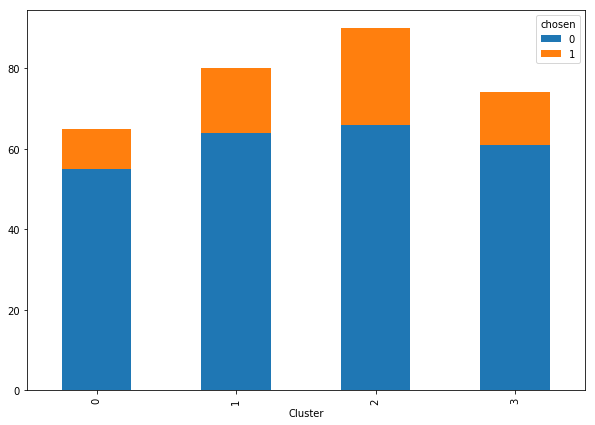

In [282]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [355]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[3]))

## Hotel Marrakech

### ANN

In [356]:
X = df_n_ps_std_tc[3]

In [357]:
y = df_n_ps[3]['chosen']

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [359]:
X_train.shape

(139, 6)

In [288]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [289]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [290]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [291]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.007, 'max_iter': 1000}, que permiten obtener un Accuracy de 80.58% y un Kappa del 50.08
Tiempo total: 22.27 minutos


In [360]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.007
epochs = 1000

In [361]:
input_tensor = Input(shape = (n0,))

In [362]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [363]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [364]:
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 30)                210       
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 31        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


In [365]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 139 samples, validate on 47 samples
Epoch 1/1000
139/139 [==============================] - 0s 1ms/step - loss: 0.6991 - accuracy: 0.5396 - val_loss: 0.6750 - val_accuracy: 0.6596
Epoch 2/1000
139/139 [==============================] - 0s 72us/step - loss: 0.6502 - accuracy: 0.6331 - val_loss: 0.6494 - val_accuracy: 0.6596
Epoch 3/1000
139/139 [==============================] - 0s 72us/step - loss: 0.6211 - accuracy: 0.6691 - val_loss: 0.6343 - val_accuracy: 0.6809
Epoch 4/1000
139/139 [==============================] - 0s 79us/step - loss: 0.6115 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6809
Epoch 5/1000
139/139 [==============================] - 0s 65us/step - loss: 0.6039 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 6/1000
139/139 [==============================] - 0s 72us/step - loss: 0.6032 - accuracy: 0.6835 - val_loss: 0.6279 - val_accuracy: 0.6383
Epoch 7/1000
139/139 [==============================] - 0s 72us/step - loss: 0.6017 - 

139/139 [==============================] - 0s 72us/step - loss: 0.5618 - accuracy: 0.6906 - val_loss: 0.6281 - val_accuracy: 0.6383
Epoch 55/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5617 - accuracy: 0.6906 - val_loss: 0.6281 - val_accuracy: 0.6383
Epoch 56/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5616 - accuracy: 0.6906 - val_loss: 0.6279 - val_accuracy: 0.6383
Epoch 57/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5616 - accuracy: 0.6906 - val_loss: 0.6277 - val_accuracy: 0.6383
Epoch 58/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5614 - accuracy: 0.6906 - val_loss: 0.6277 - val_accuracy: 0.6383
Epoch 59/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5613 - accuracy: 0.6906 - val_loss: 0.6278 - val_accuracy: 0.6383
Epoch 60/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5613 - accuracy: 0.6906 - val_loss: 0.6276 - val_accurac

Epoch 107/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 108/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 109/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 110/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 111/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 112/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 113/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5601 - accuracy: 0.6906 - val_loss: 0

Epoch 160/1000
139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 161/1000
139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 162/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 163/1000
139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00163: ReduceLROnPlateau reducing learning rate to 1.068115267344183e-07.
Epoch 164/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 165/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 166/1000
139/139 [=============

Epoch 213/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00213: ReduceLROnPlateau reducing learning rate to 3.3378602104505717e-09.
Epoch 214/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 215/1000
139/139 [==============================] - 0s 65us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 216/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 217/1000
139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 218/1000
139/139 [==============================] - 0s 72us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 219/1000
139/139 [===========

139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 266/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 267/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 268/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 269/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 270/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 271/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val

Epoch 318/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 319/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 320/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 321/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 322/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 323/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00323: ReduceLROnPlateau reducing learning rate to 1.6298145558840682e-12.
Epoch 324/1000
139/139 [=========

Epoch 371/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 372/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 373/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00373: ReduceLROnPlateau reducing learning rate to 5.093170487137713e-14.
Epoch 374/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 375/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 376/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 377/1000
139/139 [=============

139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00423: ReduceLROnPlateau reducing learning rate to 1.5916157772305354e-15.
Epoch 424/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 425/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 426/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 427/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 428/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 429/1000
139/139 [=======================

139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 476/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 477/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 478/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 479/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 480/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 481/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_ac

Epoch 528/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 529/1000
139/139 [==============================] - 0s 79us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 530/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 531/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 532/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 533/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00533: ReduceLROnPlateau reducing learning rate to 7.771561412258473e-19.
Epoch 534/1000
139/139 [=============

Epoch 581/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 582/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 583/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00583: ReduceLROnPlateau reducing learning rate to 2.428612941330773e-20.
Epoch 584/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 585/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 586/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 587/1000
139/139 [===========


Epoch 00633: ReduceLROnPlateau reducing learning rate to 7.589415441658665e-22.
Epoch 634/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 635/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 636/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 637/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 638/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 639/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 640/1000
139/139 [=============

139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 687/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 688/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 689/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 690/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 691/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 692/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val

Epoch 739/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 740/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 741/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 742/1000
139/139 [==============================] - 0s 129us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 743/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00743: ReduceLROnPlateau reducing learning rate to 3.7057692586223952e-25.
Epoch 744/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 745/1000
139/139 [======

139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 792/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 793/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00793: ReduceLROnPlateau reducing learning rate to 1.1580528933194985e-26.
Epoch 794/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 795/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 796/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 797/1000
139/139 [=====================


Epoch 00843: ReduceLROnPlateau reducing learning rate to 3.618915291623433e-28.
Epoch 844/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 845/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 846/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 847/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 848/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 849/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 850/1000
139/139 [=======

Epoch 896/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 897/1000
139/139 [==============================] - 0s 122us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 898/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 899/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 900/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 901/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 902/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_

Epoch 949/1000
139/139 [==============================] - 0s 115us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 950/1000
139/139 [==============================] - 0s 108us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 951/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 952/1000
139/139 [==============================] - 0s 93us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 953/1000
139/139 [==============================] - 0s 101us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383

Epoch 00953: ReduceLROnPlateau reducing learning rate to 1.7670484822380043e-31.
Epoch 954/1000
139/139 [==============================] - 0s 86us/step - loss: 0.5600 - accuracy: 0.6906 - val_loss: 0.6272 - val_accuracy: 0.6383
Epoch 955/1000
139/139 [========

range(0, 1000)


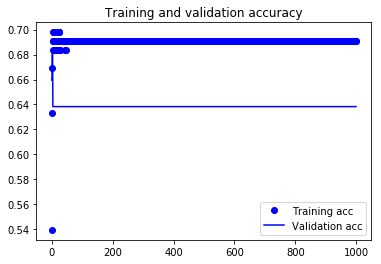

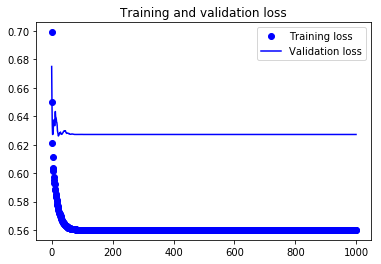

In [366]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [367]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

47/47 [==============================] - 0s 64us/step
test loss: 0.6271742037002076, test accuracy: 0.6382978558540344


In [368]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.6725490196078431


In [369]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.0


### KMeans

In [302]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.347152              0.215026              0.572244   
1                0.820325             -1.142202             -0.584840   
2               -0.368979             -1.101005              1.316826   
3                0.137511             -1.462891              1.217279   
4                0.067094             -1.364744              1.323658   
5               -0.308205              1.554912              0.177715   
6               -0.229900              1.130218             -0.432863   
7                0.128919             -2.154466             -1.473142   
8               -0.428809              1.078779              0.122401   
9                0.508739             -1.275256              0.146667   
10               0.236456             -1.307369             -0.087549   
11              -0.332097             -2.136115             -0.379978   
12               0.878776             -0.818718             -0.318688   
13              -0.503536             -1.372498             -0.663743   
14              -0.225399             -2.333299             -0.977473   
15               1.637443              0.565792              1.742275   
16               1.593976             -0.388711             -1.659037   
17               1.453127             -0.044197              0.718333   
18               0.574197             -0.311820             -1.315952   
19               1.285525              0.753218             -0.678607   
20              -0.420448             -0.248495              0.126628   
21               0.782508             -0.432480             -1.645501   
22               1.220720              0.555439              1.643752   
23               1.276232             -0.970408             -2.218229   
24               0.330249              0.500340              0.945837   
25              -0.457742              1.246710              1.511768   
26              -0.128012              0.619401              1.421912   
27               1.567570             -0.230001              1.237739   
28              -0.343287             -1.213337              1.470523   
29              -1.776654             -1.197082              0.552844   
..                    ...                   ...                   ...   
156              1.136603              1.061921             -1.369527   
157             -0.957141              0.412565             -0.099705   
158              0.627291             -0.982430              0.247369   
159              0.605582             -0.713493             -0.033525   
160              0.435082             -1.765650             -0.206944   
161             -0.869679             -0.284973             -0.185255   
162              1.695010              0.478353             -2.356288   
163              1.201750             -0.589959             -0.583958   
164              0.602223              1.408737              0.093544   
165              1.273699              0.835188              0.238069   
166              0.910091              0.783406             -0.282440   
167              0.784319             -0.628463              0.531487   
168              0.597174             -0.260556              0.776122   
169              0.512245             -0.906993              0.867897   
170              0.766694              0.045665              1.652744   
171              0.729920             -0.012315              1.424850   
172             -0.250595              1.333637              0.735398   
173              0.239742              1.083681             -0.966488   
174              0.318041              0.919114             -0.293494   
175             -0.249524             -1.310616             -1.629695   
176             -0.239498             -0.884659             -1.273002   
177             -0.247995             -0.379289              0.038455   
178             -1.538412              0.875654             -1.

In [303]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[1116.0000000000002,
 927.5012922756229,
 805.362167602635,
 709.3398851775523,
 644.8353925193064,
 590.0040583169643,
 547.564638663471,
 517.2051050812995,
 492.673077864197,
 467.91458811999206,
 449.82839909018185,
 426.939832241735,
 408.8927579760986,
 392.386338225884]

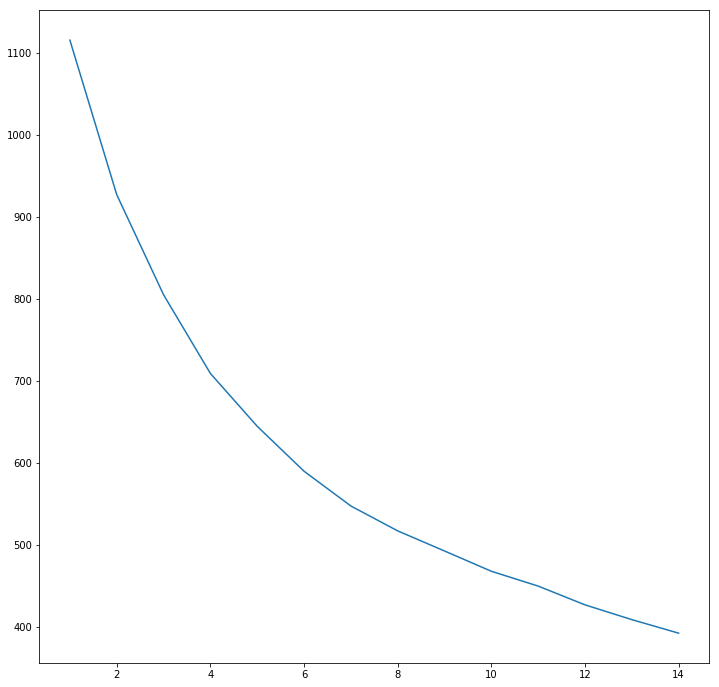

In [304]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=4

In [305]:
kmeans_tc = KMeans(n_clusters=4, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [306]:
kmeans_tc.labels_

array([1, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 2, 2, 2, 1, 1,
       1, 0, 3, 3, 3, 0, 3, 3, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 2, 2, 1, 0,
       2, 0, 0, 3, 3, 0, 0, 1, 1, 0, 3, 3, 1, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       0, 0, 0, 2, 1, 1, 3, 3, 3, 0, 2, 0, 3, 3, 3, 1, 2, 0, 3, 0, 1, 3,
       2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 1, 2, 3, 2, 1, 2, 1,
       1, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 2, 3, 3, 3, 3, 0, 0, 0, 3, 0, 3,
       1, 2, 1, 3, 1, 1, 2, 0, 1, 1, 3, 1, 1, 2, 2, 2, 2, 2, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 1, 3])

In [307]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([1, 2, 2, 2, 2, 3, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1,
       2, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 1, 1, 3, 0, 0, 2, 2, 2, 1, 1,
       1, 0, 3, 3, 3, 0, 3, 3, 1, 1, 1, 0, 3, 0, 1, 1, 1, 1, 2, 2, 1, 0,
       2, 0, 0, 3, 3, 0, 0, 1, 1, 0, 3, 3, 1, 2, 2, 2, 2, 2, 1, 2, 3, 3,
       0, 0, 0, 2, 1, 1, 3, 3, 3, 0, 2, 0, 3, 3, 3, 1, 2, 0, 3, 0, 1, 3,
       2, 0, 0, 3, 0, 0, 0, 0, 2, 0, 2, 2, 3, 2, 2, 1, 2, 3, 2, 1, 2, 1,
       1, 1, 3, 3, 1, 3, 1, 0, 3, 1, 3, 2, 3, 3, 3, 3, 0, 0, 0, 3, 0, 3,
       1, 2, 1, 3, 1, 1, 2, 0, 1, 1, 3, 1, 1, 2, 2, 2, 2, 2, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 2, 2, 2, 1, 3])

In [308]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [309]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.347152              0.215026              0.572244   
1                0.820325             -1.142202             -0.584840   
2               -0.368979             -1.101005              1.316826   
3                0.137511             -1.462891              1.217279   
4                0.067094             -1.364744              1.323658   
5               -0.308205              1.554912              0.177715   
6               -0.229900              1.130218             -0.432863   
7                0.128919             -2.154466             -1.473142   
8               -0.428809              1.078779              0.122401   
9                0.508739             -1.275256              0.146667   
10               0.236456             -1.307369             -0.087549   
11              -0.332097             -2.136115             -0.379978   
12               0.878776             -0.818718             -0.318688   
13              -0.503536             -1.372498             -0.663743   
14              -0.225399             -2.333299             -0.977473   
15               1.637443              0.565792              1.742275   
16               1.593976             -0.388711             -1.659037   
17               1.453127             -0.044197              0.718333   
18               0.574197             -0.311820             -1.315952   
19               1.285525              0.753218             -0.678607   
20              -0.420448             -0.248495              0.126628   
21               0.782508             -0.432480             -1.645501   
22               1.220720              0.555439              1.643752   
23               1.276232             -0.970408             -2.218229   
24               0.330249              0.500340              0.945837   
25              -0.457742              1.246710              1.511768   
26              -0.128012              0.619401              1.421912   
27               1.567570             -0.230001              1.237739   
28              -0.343287             -1.213337              1.470523   
29              -1.776654             -1.197082              0.552844   
..                    ...                   ...                   ...   
156              1.136603              1.061921             -1.369527   
157             -0.957141              0.412565             -0.099705   
158              0.627291             -0.982430              0.247369   
159              0.605582             -0.713493             -0.033525   
160              0.435082             -1.765650             -0.206944   
161             -0.869679             -0.284973             -0.185255   
162              1.695010              0.478353             -2.356288   
163              1.201750             -0.589959             -0.583958   
164              0.602223              1.408737              0.093544   
165              1.273699              0.835188              0.238069   
166              0.910091              0.783406             -0.282440   
167              0.784319             -0.628463              0.531487   
168              0.597174             -0.260556              0.776122   
169              0.512245             -0.906993              0.867897   
170              0.766694              0.045665              1.652744   
171              0.729920             -0.012315              1.424850   
172             -0.250595              1.333637              0.735398   
173              0.239742              1.083681             -0.966488   
174              0.318041              0.919114             -0.293494   
175             -0.249524             -1.310616             -1.629695   
176             -0.239498             -0.884659             -1.273002   
177             -0.247995             -0.379289              0.038455   
178             -1.538412              0.875654             -1.

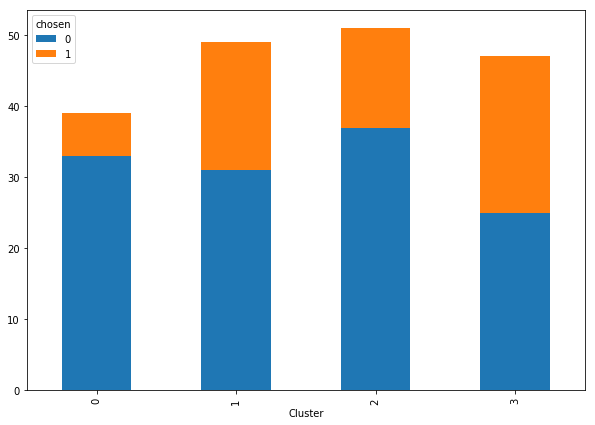

In [310]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [370]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[4]))

## Specialized

### ANN

In [371]:
X = df_n_ps_std_tc[4]

In [372]:
y = df_n_ps[4]['chosen']

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [374]:
X_train.shape

(164, 6)

In [315]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [316]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [317]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [318]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30, 20, 10), 'learning_rate_init': 0.006, 'max_iter': 400}, que permiten obtener un Accuracy de 69.51% y un Kappa del 38.98
Tiempo total: 23.88 minutos


In [375]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.006
epochs = 400

In [376]:
input_tensor = Input(shape = (n0,))

In [377]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [378]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [379]:
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_59 (Dense)             (None, 30)                210       
_________________________________________________________________
dense_60 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_61 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 11        
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________


In [380]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 164 samples, validate on 55 samples
Epoch 1/400
164/164 [==============================] - 0s 1ms/step - loss: 0.7088 - accuracy: 0.5183 - val_loss: 0.7087 - val_accuracy: 0.5455
Epoch 2/400
164/164 [==============================] - 0s 67us/step - loss: 0.6622 - accuracy: 0.6037 - val_loss: 0.6899 - val_accuracy: 0.5273
Epoch 3/400
164/164 [==============================] - 0s 79us/step - loss: 0.6587 - accuracy: 0.5793 - val_loss: 0.6864 - val_accuracy: 0.5455
Epoch 4/400
164/164 [==============================] - 0s 73us/step - loss: 0.6552 - accuracy: 0.5671 - val_loss: 0.6980 - val_accuracy: 0.4909
Epoch 5/400
164/164 [==============================] - 0s 67us/step - loss: 0.6541 - accuracy: 0.5976 - val_loss: 0.7080 - val_accuracy: 0.5273
Epoch 6/400
164/164 [==============================] - 0s 67us/step - loss: 0.6436 - accuracy: 0.6280 - val_loss: 0.7127 - val_accuracy: 0.5091
Epoch 7/400
164/164 [==============================] - 0s 73us/step - loss: 0.6387 - accurac

Epoch 55/400
164/164 [==============================] - 0s 73us/step - loss: 0.4896 - accuracy: 0.7866 - val_loss: 0.6946 - val_accuracy: 0.5636
Epoch 56/400
164/164 [==============================] - 0s 79us/step - loss: 0.4889 - accuracy: 0.7866 - val_loss: 0.6945 - val_accuracy: 0.5636
Epoch 57/400
164/164 [==============================] - 0s 85us/step - loss: 0.4881 - accuracy: 0.7927 - val_loss: 0.6952 - val_accuracy: 0.5636
Epoch 58/400
164/164 [==============================] - 0s 73us/step - loss: 0.4879 - accuracy: 0.7927 - val_loss: 0.6949 - val_accuracy: 0.5636
Epoch 59/400
164/164 [==============================] - 0s 79us/step - loss: 0.4871 - accuracy: 0.7927 - val_loss: 0.6967 - val_accuracy: 0.5636
Epoch 60/400
164/164 [==============================] - 0s 98us/step - loss: 0.4867 - accuracy: 0.7988 - val_loss: 0.6976 - val_accuracy: 0.5636
Epoch 61/400
164/164 [==============================] - 0s 85us/step - loss: 0.4860 - accuracy: 0.7988 - val_loss: 0.6975 - val_ac

164/164 [==============================] - 0s 73us/step - loss: 0.4794 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 109/400
164/164 [==============================] - 0s 73us/step - loss: 0.4794 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 110/400
164/164 [==============================] - 0s 73us/step - loss: 0.4794 - accuracy: 0.8049 - val_loss: 0.6965 - val_accuracy: 0.5455
Epoch 111/400
164/164 [==============================] - 0s 73us/step - loss: 0.4794 - accuracy: 0.8049 - val_loss: 0.6965 - val_accuracy: 0.5455

Epoch 00111: ReduceLROnPlateau reducing learning rate to 5.859375050931703e-06.
Epoch 112/400
164/164 [==============================] - 0s 73us/step - loss: 0.4793 - accuracy: 0.8049 - val_loss: 0.6965 - val_accuracy: 0.5455
Epoch 113/400
164/164 [==============================] - 0s 67us/step - loss: 0.4793 - accuracy: 0.8049 - val_loss: 0.6965 - val_accuracy: 0.5455
Epoch 114/400
164/164 [==============================] - 

164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455

Epoch 00161: ReduceLROnPlateau reducing learning rate to 1.8310547034161573e-07.
Epoch 162/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 163/400
164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 164/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 165/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 166/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 167/400
164/164 [==============================] -

Epoch 214/400
164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 215/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 216/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 217/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 218/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 219/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 220/400
164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 -

164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 268/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 269/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 270/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 271/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455

Epoch 00271: ReduceLROnPlateau reducing learning rate to 8.940696794024205e-11.
Epoch 272/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 273/400
164/164 [==============================] - 

164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 321/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455

Epoch 00321: ReduceLROnPlateau reducing learning rate to 2.7939677481325642e-12.
Epoch 322/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 323/400
164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 324/400
164/164 [==============================] - 0s 67us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 325/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 326/400
164/164 [==============================] -

Epoch 373/400
164/164 [==============================] - 0s 85us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 374/400
164/164 [==============================] - 0s 79us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 375/400
164/164 [==============================] - 0s 98us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 376/400
164/164 [==============================] - 0s 98us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 377/400
164/164 [==============================] - 0s 91us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 378/400
164/164 [==============================] - 0s 85us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 - val_accuracy: 0.5455
Epoch 379/400
164/164 [==============================] - 0s 73us/step - loss: 0.4791 - accuracy: 0.8049 - val_loss: 0.6964 -

range(0, 400)


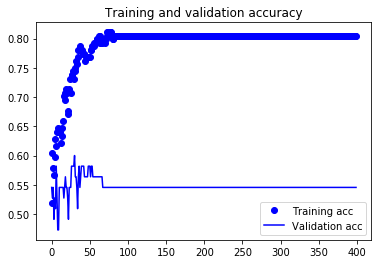

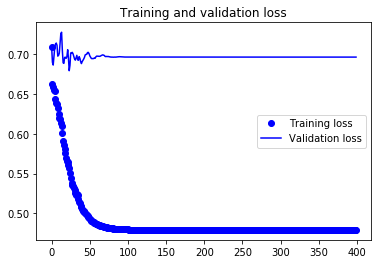

In [381]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [382]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

55/55 [==============================] - 0s 73us/step
test loss: 0.696373957937414, test accuracy: 0.5454545617103577


In [383]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.6058201058201058


In [384]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.09120951751487105


### KMeans

In [329]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0               -1.035481              1.779354              1.874576   
1                0.965487             -0.399971             -1.606069   
2               -0.141249             -1.969933             -0.960470   
3               -1.590590             -0.729741             -0.575342   
4               -0.391524             -0.894181             -0.426309   
5               -1.256622             -0.886861             -0.850243   
6               -1.579202              0.121365             -0.522749   
7               -1.760350             -0.182429             -0.008789   
8                1.115526              1.555384              0.609404   
9                1.467291              1.402697              0.806896   
10               0.972379              1.550575             -0.223468   
11               0.294385              0.890870              0.493531   
12               0.795134              0.176458              1.588747   
13               0.694481              0.577820              0.319393   
14               1.169114              0.075245             -0.980006   
15               0.962642              0.380225             -1.261850   
16               1.352245              0.463507             -0.679184   
17               1.784002             -1.453636             -1.128885   
18               0.929212             -0.538274             -1.016394   
19               1.199761             -0.727252              0.322239   
20              -0.485056              0.796900              0.581966   
21              -0.547233              0.692440             -0.162284   
22               1.446103             -0.074850             -0.132752   
23              -0.312063              0.030270             -1.160963   
24               1.175126             -0.143713             -0.522479   
25              -1.044292             -0.058933             -1.340279   
26              -0.849044              0.079838             -0.400536   
27              -0.730672             -0.326196             -0.478608   
28              -0.380922             -0.892886             -0.555313   
29              -0.368302             -1.168844             -0.094765   
..                    ...                   ...                   ...   
189             -1.023243              0.827082              0.695531   
190              1.643548             -0.570770              0.545333   
191              1.543182             -0.533850              0.979103   
192              1.416929             -1.770555              0.592692   
193             -1.336444              0.162214             -1.528887   
194             -0.331197             -0.545328              0.449891   
195             -0.991382             -0.378373             -0.215170   
196              0.827092              0.502299              0.219306   
197              0.976291              0.325663             -0.091820   
198              0.903378              0.857383              0.090549   
199             -1.135922             -0.217483             -0.201444   
200             -1.143077             -0.289624             -0.109440   
201             -1.325584             -0.109383             -0.850284   
202              0.270878              1.568003             -0.899682   
203             -0.010376              1.403657             -0.298654   
204             -0.149606              0.679408             -0.527828   
205             -1.281900              0.472582              2.041397   
206             -1.561361              0.699591              0.373931   
207             -0.548022              0.646014             -0.015758   
208             -0.689835              0.729721              0.242422   
209             -1.182263              0.898528              0.655331   
210             -0.465862              0.576977             -0.088421   
211             -0.265321              1.252143              0.

In [330]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[1314.0,
 1103.6617898421102,
 933.9046374976435,
 830.0952355796812,
 752.8157274494505,
 696.8283563577859,
 641.355058887789,
 599.6834692450786,
 558.0899857646746,
 538.6016435622136,
 502.540180641064,
 477.03865333096127,
 457.1745404655215,
 443.08717934712786]

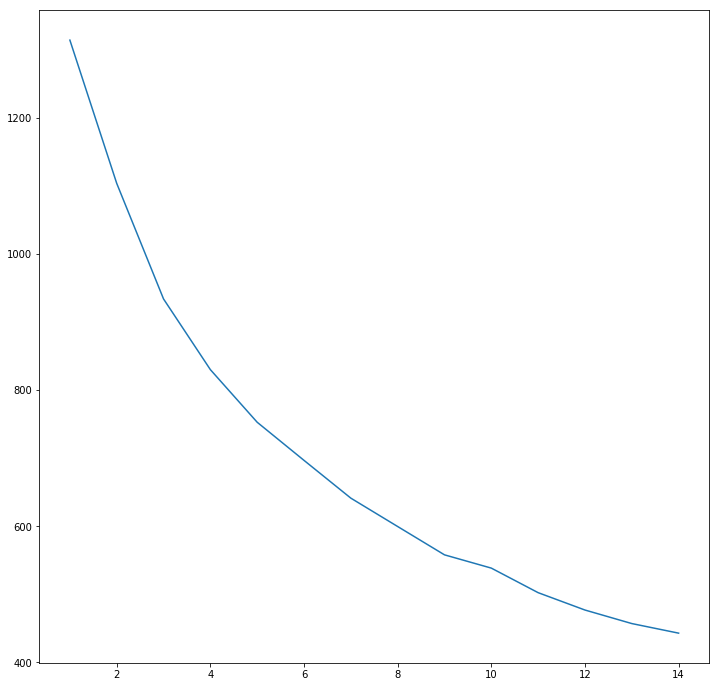

In [331]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [332]:
kmeans_tc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [333]:
kmeans_tc.labels_

array([2, 2, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 2, 2,
       0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1])

In [334]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([2, 2, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0, 2, 2,
       0, 2, 2, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 1, 0, 0, 1, 1, 1, 2, 2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 2, 2,
       0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       2, 1, 1, 2, 2, 1, 2, 2, 2, 0, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1])

In [335]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [336]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0               -1.035481              1.779354              1.874576   
1                0.965487             -0.399971             -1.606069   
2               -0.141249             -1.969933             -0.960470   
3               -1.590590             -0.729741             -0.575342   
4               -0.391524             -0.894181             -0.426309   
5               -1.256622             -0.886861             -0.850243   
6               -1.579202              0.121365             -0.522749   
7               -1.760350             -0.182429             -0.008789   
8                1.115526              1.555384              0.609404   
9                1.467291              1.402697              0.806896   
10               0.972379              1.550575             -0.223468   
11               0.294385              0.890870              0.493531   
12               0.795134              0.176458              1.588747   
13               0.694481              0.577820              0.319393   
14               1.169114              0.075245             -0.980006   
15               0.962642              0.380225             -1.261850   
16               1.352245              0.463507             -0.679184   
17               1.784002             -1.453636             -1.128885   
18               0.929212             -0.538274             -1.016394   
19               1.199761             -0.727252              0.322239   
20              -0.485056              0.796900              0.581966   
21              -0.547233              0.692440             -0.162284   
22               1.446103             -0.074850             -0.132752   
23              -0.312063              0.030270             -1.160963   
24               1.175126             -0.143713             -0.522479   
25              -1.044292             -0.058933             -1.340279   
26              -0.849044              0.079838             -0.400536   
27              -0.730672             -0.326196             -0.478608   
28              -0.380922             -0.892886             -0.555313   
29              -0.368302             -1.168844             -0.094765   
..                    ...                   ...                   ...   
189             -1.023243              0.827082              0.695531   
190              1.643548             -0.570770              0.545333   
191              1.543182             -0.533850              0.979103   
192              1.416929             -1.770555              0.592692   
193             -1.336444              0.162214             -1.528887   
194             -0.331197             -0.545328              0.449891   
195             -0.991382             -0.378373             -0.215170   
196              0.827092              0.502299              0.219306   
197              0.976291              0.325663             -0.091820   
198              0.903378              0.857383              0.090549   
199             -1.135922             -0.217483             -0.201444   
200             -1.143077             -0.289624             -0.109440   
201             -1.325584             -0.109383             -0.850284   
202              0.270878              1.568003             -0.899682   
203             -0.010376              1.403657             -0.298654   
204             -0.149606              0.679408             -0.527828   
205             -1.281900              0.472582              2.041397   
206             -1.561361              0.699591              0.373931   
207             -0.548022              0.646014             -0.015758   
208             -0.689835              0.729721              0.242422   
209             -1.182263              0.898528              0.655331   
210             -0.465862              0.576977             -0.088421   
211             -0.265321              1.252143              0.

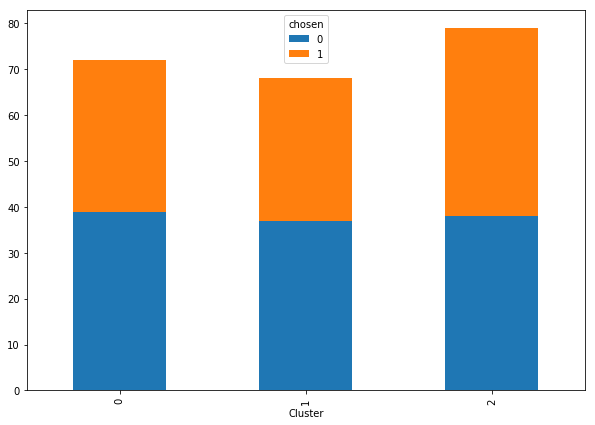

In [337]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [385]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[5]))

## Urban Place

### ANN

In [386]:
X = df_n_ps_std_tc[5]

In [387]:
y = df_n_ps[5]['chosen']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [389]:
X_train.shape

(168, 6)

In [343]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [344]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [345]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [346]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.005, 'max_iter': 200}, que permiten obtener un Accuracy de 70.83% y un Kappa del 35.52
Tiempo total: 28.81 minutos


In [390]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = grid.best_params_['learning_rate_init']
epochs = grid.best_params_['max_iter']

In [391]:
input_tensor = Input(shape = (n0,))

In [392]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [393]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [394]:
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 6)                 0         
_________________________________________________________________
dense_63 (Dense)             (None, 20)                140       
_________________________________________________________________
dense_64 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 11        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [395]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 168 samples, validate on 57 samples
Epoch 1/100
168/168 [==============================] - 0s 1ms/step - loss: 0.7516 - accuracy: 0.4524 - val_loss: 0.6534 - val_accuracy: 0.6316
Epoch 2/100
168/168 [==============================] - 0s 95us/step - loss: 0.6794 - accuracy: 0.5536 - val_loss: 0.6620 - val_accuracy: 0.5789
Epoch 3/100
168/168 [==============================] - 0s 89us/step - loss: 0.6278 - accuracy: 0.6429 - val_loss: 0.6804 - val_accuracy: 0.5789
Epoch 4/100
168/168 [==============================] - 0s 77us/step - loss: 0.5998 - accuracy: 0.7143 - val_loss: 0.7046 - val_accuracy: 0.6316
Epoch 5/100
168/168 [==============================] - 0s 65us/step - loss: 0.5769 - accuracy: 0.7321 - val_loss: 0.7229 - val_accuracy: 0.6316
Epoch 6/100
168/168 [==============================] - 0s 77us/step - loss: 0.5672 - accuracy: 0.7381 - val_loss: 0.7281 - val_accuracy: 0.6491
Epoch 7/100
168/168 [==============================] - 0s 77us/step - loss: 0.5561 - accurac

168/168 [==============================] - 0s 65us/step - loss: 0.4638 - accuracy: 0.8214 - val_loss: 0.7577 - val_accuracy: 0.6667

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 56/100
168/168 [==============================] - 0s 71us/step - loss: 0.4632 - accuracy: 0.8214 - val_loss: 0.7573 - val_accuracy: 0.6667
Epoch 57/100
168/168 [==============================] - 0s 65us/step - loss: 0.4630 - accuracy: 0.8214 - val_loss: 0.7570 - val_accuracy: 0.6667
Epoch 58/100
168/168 [==============================] - 0s 59us/step - loss: 0.4628 - accuracy: 0.8274 - val_loss: 0.7557 - val_accuracy: 0.6667
Epoch 59/100
168/168 [==============================] - 0s 71us/step - loss: 0.4625 - accuracy: 0.8274 - val_loss: 0.7553 - val_accuracy: 0.6667
Epoch 60/100
168/168 [==============================] - 0s 71us/step - loss: 0.4624 - accuracy: 0.8274 - val_loss: 0.7548 - val_accuracy: 0.6667
Epoch 61/100
168/168 [==============================] - 0s 125

range(0, 100)


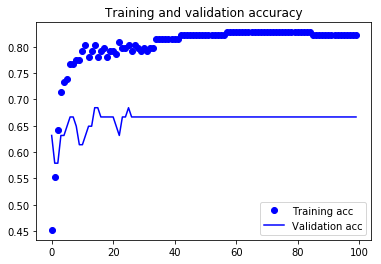

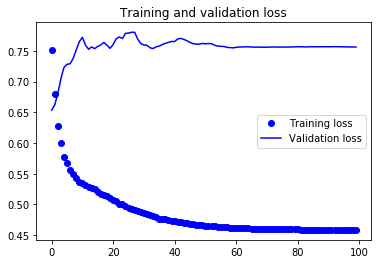

In [396]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [397]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

57/57 [==============================] - 0s 53us/step
test loss: 0.756120643071961, test accuracy: 0.6666666865348816


In [398]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.5753246753246753


In [399]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.19479553903345737


### KMeans

In [357]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.221298             -0.131733             -0.299437   
1               -0.401407             -1.423353              0.879221   
2               -0.336789             -0.749510              0.197427   
3               -0.785803              0.323072              0.152856   
4               -0.879329              0.391910              0.348949   
5               -1.122300              0.270282              0.525297   
6                1.854801             -0.110375              0.714529   
7                1.233933              0.235407              0.220324   
8                0.870319              0.678474              0.499988   
9                0.390986              0.860360             -1.381945   
10               0.746873              1.087314              0.138873   
11               0.794479              0.967314             -0.363499   
12              -1.413209             -0.136961             -0.371584   
13              -0.072759             -1.149988              1.952271   
14              -1.273932             -0.022476             -0.393398   
15              -1.343760             -0.913734              0.077520   
16              -0.984733             -0.428093              1.220123   
17               0.280303              1.062737             -0.783356   
18               0.000660              1.240654             -0.919850   
19               0.174949              1.113514             -2.625056   
20              -0.183363             -1.557702             -0.979966   
21              -0.171420             -1.728398             -0.653886   
22              -0.120605             -1.190295              1.627818   
23              -1.074141              1.086592              0.969446   
24              -1.016635              1.061833              0.981137   
25              -1.093370              1.015536             -0.193033   
26              -0.428676              1.178009              1.290983   
27              -1.196386             -0.495161              0.531435   
28               0.866731              0.412772              1.289048   
29               1.237442              0.582034              1.478319   
..                    ...                   ...                   ...   
195             -0.603701              0.935409             -0.419589   
196              1.708997             -0.221303             -1.454810   
197             -0.120947              0.962072             -0.135798   
198              1.023034              0.904205             -0.425604   
199              1.607139              1.023377             -0.668664   
200              1.108675              0.450827             -1.313634   
201              0.806904              1.114638              0.335775   
202              1.126699              1.174832             -0.674497   
203             -0.345663             -1.373739              1.109525   
204              1.158812              0.165993             -1.074239   
205              1.365396             -0.199409             -0.349417   
206              0.988164             -1.144285             -0.272909   
207              0.905347             -0.717727              0.050759   
208              0.749668              1.003858             -0.003342   
209              1.094646              0.741328             -0.142645   
210              0.893047              0.990481              0.297007   
211              2.012667              0.112112              2.554833   
212              0.509494             -0.082608              1.308021   
213              0.505972              0.224521              1.805274   
214              1.135681              1.126084              0.303609   
215              0.894848              1.251553              0.035370   
216              0.990624              1.229073              0.307033   
217             -1.693745              0.917833             -1.

In [358]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[1350.0,
 1124.435731037261,
 969.7111524654798,
 861.1739982448028,
 779.024220761341,
 706.2330662595951,
 649.2198311716684,
 599.2097480238398,
 565.7104737024936,
 525.1010514512898,
 497.51074255236824,
 479.1767694058344,
 448.31267298836974,
 436.24565823492435]

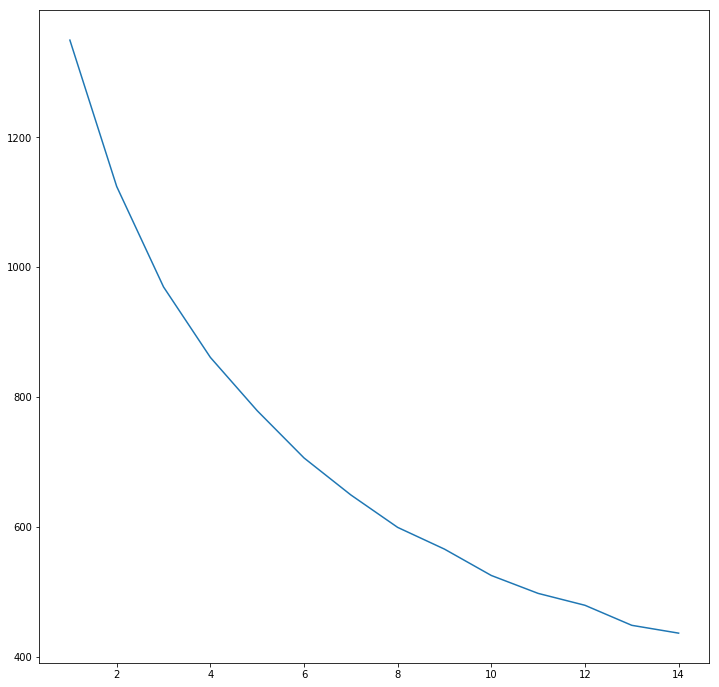

In [359]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [360]:
kmeans_tc = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_tc.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [361]:
kmeans_tc.labels_

array([0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0,
       1, 1, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0,
       1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1,
       2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0, 1,
       1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 0, 2, 2])

In [362]:
clusters_tc = kmeans_tc.predict(X)
clusters_tc

array([0, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 0, 0, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1,
       0, 0, 0, 2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 0,
       1, 1, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0,
       1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 1,
       2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2,
       2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 0, 1,
       1, 1, 0, 1, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 0, 2, 2])

In [363]:
X.loc[:,'Cluster'] = clusters_tc
X.loc[:,'chosen'] = list(y)

In [364]:
X

tonalcentroidfiles_1  tonalcentroidfiles_2  tonalcentroidfiles_3  \
0                1.221298             -0.131733             -0.299437   
1               -0.401407             -1.423353              0.879221   
2               -0.336789             -0.749510              0.197427   
3               -0.785803              0.323072              0.152856   
4               -0.879329              0.391910              0.348949   
5               -1.122300              0.270282              0.525297   
6                1.854801             -0.110375              0.714529   
7                1.233933              0.235407              0.220324   
8                0.870319              0.678474              0.499988   
9                0.390986              0.860360             -1.381945   
10               0.746873              1.087314              0.138873   
11               0.794479              0.967314             -0.363499   
12              -1.413209             -0.136961             -0.371584   
13              -0.072759             -1.149988              1.952271   
14              -1.273932             -0.022476             -0.393398   
15              -1.343760             -0.913734              0.077520   
16              -0.984733             -0.428093              1.220123   
17               0.280303              1.062737             -0.783356   
18               0.000660              1.240654             -0.919850   
19               0.174949              1.113514             -2.625056   
20              -0.183363             -1.557702             -0.979966   
21              -0.171420             -1.728398             -0.653886   
22              -0.120605             -1.190295              1.627818   
23              -1.074141              1.086592              0.969446   
24              -1.016635              1.061833              0.981137   
25              -1.093370              1.015536             -0.193033   
26              -0.428676              1.178009              1.290983   
27              -1.196386             -0.495161              0.531435   
28               0.866731              0.412772              1.289048   
29               1.237442              0.582034              1.478319   
..                    ...                   ...                   ...   
195             -0.603701              0.935409             -0.419589   
196              1.708997             -0.221303             -1.454810   
197             -0.120947              0.962072             -0.135798   
198              1.023034              0.904205             -0.425604   
199              1.607139              1.023377             -0.668664   
200              1.108675              0.450827             -1.313634   
201              0.806904              1.114638              0.335775   
202              1.126699              1.174832             -0.674497   
203             -0.345663             -1.373739              1.109525   
204              1.158812              0.165993             -1.074239   
205              1.365396             -0.199409             -0.349417   
206              0.988164             -1.144285             -0.272909   
207              0.905347             -0.717727              0.050759   
208              0.749668              1.003858             -0.003342   
209              1.094646              0.741328             -0.142645   
210              0.893047              0.990481              0.297007   
211              2.012667              0.112112              2.554833   
212              0.509494             -0.082608              1.308021   
213              0.505972              0.224521              1.805274   
214              1.135681              1.126084              0.303609   
215              0.894848              1.251553              0.035370   
216              0.990624              1.229073              0.307033   
217             -1.693745              0.917833             -1.

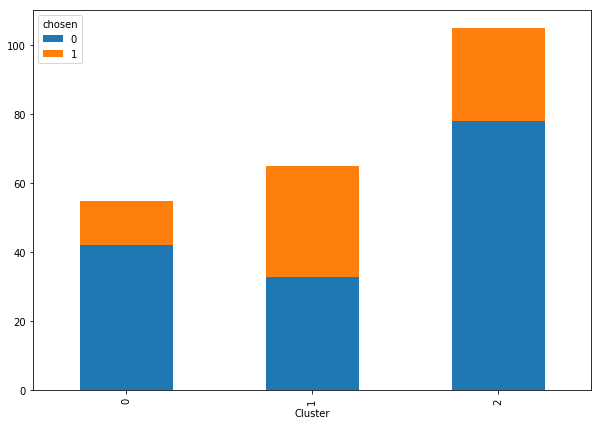

In [365]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

# Chromagram

In [404]:
df_n_ps_std[0].columns

Index(['durationfiles', 'rmsfiles', 'rmsmedianfiles', 'lowenergyfiles',
       'ASRfiles', 'beatspectrumfiles', 'eventdensityfiles', 'tempofiles',
       'pulseclarityfiles', 'zerocrossfiles', 'rolloffsfiles',
       'brightnessfiles', 'spreadfiles', 'centroidfiles', 'kurtosisfiles',
       'flatnessfiles', 'entropyfiles', 'mfccfiles_1', 'mfccfiles_2',
       'mfccfiles_3', 'mfccfiles_4', 'mfccfiles_5', 'mfccfiles_6',
       'mfccfiles_7', 'mfccfiles_8', 'mfccfiles_9', 'mfccfiles_10',
       'mfccfiles_11', 'mfccfiles_12', 'mfccfiles_13', 'inharmonicityfiles',
       'bestkeyfiles', 'keyclarityfiles', 'modalityfiles',
       'tonalcentroidfiles_1', 'tonalcentroidfiles_2', 'tonalcentroidfiles_3',
       'tonalcentroidfiles_4', 'tonalcentroidfiles_5', 'tonalcentroidfiles_6',
       'chromagramfiles_1', 'chromagramfiles_2', 'chromagramfiles_3',
       'chromagramfiles_4', 'chromagramfiles_5', 'chromagramfiles_6',
       'chromagramfiles_7', 'chromagramfiles_8', 'chromagramfiles_9',
      

In [405]:
df_n_ps_std[0].columns[40:52]

Index(['chromagramfiles_1', 'chromagramfiles_2', 'chromagramfiles_3',
       'chromagramfiles_4', 'chromagramfiles_5', 'chromagramfiles_6',
       'chromagramfiles_7', 'chromagramfiles_8', 'chromagramfiles_9',
       'chromagramfiles_10', 'chromagramfiles_11', 'chromagramfiles_12'],
      dtype='object')

In [406]:
df_n_ps_std_ch = [None]*len(companies)
for i in range(len(companies)):
    df_n_ps_std_ch[i] = pd.DataFrame(df_n_ps_std[i].iloc[:,40:52])
    df_n_ps_std_ch[i].columns=df_n_ps_std[i].columns[40:52]
df_n_ps_std_ch[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 12 columns):
chromagramfiles_1     372 non-null float64
chromagramfiles_2     372 non-null float64
chromagramfiles_3     372 non-null float64
chromagramfiles_4     372 non-null float64
chromagramfiles_5     372 non-null float64
chromagramfiles_6     372 non-null float64
chromagramfiles_7     372 non-null float64
chromagramfiles_8     372 non-null float64
chromagramfiles_9     372 non-null float64
chromagramfiles_10    372 non-null float64
chromagramfiles_11    372 non-null float64
chromagramfiles_12    372 non-null float64
dtypes: float64(12)
memory usage: 35.0 KB


## Arte Francés

### ANN

In [407]:
X = df_n_ps_std_ch[0]

In [408]:
y = df_n_ps[0]['chosen']

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [410]:
X_train.shape

(279, 12)

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [25]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [26]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [27]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (30, 30, 30), 'learning_rate_init': 0.008, 'max_iter': 100}, que permiten obtener un Accuracy de 78.49% y un Kappa del 30.33
Tiempo total: 23.83 minutos


In [411]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,30,30]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.008
epochs = 100

In [412]:
input_tensor = Input(shape = (n0,))

In [413]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [414]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [415]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_67 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_68 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 31        
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________


In [416]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 279 samples, validate on 93 samples
Epoch 1/100
279/279 [==============================] - 0s 792us/step - loss: 0.6389 - accuracy: 0.6452 - val_loss: 0.5521 - val_accuracy: 0.6882
Epoch 2/100
279/279 [==============================] - 0s 68us/step - loss: 0.5409 - accuracy: 0.7384 - val_loss: 0.5195 - val_accuracy: 0.7742
Epoch 3/100
279/279 [==============================] - 0s 54us/step - loss: 0.5159 - accuracy: 0.7634 - val_loss: 0.5163 - val_accuracy: 0.7742
Epoch 4/100
279/279 [==============================] - 0s 61us/step - loss: 0.4912 - accuracy: 0.7634 - val_loss: 0.5340 - val_accuracy: 0.7849
Epoch 5/100
279/279 [==============================] - 0s 57us/step - loss: 0.4777 - accuracy: 0.7706 - val_loss: 0.5239 - val_accuracy: 0.7634
Epoch 6/100
279/279 [==============================] - 0s 57us/step - loss: 0.4586 - accuracy: 0.7742 - val_loss: 0.5071 - val_accuracy: 0.7634
Epoch 7/100
279/279 [==============================] - 0s 57us/step - loss: 0.4379 - accur

279/279 [==============================] - 0s 61us/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 0.9178 - val_accuracy: 0.7742
Epoch 56/100
279/279 [==============================] - 0s 61us/step - loss: 0.0218 - accuracy: 0.9964 - val_loss: 0.9186 - val_accuracy: 0.7742
Epoch 57/100
279/279 [==============================] - 0s 57us/step - loss: 0.0216 - accuracy: 0.9964 - val_loss: 0.9237 - val_accuracy: 0.7742
Epoch 58/100
279/279 [==============================] - 0s 82us/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.9231 - val_accuracy: 0.7742
Epoch 59/100
279/279 [==============================] - 0s 68us/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.9316 - val_accuracy: 0.7742

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 60/100
279/279 [==============================] - 0s 57us/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.9325 - val_accuracy: 0.7742
Epoch 61/100
279/279 [==============================] - 0s 61u

range(0, 100)


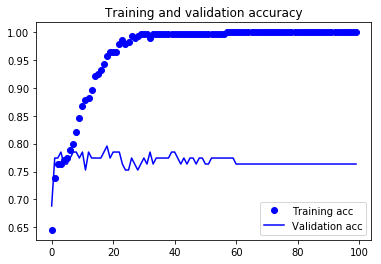

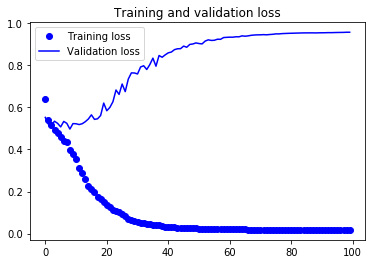

In [417]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [418]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

93/93 [==============================] - 0s 43us/step
test loss: 0.9567250449170348, test accuracy: 0.7634408473968506


In [419]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7076719576719577


In [420]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.18615751789976132


### KMeans

In [39]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.709998           0.081666           2.128489   
1             1.306748           0.425280           1.373850   
2             1.734670          -1.372888          -1.154236   
3             1.734670          -1.064259          -0.709050   
4             1.734670           1.475232           0.304731   
5            -1.357454          -1.560365          -0.993389   
6             0.321543          -0.501364          -0.339054   
7             1.097999          -0.427045          -0.234103   
8             1.734670           0.468400          -0.344386   
9            -1.359746          -1.205127          -0.671317   
10            1.587306           0.209036           1.657840   
11            1.734670           0.104209          -0.231131   
12            1.035685           0.546933           0.622772   
13            0.972281           0.789016           0.702993   
14           -1.133199           0.756391          -0.892669   
15           -0.286686          -0.893181          -0.864608   
16           -1.078617          -1.219578          -0.935650   
17           -0.779483          -0.945540          -0.338284   
18           -0.539003           0.776852           0.530745   
19           -0.654289          -0.841544           0.162215   
20            0.213529           1.051570           2.128489   
21           -1.008970           0.227216          -0.685589   
22           -0.509770          -0.100539          -0.507952   
23           -0.434214          -1.542384           0.834388   
24            1.024011          -0.133360           2.128488   
25            0.996972          -0.068300           0.463479   
26            1.734670          -0.636382           0.769493   
27            0.939519          -0.546060           1.545261   
28            0.065764          -1.072686           1.002347   
29            1.734670          -1.368860           0.533780   
..                 ...                ...                ...   
342          -0.855930           0.826496          -0.453379   
343          -1.395065          -0.085953           1.922929   
344          -0.298021          -1.181741          -0.986984   
345          -1.545817          -1.409239          -1.442796   
346          -0.346415          -1.039454          -1.018195   
347          -1.474386           0.029941          -0.538026   
348           0.118230           0.491129          -1.420467   
349           0.348396           0.059205          -0.665990   
350           1.734670          -0.003146           1.568996   
351          -0.099944          -0.751191           2.128489   
352           1.084858          -0.145339           0.813709   
353           1.187787          -0.429263          -0.071507   
354           0.816380          -0.786929          -0.447031   
355           1.118179          -0.721368          -0.381566   
356           1.226095           0.286296          -0.087024   
357           1.613198           0.199015           0.291700   
358           0.890203          -0.190496           0.624245   
359          -1.618544           2.294335          -0.896404   
360          -1.152545           1.039906          -0.408095   
361          -0.667401           2.294335           1.170804   
362          -1.723669           0.092346          -0.153795   
363          -1.723669          -0.253829           1.824256   
364          -1.723669          -0.295522           0.733720   
365          -0.736785          -0.662679           2.128489   
366           0.261615          -0.713681           2.128489   
367          -0.720122          -0.373744           1.948953   
368          -0.090607           0.425445           1.059996   
369           1.263139           0.315568           2.128489   
370          -1.393336           0.445276          -0.245554   
371           0.356389          -0.292506          -0.400481   

     chromagramfiles_4  chromagramfi

In [40]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[4464.0,
 3806.9754284522382,
 3354.365999848692,
 3107.5256199539926,
 2946.6963010094414,
 2816.3317870211076,
 2686.415552171973,
 2576.5543366887405,
 2504.325344232164,
 2391.4415220727014,
 2324.241850993652,
 2257.160251494757,
 2174.641140049278,
 2102.896301963741]

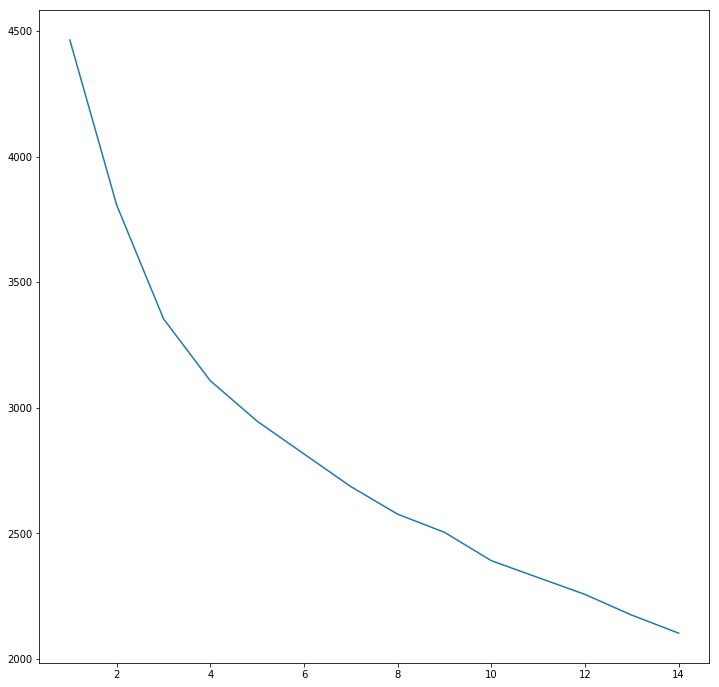

In [41]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [42]:
kmeans_ch = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [43]:
kmeans_ch.labels_

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1,

In [44]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1,

In [45]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [46]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.709998           0.081666           2.128489   
1             1.306748           0.425280           1.373850   
2             1.734670          -1.372888          -1.154236   
3             1.734670          -1.064259          -0.709050   
4             1.734670           1.475232           0.304731   
5            -1.357454          -1.560365          -0.993389   
6             0.321543          -0.501364          -0.339054   
7             1.097999          -0.427045          -0.234103   
8             1.734670           0.468400          -0.344386   
9            -1.359746          -1.205127          -0.671317   
10            1.587306           0.209036           1.657840   
11            1.734670           0.104209          -0.231131   
12            1.035685           0.546933           0.622772   
13            0.972281           0.789016           0.702993   
14           -1.133199           0.756391          -0.892669   
15           -0.286686          -0.893181          -0.864608   
16           -1.078617          -1.219578          -0.935650   
17           -0.779483          -0.945540          -0.338284   
18           -0.539003           0.776852           0.530745   
19           -0.654289          -0.841544           0.162215   
20            0.213529           1.051570           2.128489   
21           -1.008970           0.227216          -0.685589   
22           -0.509770          -0.100539          -0.507952   
23           -0.434214          -1.542384           0.834388   
24            1.024011          -0.133360           2.128488   
25            0.996972          -0.068300           0.463479   
26            1.734670          -0.636382           0.769493   
27            0.939519          -0.546060           1.545261   
28            0.065764          -1.072686           1.002347   
29            1.734670          -1.368860           0.533780   
..                 ...                ...                ...   
342          -0.855930           0.826496          -0.453379   
343          -1.395065          -0.085953           1.922929   
344          -0.298021          -1.181741          -0.986984   
345          -1.545817          -1.409239          -1.442796   
346          -0.346415          -1.039454          -1.018195   
347          -1.474386           0.029941          -0.538026   
348           0.118230           0.491129          -1.420467   
349           0.348396           0.059205          -0.665990   
350           1.734670          -0.003146           1.568996   
351          -0.099944          -0.751191           2.128489   
352           1.084858          -0.145339           0.813709   
353           1.187787          -0.429263          -0.071507   
354           0.816380          -0.786929          -0.447031   
355           1.118179          -0.721368          -0.381566   
356           1.226095           0.286296          -0.087024   
357           1.613198           0.199015           0.291700   
358           0.890203          -0.190496           0.624245   
359          -1.618544           2.294335          -0.896404   
360          -1.152545           1.039906          -0.408095   
361          -0.667401           2.294335           1.170804   
362          -1.723669           0.092346          -0.153795   
363          -1.723669          -0.253829           1.824256   
364          -1.723669          -0.295522           0.733720   
365          -0.736785          -0.662679           2.128489   
366           0.261615          -0.713681           2.128489   
367          -0.720122          -0.373744           1.948953   
368          -0.090607           0.425445           1.059996   
369           1.263139           0.315568           2.128489   
370          -1.393336           0.445276          -0.245554   
371           0.356389          -0.292506          -0.400481   

     chromagramfiles_4  chromagramfi

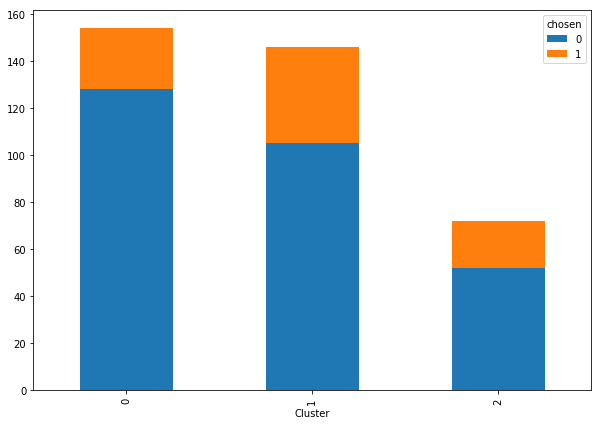

In [47]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [48]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[1]))

## Club De Banqueros y Empresarios

### ANN

In [421]:
X = df_n_ps_std_ch[1]

In [422]:
y = df_n_ps[1]['chosen']

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [424]:
X_train.shape

(191, 12)

In [53]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [54]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [55]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [60]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.004, 'max_iter': 500}, que permiten obtener un Accuracy de 78.53% y un Kappa del 40.11
Tiempo total: 24.99 minutos


In [425]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.004
epochs = 500

In [426]:
input_tensor = Input(shape = (n0,))

In [427]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [428]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [429]:
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [430]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 191 samples, validate on 64 samples
Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.4607 - val_loss: 0.7811 - val_accuracy: 0.4688
Epoch 2/500
191/191 [==============================] - 0s 63us/step - loss: 0.7341 - accuracy: 0.4921 - val_loss: 0.7282 - val_accuracy: 0.5156
Epoch 3/500
191/191 [==============================] - 0s 68us/step - loss: 0.6797 - accuracy: 0.5602 - val_loss: 0.6882 - val_accuracy: 0.5469
Epoch 4/500
191/191 [==============================] - 0s 99us/step - loss: 0.6390 - accuracy: 0.6283 - val_loss: 0.6650 - val_accuracy: 0.5469
Epoch 5/500
191/191 [==============================] - 0s 73us/step - loss: 0.6126 - accuracy: 0.6754 - val_loss: 0.6514 - val_accuracy: 0.6250
Epoch 6/500
191/191 [==============================] - 0s 63us/step - loss: 0.5926 - accuracy: 0.6963 - val_loss: 0.6429 - val_accuracy: 0.6250
Epoch 7/500
191/191 [==============================] - 0s 63us/step - loss: 0.5764 - accurac

191/191 [==============================] - 0s 105us/step - loss: 0.4507 - accuracy: 0.7958 - val_loss: 0.6931 - val_accuracy: 0.6562
Epoch 56/500
191/191 [==============================] - 0s 84us/step - loss: 0.4504 - accuracy: 0.7958 - val_loss: 0.6932 - val_accuracy: 0.6562

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 57/500
191/191 [==============================] - 0s 84us/step - loss: 0.4501 - accuracy: 0.7958 - val_loss: 0.6933 - val_accuracy: 0.6562
Epoch 58/500
191/191 [==============================] - 0s 78us/step - loss: 0.4500 - accuracy: 0.7958 - val_loss: 0.6934 - val_accuracy: 0.6562
Epoch 59/500
191/191 [==============================] - 0s 52us/step - loss: 0.4498 - accuracy: 0.7958 - val_loss: 0.6934 - val_accuracy: 0.6562
Epoch 60/500
191/191 [==============================] - 0s 63us/step - loss: 0.4497 - accuracy: 0.7958 - val_loss: 0.6933 - val_accuracy: 0.6562
Epoch 61/500
191/191 [==============================] - 0s 58

191/191 [==============================] - 0s 52us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 109/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 110/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 111/500
191/191 [==============================] - 0s 52us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 112/500
191/191 [==============================] - 0s 63us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 113/500
191/191 [==============================] - 0s 63us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 114/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy:

191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 162/500
191/191 [==============================] - 0s 47us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 163/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 164/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 165/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 166/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00166: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Epoch 167/500
191/191 [==============================] -

191/191 [==============================] - 0s 94us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 215/500
191/191 [==============================] - 0s 94us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 216/500
191/191 [==============================] - 0s 84us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00216: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 217/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 218/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 219/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 220/500
191/191 [==============================] - 

191/191 [==============================] - 0s 68us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 268/500
191/191 [==============================] - 0s 68us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 269/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 270/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 271/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 272/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 273/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy:

191/191 [==============================] - 0s 89us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 321/500
191/191 [==============================] - 0s 84us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 322/500
191/191 [==============================] - 0s 68us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 323/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 324/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 325/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 326/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy:

191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 374/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 375/500
191/191 [==============================] - 0s 84us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 376/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00376: ReduceLROnPlateau reducing learning rate to 5.820766367818295e-14.
Epoch 377/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 378/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 379/500
191/191 [==============================] - 

191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00426: ReduceLROnPlateau reducing learning rate to 1.818989489943217e-15.
Epoch 427/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 428/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 429/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 430/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 431/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 432/500
191/191 [==============================] - 

Epoch 479/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 480/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 481/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 482/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 483/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 484/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 485/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 -

range(0, 500)


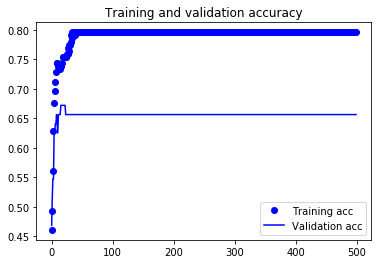

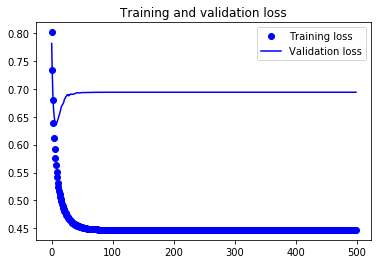

In [431]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [432]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

64/64 [==============================] - 0s 47us/step
test loss: 0.6938145160675049, test accuracy: 0.65625


In [433]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.5519480519480519


In [434]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.053763440860215006


### KMeans

In [71]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.369691          -0.881824          -0.095656   
1            -0.175875          -0.403800          -0.657709   
2             0.894452          -0.189794           1.959063   
3             0.060782          -0.392075           0.826233   
4            -1.116536          -0.923742          -1.238971   
5            -1.082752          -0.067472          -1.142511   
6            -1.202528          -0.776453          -1.135820   
7            -1.206944           0.500703          -0.243295   
8            -0.982006           0.421831           0.984997   
9             1.703175           1.029234           1.508859   
10            1.528139           0.898498           0.923889   
11            0.334361          -0.301383          -0.450307   
12            0.597458           0.773201           0.182265   
13           -0.493625           1.341798          -0.632970   
14            0.962230           0.028408           0.059003   
15           -0.843247           0.160055           1.959063   
16           -0.256403           1.322075           1.520118   
17           -0.456352           2.142046           1.959063   
18           -0.637040          -1.030219          -1.165495   
19           -1.204564          -1.022455          -0.683305   
20           -1.077420          -0.314272           1.036699   
21           -0.494728          -1.023105          -0.383945   
22           -0.525116           0.187277           1.220635   
23           -0.282675           0.571926          -0.333097   
24            1.898264           1.240876           0.302806   
25            0.449834          -0.315494          -0.187659   
26           -0.745212          -0.457525          -0.261214   
27           -1.146960           2.737908           0.205319   
28           -0.006670           2.177984          -0.364684   
29           -1.198149           1.245381           1.824748   
..                 ...                ...                ...   
225          -0.850302          -0.813520          -1.238258   
226           1.113887          -0.637363          -0.178882   
227          -0.939216          -1.028651          -1.083821   
228           0.323318          -0.538560           1.959063   
229           0.651351           0.768776           1.651644   
230           1.208263           0.590562          -0.856200   
231           1.629732          -0.424079          -0.793853   
232           1.097162           0.374225          -0.897801   
233           1.452404          -0.818664           1.001952   
234           0.687938           0.363684          -0.077785   
235          -0.511818          -1.019067           1.937312   
236          -0.649452           1.110585           0.023607   
237          -0.675917           0.864345           1.959063   
238          -0.820946           0.480728          -0.348445   
239           0.335654          -0.570366           0.440736   
240           0.772849          -0.288034           0.998235   
241          -0.725775          -0.253169          -1.058923   
242          -0.883133           0.370675          -1.102573   
243          -0.504299          -0.158035          -0.129250   
244          -0.829496           0.743464           1.959063   
245          -1.203285           0.455171           0.496797   
246          -1.122600          -0.442839           1.824660   
247          -1.206944          -0.795159          -1.159900   
248          -0.501382          -1.030219          -0.612979   
249          -0.704093          -0.985145           1.199508   
250           0.831957          -0.173367           1.636565   
251          -0.895156          -1.022380          -0.410545   
252          -0.546320          -0.631883          -0.800789   
253          -0.591349          -0.947758          -0.915262   
254          -0.072947          -0.912155           0.150662   

     chromagramfiles_4  chromagramfi

In [72]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3060.0,
 2594.1549165385713,
 2309.549481414484,
 2089.610498278143,
 1959.0566777030967,
 1842.9588281368096,
 1736.092921360928,
 1663.5689730025233,
 1609.4951000525748,
 1557.5767570007226,
 1514.8225721032359,
 1447.3960995377222,
 1422.027087832329,
 1389.3032827223215]

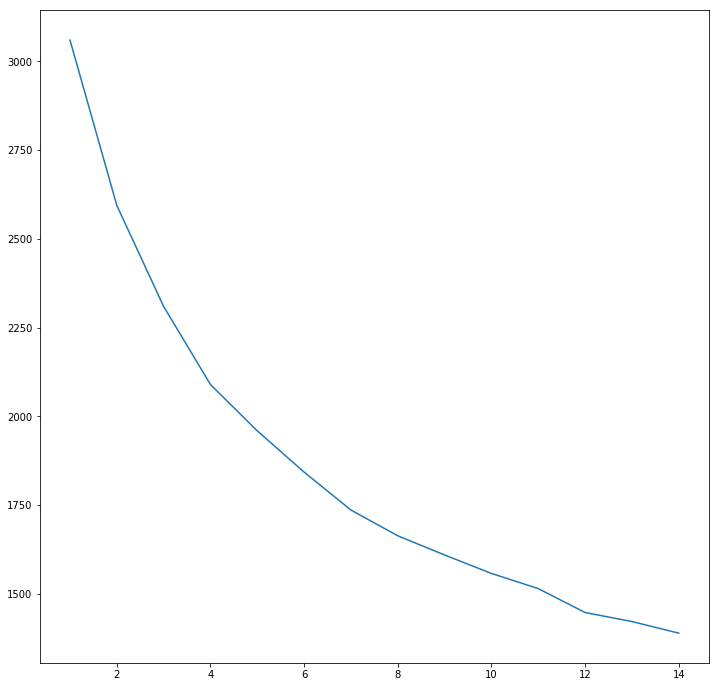

In [73]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [74]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [75]:
kmeans_ch.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [76]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [77]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [78]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.369691          -0.881824          -0.095656   
1            -0.175875          -0.403800          -0.657709   
2             0.894452          -0.189794           1.959063   
3             0.060782          -0.392075           0.826233   
4            -1.116536          -0.923742          -1.238971   
5            -1.082752          -0.067472          -1.142511   
6            -1.202528          -0.776453          -1.135820   
7            -1.206944           0.500703          -0.243295   
8            -0.982006           0.421831           0.984997   
9             1.703175           1.029234           1.508859   
10            1.528139           0.898498           0.923889   
11            0.334361          -0.301383          -0.450307   
12            0.597458           0.773201           0.182265   
13           -0.493625           1.341798          -0.632970   
14            0.962230           0.028408           0.059003   
15           -0.843247           0.160055           1.959063   
16           -0.256403           1.322075           1.520118   
17           -0.456352           2.142046           1.959063   
18           -0.637040          -1.030219          -1.165495   
19           -1.204564          -1.022455          -0.683305   
20           -1.077420          -0.314272           1.036699   
21           -0.494728          -1.023105          -0.383945   
22           -0.525116           0.187277           1.220635   
23           -0.282675           0.571926          -0.333097   
24            1.898264           1.240876           0.302806   
25            0.449834          -0.315494          -0.187659   
26           -0.745212          -0.457525          -0.261214   
27           -1.146960           2.737908           0.205319   
28           -0.006670           2.177984          -0.364684   
29           -1.198149           1.245381           1.824748   
..                 ...                ...                ...   
225          -0.850302          -0.813520          -1.238258   
226           1.113887          -0.637363          -0.178882   
227          -0.939216          -1.028651          -1.083821   
228           0.323318          -0.538560           1.959063   
229           0.651351           0.768776           1.651644   
230           1.208263           0.590562          -0.856200   
231           1.629732          -0.424079          -0.793853   
232           1.097162           0.374225          -0.897801   
233           1.452404          -0.818664           1.001952   
234           0.687938           0.363684          -0.077785   
235          -0.511818          -1.019067           1.937312   
236          -0.649452           1.110585           0.023607   
237          -0.675917           0.864345           1.959063   
238          -0.820946           0.480728          -0.348445   
239           0.335654          -0.570366           0.440736   
240           0.772849          -0.288034           0.998235   
241          -0.725775          -0.253169          -1.058923   
242          -0.883133           0.370675          -1.102573   
243          -0.504299          -0.158035          -0.129250   
244          -0.829496           0.743464           1.959063   
245          -1.203285           0.455171           0.496797   
246          -1.122600          -0.442839           1.824660   
247          -1.206944          -0.795159          -1.159900   
248          -0.501382          -1.030219          -0.612979   
249          -0.704093          -0.985145           1.199508   
250           0.831957          -0.173367           1.636565   
251          -0.895156          -1.022380          -0.410545   
252          -0.546320          -0.631883          -0.800789   
253          -0.591349          -0.947758          -0.915262   
254          -0.072947          -0.912155           0.150662   

     chromagramfiles_4  chromagramfi

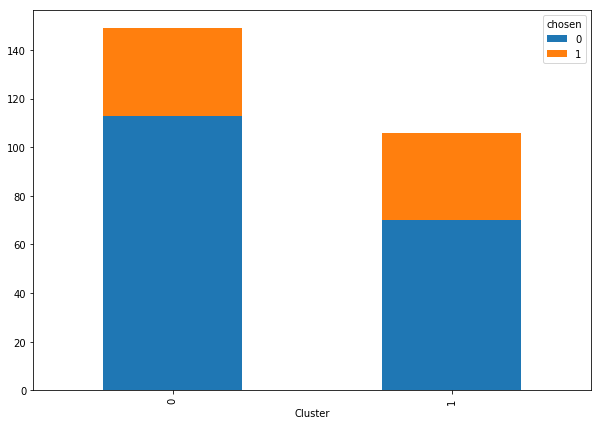

In [79]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [80]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[2]))

## Gramma

### ANN

In [435]:
X = df_n_ps_std_ch[2]

In [436]:
y = df_n_ps[2]['chosen']

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [438]:
X_train.shape

(231, 12)

In [85]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [86]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [87]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [88]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.003, 'max_iter': 100}, que permiten obtener un Accuracy de 81.39% y un Kappa del 20.50
Tiempo total: 29.47 minutos


In [439]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.003
epochs = 100

In [440]:
input_tensor = Input(shape = (n0,))

In [441]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [442]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [443]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_73 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 11        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [444]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 231 samples, validate on 78 samples
Epoch 1/100
231/231 [==============================] - 0s 805us/step - loss: 0.6917 - accuracy: 0.5714 - val_loss: 0.6342 - val_accuracy: 0.6795
Epoch 2/100
231/231 [==============================] - 0s 65us/step - loss: 0.6302 - accuracy: 0.7013 - val_loss: 0.5826 - val_accuracy: 0.7949
Epoch 3/100
231/231 [==============================] - 0s 61us/step - loss: 0.5899 - accuracy: 0.7706 - val_loss: 0.5455 - val_accuracy: 0.8205
Epoch 4/100
231/231 [==============================] - 0s 82us/step - loss: 0.5610 - accuracy: 0.7792 - val_loss: 0.5164 - val_accuracy: 0.8333
Epoch 5/100
231/231 [==============================] - 0s 78us/step - loss: 0.5344 - accuracy: 0.7965 - val_loss: 0.4901 - val_accuracy: 0.8333
Epoch 6/100
231/231 [==============================] - 0s 74us/step - loss: 0.5117 - accuracy: 0.7879 - val_loss: 0.4738 - val_accuracy: 0.8205
Epoch 7/100
231/231 [==============================] - 0s 56us/step - loss: 0.4959 - accur

231/231 [==============================] - 0s 61us/step - loss: 0.4151 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 56/100
231/231 [==============================] - 0s 61us/step - loss: 0.4149 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
Epoch 57/100
231/231 [==============================] - 0s 61us/step - loss: 0.4147 - accuracy: 0.8009 - val_loss: 0.4236 - val_accuracy: 0.8205
Epoch 58/100
231/231 [==============================] - 0s 91us/step - loss: 0.4146 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 59/100
231/231 [==============================] - 0s 61us/step - loss: 0.4145 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 60/100
231/231 [==============================] - 0s 87us/step - loss: 0.4144 - accuracy: 0.8052 - val_loss: 0.4234 - val_accuracy: 0.8205
Epoch 61/100
231/231 [==============================] - 0s 65u

range(0, 100)


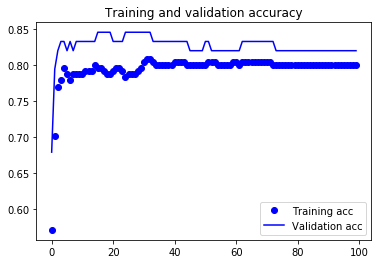

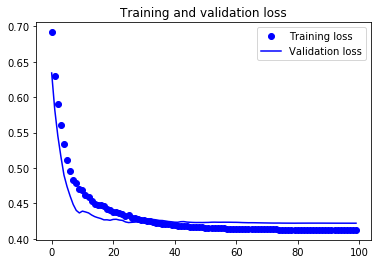

In [445]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [446]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

78/78 [==============================] - 0s 64us/step
test loss: 0.42215611384465146, test accuracy: 0.8205128312110901


In [447]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7087053571428572


In [448]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.2155172413793104


### KMeans

In [100]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.984589          -0.654155          -0.792745   
1            -0.102317           1.607758           0.006886   
2            -0.439474           2.028691          -0.353938   
3            -0.645076           0.109508          -0.651900   
4            -0.301057           0.336491           1.322422   
5            -1.259648           0.791285           0.394989   
6            -0.473744           0.544499           0.562651   
7            -0.774266           0.899101           0.080156   
8             1.984589          -0.912964           1.574884   
9             1.984589          -0.409991           1.175249   
10            1.984589          -1.189009          -0.443729   
11            1.425631          -0.405095           1.943010   
12           -0.175927          -1.348663          -0.477174   
13           -0.085508          -0.457470           0.184100   
14            0.250965           2.028690          -1.244012   
15            0.541805          -0.001425          -0.925880   
16            1.075493           1.812588          -0.957979   
17            1.162343          -1.410603           1.107861   
18           -0.350570          -0.306746           0.672887   
19            1.984589          -1.166218          -0.302121   
20           -0.344429           0.397628           0.492928   
21           -0.665123          -0.712314          -0.800151   
22           -0.034726           0.631798           1.392275   
23            1.984589          -0.007008           1.098575   
24            0.863870          -0.225984           0.529571   
25            1.984589          -0.637932           0.518394   
26           -0.534296          -0.293829          -0.533721   
27           -1.305187          -1.249514          -0.918547   
28           -0.702071           2.028691          -0.850117   
29            0.432566           0.860284          -1.227202   
..                 ...                ...                ...   
279          -1.348839           0.139880          -1.253885   
280          -0.179872           2.028690          -0.263275   
281           0.469201          -0.567649          -0.709387   
282           0.543320          -0.456381          -0.634102   
283           0.477794          -0.769583          -0.735746   
284           0.222631          -0.766506           0.927101   
285           1.911041          -1.385949           0.489432   
286           0.998963          -0.323703           1.401654   
287          -0.510470          -0.039911           1.963115   
288          -0.254650           0.178893           1.558633   
289          -0.808854          -0.341264           1.351164   
290           1.984589          -0.481795           0.508510   
291           0.998287          -0.217204           0.367127   
292           0.798451          -0.538113           1.041133   
293          -0.943702           0.737028          -0.728275   
294          -0.783173           2.028690          -0.694537   
295          -1.353539           0.236507          -1.253885   
296          -0.814494          -0.644175          -0.746555   
297          -1.328790          -0.867949          -1.235248   
298          -0.492926           0.191754           0.111709   
299          -0.170158           1.429318           0.352435   
300          -0.735769           1.192104           0.781909   
301          -0.019554           1.160350           0.498593   
302           1.400364          -1.135263          -1.004589   
303           0.689113          -1.410603          -1.223892   
304           0.922331          -1.397035          -0.464459   
305           0.750767          -0.421453          -0.860282   
306           0.961272          -0.181417          -0.598543   
307          -0.525215           1.812541          -0.767815   
308          -1.312658          -1.394783           1.272388   

     chromagramfiles_4  chromagramfi

In [101]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3708.0,
 2878.224392689417,
 2409.0313876777413,
 2245.2681343684408,
 2096.2730590487927,
 1980.9081903971983,
 1884.1812168752008,
 1782.3304172674002,
 1692.3482768291478,
 1629.7037390768492,
 1586.8745376225052,
 1530.5845891254487,
 1455.503322263105,
 1429.3496938708681]

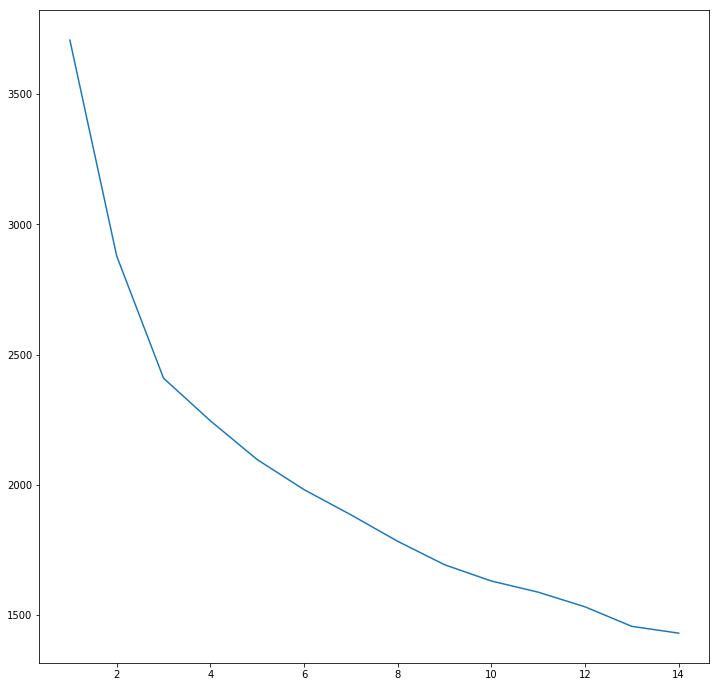

In [102]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [103]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [104]:
kmeans_ch.labels_

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [105]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [106]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [107]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.984589          -0.654155          -0.792745   
1            -0.102317           1.607758           0.006886   
2            -0.439474           2.028691          -0.353938   
3            -0.645076           0.109508          -0.651900   
4            -0.301057           0.336491           1.322422   
5            -1.259648           0.791285           0.394989   
6            -0.473744           0.544499           0.562651   
7            -0.774266           0.899101           0.080156   
8             1.984589          -0.912964           1.574884   
9             1.984589          -0.409991           1.175249   
10            1.984589          -1.189009          -0.443729   
11            1.425631          -0.405095           1.943010   
12           -0.175927          -1.348663          -0.477174   
13           -0.085508          -0.457470           0.184100   
14            0.250965           2.028690          -1.244012   
15            0.541805          -0.001425          -0.925880   
16            1.075493           1.812588          -0.957979   
17            1.162343          -1.410603           1.107861   
18           -0.350570          -0.306746           0.672887   
19            1.984589          -1.166218          -0.302121   
20           -0.344429           0.397628           0.492928   
21           -0.665123          -0.712314          -0.800151   
22           -0.034726           0.631798           1.392275   
23            1.984589          -0.007008           1.098575   
24            0.863870          -0.225984           0.529571   
25            1.984589          -0.637932           0.518394   
26           -0.534296          -0.293829          -0.533721   
27           -1.305187          -1.249514          -0.918547   
28           -0.702071           2.028691          -0.850117   
29            0.432566           0.860284          -1.227202   
..                 ...                ...                ...   
279          -1.348839           0.139880          -1.253885   
280          -0.179872           2.028690          -0.263275   
281           0.469201          -0.567649          -0.709387   
282           0.543320          -0.456381          -0.634102   
283           0.477794          -0.769583          -0.735746   
284           0.222631          -0.766506           0.927101   
285           1.911041          -1.385949           0.489432   
286           0.998963          -0.323703           1.401654   
287          -0.510470          -0.039911           1.963115   
288          -0.254650           0.178893           1.558633   
289          -0.808854          -0.341264           1.351164   
290           1.984589          -0.481795           0.508510   
291           0.998287          -0.217204           0.367127   
292           0.798451          -0.538113           1.041133   
293          -0.943702           0.737028          -0.728275   
294          -0.783173           2.028690          -0.694537   
295          -1.353539           0.236507          -1.253885   
296          -0.814494          -0.644175          -0.746555   
297          -1.328790          -0.867949          -1.235248   
298          -0.492926           0.191754           0.111709   
299          -0.170158           1.429318           0.352435   
300          -0.735769           1.192104           0.781909   
301          -0.019554           1.160350           0.498593   
302           1.400364          -1.135263          -1.004589   
303           0.689113          -1.410603          -1.223892   
304           0.922331          -1.397035          -0.464459   
305           0.750767          -0.421453          -0.860282   
306           0.961272          -0.181417          -0.598543   
307          -0.525215           1.812541          -0.767815   
308          -1.312658          -1.394783           1.272388   

     chromagramfiles_4  chromagramfi

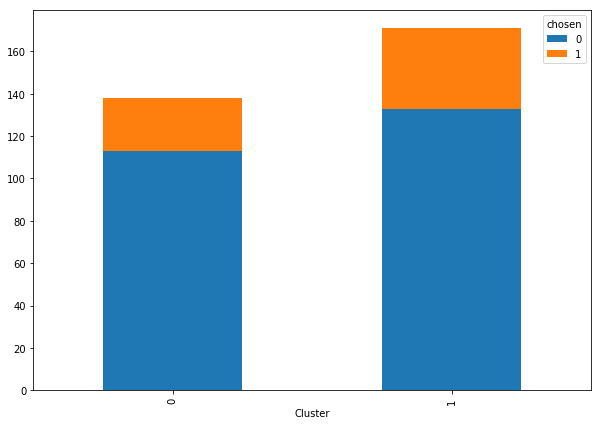

In [108]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [109]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[3]))

## Hotel Marrakech

### ANN

In [449]:
X = df_n_ps_std_ch[3]

In [450]:
y = df_n_ps[3]['chosen']

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [452]:
X_train.shape

(139, 12)

In [114]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [115]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [116]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [117]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30, 20, 10), 'learning_rate_init': 0.005, 'max_iter': 400}, que permiten obtener un Accuracy de 74.82% y un Kappa del 36.52
Tiempo total: 20.79 minutos


In [453]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.005
epochs = 400

In [454]:
input_tensor = Input(shape = (n0,))

In [455]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [456]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [457]:
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_76 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_77 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 11        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [458]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 139 samples, validate on 47 samples
Epoch 1/400
139/139 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5612 - val_loss: 0.6643 - val_accuracy: 0.6596
Epoch 2/400
139/139 [==============================] - 0s 101us/step - loss: 0.6139 - accuracy: 0.6978 - val_loss: 0.6457 - val_accuracy: 0.5745
Epoch 3/400
139/139 [==============================] - 0s 86us/step - loss: 0.5802 - accuracy: 0.7050 - val_loss: 0.6362 - val_accuracy: 0.6383
Epoch 4/400
139/139 [==============================] - 0s 79us/step - loss: 0.5585 - accuracy: 0.7050 - val_loss: 0.6262 - val_accuracy: 0.6809
Epoch 5/400
139/139 [==============================] - 0s 79us/step - loss: 0.5379 - accuracy: 0.7266 - val_loss: 0.6363 - val_accuracy: 0.7234
Epoch 6/400
139/139 [==============================] - 0s 86us/step - loss: 0.5218 - accuracy: 0.7554 - val_loss: 0.6389 - val_accuracy: 0.7021
Epoch 7/400
139/139 [==============================] - 0s 72us/step - loss: 0.5042 - accura

Epoch 55/400
139/139 [==============================] - 0s 86us/step - loss: 0.2026 - accuracy: 0.9496 - val_loss: 0.7387 - val_accuracy: 0.6596

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 56/400
139/139 [==============================] - 0s 108us/step - loss: 0.2014 - accuracy: 0.9496 - val_loss: 0.7387 - val_accuracy: 0.6596
Epoch 57/400
139/139 [==============================] - 0s 115us/step - loss: 0.2007 - accuracy: 0.9496 - val_loss: 0.7393 - val_accuracy: 0.6596
Epoch 58/400
139/139 [==============================] - 0s 101us/step - loss: 0.2001 - accuracy: 0.9496 - val_loss: 0.7398 - val_accuracy: 0.6596
Epoch 59/400
139/139 [==============================] - 0s 86us/step - loss: 0.1997 - accuracy: 0.9496 - val_loss: 0.7410 - val_accuracy: 0.6596
Epoch 60/400
139/139 [==============================] - 0s 86us/step - loss: 0.1991 - accuracy: 0.9496 - val_loss: 0.7421 - val_accuracy: 0.6596
Epoch 61/400
139/139 [=======================

139/139 [==============================] - 0s 79us/step - loss: 0.1909 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 109/400
139/139 [==============================] - 0s 79us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 110/400
139/139 [==============================] - 0s 79us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 111/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 112/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 113/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 114/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy:

139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 162/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 163/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 164/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 165/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00165: ReduceLROnPlateau reducing learning rate to 7.629394360719743e-08.
Epoch 166/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 167/400
139/139 [==============================] - 

139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 215/400
139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00215: ReduceLROnPlateau reducing learning rate to 2.38418573772492e-09.
Epoch 216/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 217/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 218/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 219/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 220/400
139/139 [==============================] - 0

Epoch 267/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 268/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 269/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 270/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 271/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 272/400
139/139 [==============================] - 0s 101us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 273/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 

139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 321/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 322/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 323/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 324/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 325/400
139/139 [==============================] - 0s 108us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00325: ReduceLROnPlateau reducing learning rate to 1.164153192248496e-12.
Epoch 326/400
139/139 [==============================] -

139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 374/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 375/400
139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00375: ReduceLROnPlateau reducing learning rate to 3.63797872577655e-14.
Epoch 376/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 377/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 378/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 379/400
139/139 [==============================] - 0

range(0, 400)


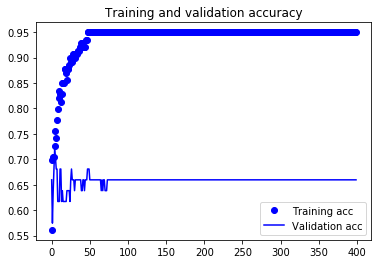

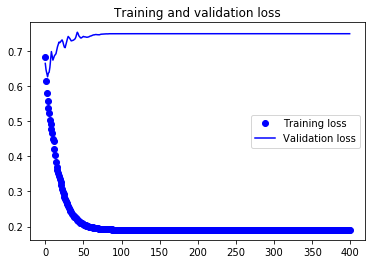

In [459]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [460]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

47/47 [==============================] - 0s 85us/step
test loss: 0.7487381544518978, test accuracy: 0.6595744490623474


In [461]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.6145833333333334


In [462]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.15695067264573992


### KMeans

In [128]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.599304          -1.060396           0.465659   
1            -0.906389           1.573440           1.673148   
2            -0.149325           0.716481          -1.280822   
3            -0.569330           0.172306          -1.126575   
4            -1.256063          -0.200780          -1.280822   
5             1.498382           0.070778           1.241647   
6             1.498381          -0.356738           0.435175   
7            -1.119602           2.289616           0.868130   
8             1.498382           0.306863          -0.233871   
9            -0.564178           0.625076          -0.818535   
10           -0.778882           1.298999           1.673148   
11           -0.644689           1.907389           0.724477   
12           -0.726607           0.659282           1.063080   
13            0.038859           1.272019          -0.111205   
14           -1.028647           1.835461           0.117175   
15           -1.170073          -1.108093           1.429803   
16            0.568533           0.319544           0.717878   
17            0.818260          -0.108057           1.673148   
18           -1.346310          -1.140106          -1.280822   
19            1.250159          -1.050602          -1.222878   
20            0.572797           2.142771           1.581524   
21            0.862369           2.221963           1.673148   
22            1.498382          -0.404560           0.195068   
23           -1.364025           1.371234           1.673148   
24            1.498382          -0.141656           1.241642   
25            1.498382          -0.280382           1.532544   
26            1.075665          -0.107428           1.673148   
27            0.540581           0.054204           0.505362   
28           -0.980545          -1.054168          -1.263653   
29           -0.441960           1.036991          -0.878755   
..                 ...                ...                ...   
156           0.964566          -0.478675           0.600961   
157           0.270654           0.971091           0.132712   
158           0.388178          -0.776533          -1.121244   
159          -0.409488          -0.518845          -0.902126   
160          -1.188703          -0.210659          -0.626345   
161          -1.476495          -1.140106          -1.266686   
162          -1.075963          -1.140106           0.768537   
163          -1.142157          -1.140106          -0.917613   
164          -0.756762          -0.149815           1.673148   
165           0.429405          -0.093236           1.263826   
166           0.553018          -0.191462           1.673148   
167           0.997841           1.111726           1.673148   
168           1.281068           0.266174           0.446982   
169           0.013523          -0.761110          -1.031584   
170           0.666873          -0.889641           1.409534   
171          -0.179155          -0.647105           1.673148   
172          -0.698104          -1.140106           1.673147   
173          -0.221070          -1.120261           0.098266   
174          -0.987264          -1.140106           1.430551   
175          -0.001472           2.289616          -0.469230   
176           0.759267           2.289616          -0.807487   
177           0.303330           1.071917           0.410221   
178           0.371415           0.428878          -0.437216   
179          -1.106214           0.339351          -0.739020   
180           0.970965           1.730559           1.300739   
181          -1.092848          -1.140019          -1.014068   
182          -0.432669          -1.140106          -1.275255   
183          -1.222408          -1.109984           0.115563   
184           1.498382           0.114899           0.573155   
185          -0.252632          -0.228432          -0.156977   

     chromagramfiles_4  chromagramfi

In [129]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2232.0,
 1887.86126663073,
 1710.7260050049272,
 1558.3692212048186,
 1444.9563111647813,
 1360.8980768251936,
 1285.0938986929364,
 1227.1073156803282,
 1175.9593811616949,
 1123.763719209633,
 1080.6180773747733,
 1058.1006766601422,
 1021.9523094285516,
 986.031006954783]

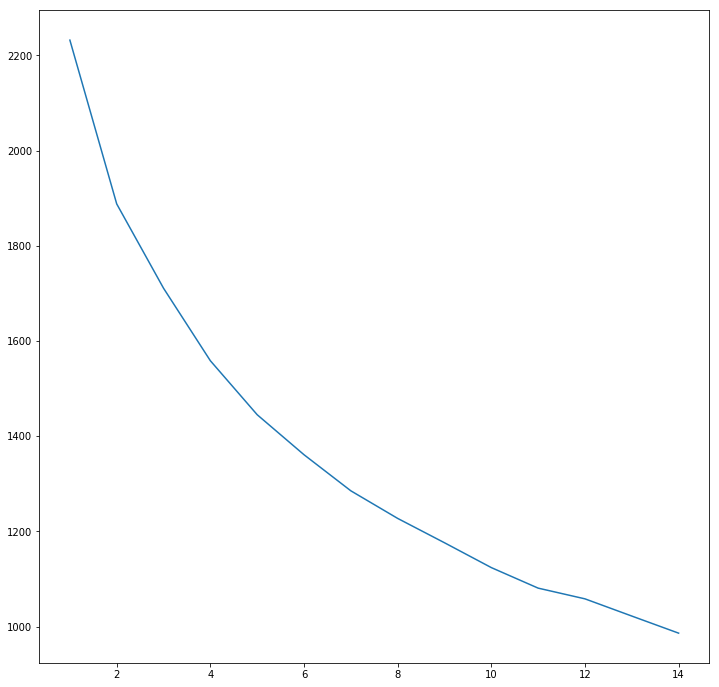

In [130]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [131]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [132]:
kmeans_ch.labels_

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [133]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [134]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [135]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.599304          -1.060396           0.465659   
1            -0.906389           1.573440           1.673148   
2            -0.149325           0.716481          -1.280822   
3            -0.569330           0.172306          -1.126575   
4            -1.256063          -0.200780          -1.280822   
5             1.498382           0.070778           1.241647   
6             1.498381          -0.356738           0.435175   
7            -1.119602           2.289616           0.868130   
8             1.498382           0.306863          -0.233871   
9            -0.564178           0.625076          -0.818535   
10           -0.778882           1.298999           1.673148   
11           -0.644689           1.907389           0.724477   
12           -0.726607           0.659282           1.063080   
13            0.038859           1.272019          -0.111205   
14           -1.028647           1.835461           0.117175   
15           -1.170073          -1.108093           1.429803   
16            0.568533           0.319544           0.717878   
17            0.818260          -0.108057           1.673148   
18           -1.346310          -1.140106          -1.280822   
19            1.250159          -1.050602          -1.222878   
20            0.572797           2.142771           1.581524   
21            0.862369           2.221963           1.673148   
22            1.498382          -0.404560           0.195068   
23           -1.364025           1.371234           1.673148   
24            1.498382          -0.141656           1.241642   
25            1.498382          -0.280382           1.532544   
26            1.075665          -0.107428           1.673148   
27            0.540581           0.054204           0.505362   
28           -0.980545          -1.054168          -1.263653   
29           -0.441960           1.036991          -0.878755   
..                 ...                ...                ...   
156           0.964566          -0.478675           0.600961   
157           0.270654           0.971091           0.132712   
158           0.388178          -0.776533          -1.121244   
159          -0.409488          -0.518845          -0.902126   
160          -1.188703          -0.210659          -0.626345   
161          -1.476495          -1.140106          -1.266686   
162          -1.075963          -1.140106           0.768537   
163          -1.142157          -1.140106          -0.917613   
164          -0.756762          -0.149815           1.673148   
165           0.429405          -0.093236           1.263826   
166           0.553018          -0.191462           1.673148   
167           0.997841           1.111726           1.673148   
168           1.281068           0.266174           0.446982   
169           0.013523          -0.761110          -1.031584   
170           0.666873          -0.889641           1.409534   
171          -0.179155          -0.647105           1.673148   
172          -0.698104          -1.140106           1.673147   
173          -0.221070          -1.120261           0.098266   
174          -0.987264          -1.140106           1.430551   
175          -0.001472           2.289616          -0.469230   
176           0.759267           2.289616          -0.807487   
177           0.303330           1.071917           0.410221   
178           0.371415           0.428878          -0.437216   
179          -1.106214           0.339351          -0.739020   
180           0.970965           1.730559           1.300739   
181          -1.092848          -1.140019          -1.014068   
182          -0.432669          -1.140106          -1.275255   
183          -1.222408          -1.109984           0.115563   
184           1.498382           0.114899           0.573155   
185          -0.252632          -0.228432          -0.156977   

     chromagramfiles_4  chromagramfi

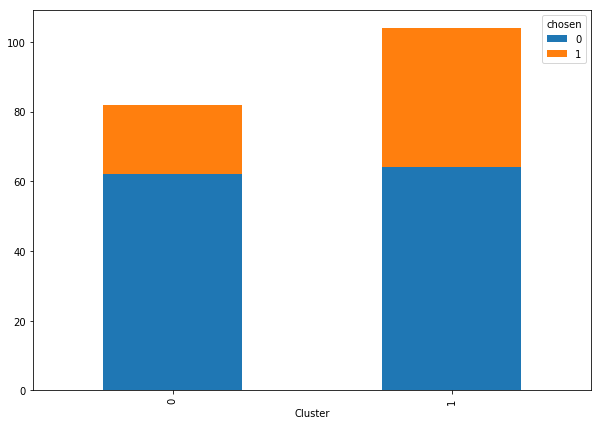

In [136]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [137]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[4]))

## Specialized

### ANN

In [463]:
X = df_n_ps_std_ch[4]

In [464]:
y = df_n_ps[4]['chosen']

In [465]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [466]:
X_train.shape

(164, 12)

In [142]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [143]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [144]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [145]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.001, 'max_iter': 500}, que permiten obtener un Accuracy de 64.63% y un Kappa del 27.16
Tiempo total: 22.23 minutos


In [467]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.001
epochs = 500

In [468]:
input_tensor = Input(shape = (n0,))

In [469]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [470]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [471]:
model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_80 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [472]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 164 samples, validate on 55 samples
Epoch 1/500
164/164 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.5488 - val_loss: 0.6907 - val_accuracy: 0.5455
Epoch 2/500
164/164 [==============================] - 0s 110us/step - loss: 0.7152 - accuracy: 0.5732 - val_loss: 0.6766 - val_accuracy: 0.5636
Epoch 3/500
164/164 [==============================] - 0s 79us/step - loss: 0.7022 - accuracy: 0.5610 - val_loss: 0.6723 - val_accuracy: 0.5636
Epoch 4/500
164/164 [==============================] - 0s 73us/step - loss: 0.6954 - accuracy: 0.5549 - val_loss: 0.6718 - val_accuracy: 0.5818
Epoch 5/500
164/164 [==============================] - 0s 85us/step - loss: 0.6887 - accuracy: 0.5549 - val_loss: 0.6672 - val_accuracy: 0.5818
Epoch 6/500
164/164 [==============================] - 0s 79us/step - loss: 0.6837 - accuracy: 0.5671 - val_loss: 0.6599 - val_accuracy: 0.6000
Epoch 7/500
164/164 [==============================] - 0s 79us/step - loss: 0.6786 - accura

164/164 [==============================] - 0s 61us/step - loss: 0.6253 - accuracy: 0.6159 - val_loss: 0.6192 - val_accuracy: 0.6727
Epoch 56/500
164/164 [==============================] - 0s 61us/step - loss: 0.6251 - accuracy: 0.6159 - val_loss: 0.6195 - val_accuracy: 0.6364

Epoch 00056: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 57/500
164/164 [==============================] - 0s 73us/step - loss: 0.6249 - accuracy: 0.6098 - val_loss: 0.6194 - val_accuracy: 0.6364
Epoch 58/500
164/164 [==============================] - 0s 85us/step - loss: 0.6249 - accuracy: 0.6098 - val_loss: 0.6195 - val_accuracy: 0.6545
Epoch 59/500
164/164 [==============================] - 0s 116us/step - loss: 0.6247 - accuracy: 0.6098 - val_loss: 0.6194 - val_accuracy: 0.6545
Epoch 60/500
164/164 [==============================] - 0s 85us/step - loss: 0.6246 - accuracy: 0.6098 - val_loss: 0.6194 - val_accuracy: 0.6545
Epoch 61/500
164/164 [==============================] - 0s 79u

164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 109/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 110/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 111/500
164/164 [==============================] - 0s 91us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 112/500
164/164 [==============================] - 0s 85us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 113/500
164/164 [==============================] - 0s 85us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 114/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy:

164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 162/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 163/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 164/500
164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 165/500
164/164 [==============================] - 0s 98us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 166/500
164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00166: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
Epoch 167/500
164/164 [==============================] - 

164/164 [==============================] - 0s 97us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 215/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 216/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00216: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
Epoch 217/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 218/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 219/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 220/500
164/164 [==============================] - 

164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 268/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 269/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 270/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 271/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 272/500
164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 273/500
164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy:

164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 321/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 322/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 323/500
164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 324/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 325/500
164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 326/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy:

164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 374/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 375/500
164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 376/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00376: ReduceLROnPlateau reducing learning rate to 1.4551915919545737e-14.
Epoch 377/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 378/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 379/500
164/164 [==============================] -

164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00426: ReduceLROnPlateau reducing learning rate to 4.547473724858043e-16.
Epoch 427/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 428/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 429/500
164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 430/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 431/500
164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 432/500
164/164 [==============================] - 

Epoch 479/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 480/500
164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 481/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 482/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 483/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 484/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 485/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 -

range(0, 500)


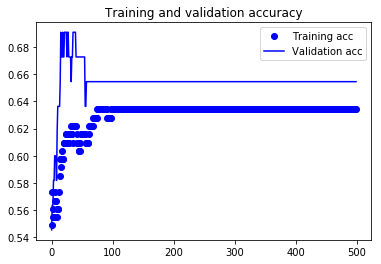

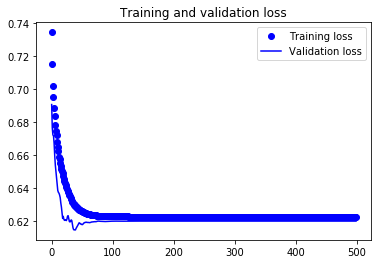

In [473]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [474]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

55/55 [==============================] - 0s 55us/step
test loss: 0.6201585899699819, test accuracy: 0.6545454263687134


In [475]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7365591397849462


In [476]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.2943956785955435


### KMeans

In [156]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.752761          -1.114598          -0.348132   
1            -1.387006          -0.333039           0.041297   
2            -0.628834           2.234144           0.613536   
3             0.081693           1.765530          -0.365668   
4             0.056206           1.646501           0.508800   
5            -0.475284           0.673200          -1.077774   
6             0.163433          -0.011304          -1.057752   
7             0.110500           0.178211          -1.394026   
8             0.595793          -0.898440           1.924099   
9            -0.017542          -1.386211           0.574605   
10            0.796579          -1.216664          -0.112327   
11            1.761253          -0.949116          -0.297777   
12            1.055147          -0.394702           1.258031   
13            1.761253          -0.435392           0.592085   
14           -0.137413          -0.980041          -1.297302   
15            0.017749          -0.936126          -1.136240   
16           -0.382429          -1.386211          -1.437693   
17           -1.227998           1.294887           2.200026   
18           -1.076569          -0.776099          -0.576736   
19           -1.180746           0.385053           2.200026   
20            1.192498          -0.224351          -0.206238   
21            1.213472           0.048184          -0.600330   
22           -0.004572          -0.052026           2.200026   
23           -0.229893           0.630662           0.484895   
24            0.217943          -0.177066           0.659322   
25           -0.333597           0.972324          -0.721724   
26           -0.602430          -0.028610          -0.826715   
27           -0.251812          -0.171571          -0.358821   
28           -0.368678           2.234146          -0.330756   
29           -0.578621           2.234146          -0.562376   
..                 ...                ...                ...   
189          -0.186741          -1.165084          -0.921181   
190          -0.163966           0.884601           1.657605   
191          -0.254097          -0.617571           0.535718   
192          -1.359431           0.228998           0.259367   
193           1.622617           2.234146          -1.127605   
194          -0.467818          -0.314482           0.014154   
195          -1.423661          -0.599038          -0.707969   
196           1.761253          -0.325612           0.357954   
197           1.761253           1.028574           1.374947   
198           1.761253           0.050043           0.687757   
199          -0.919189          -0.200271          -1.032880   
200          -0.988568          -0.189392          -1.028379   
201          -0.779270           0.427427          -0.948100   
202           1.116127          -1.139042           0.168460   
203           0.762440          -1.190866          -0.050517   
204           0.058411          -1.128496          -1.328850   
205          -0.720270          -0.697672          -0.720394   
206          -0.364461          -0.010160          -1.095500   
207          -0.272236          -0.196860          -0.727982   
208           1.761253          -0.082523          -0.122308   
209           1.573516          -0.161473          -0.359909   
210           1.761253           0.417875          -0.918851   
211           1.761253           0.145550           1.710575   
212           0.470346          -0.334996           2.200026   
213          -0.576457          -0.914445           1.070087   
214           1.761253          -0.591066          -0.690824   
215           1.490806          -1.368871          -1.151960   
216           0.191801          -1.348512          -1.315236   
217          -0.002098           2.039653          -0.752917   
218          -0.098688          -0.923087          -0.917548   

     chromagramfiles_4  chromagramfi

In [157]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2628.0,
 2183.3505259693475,
 1946.7709026205612,
 1764.2381744586387,
 1667.52081260375,
 1588.695626080069,
 1521.6546082793252,
 1465.3583612489235,
 1381.9950671234758,
 1338.0035802619554,
 1275.054416118868,
 1244.4334212962274,
 1201.2393010186188,
 1166.7934845697623]

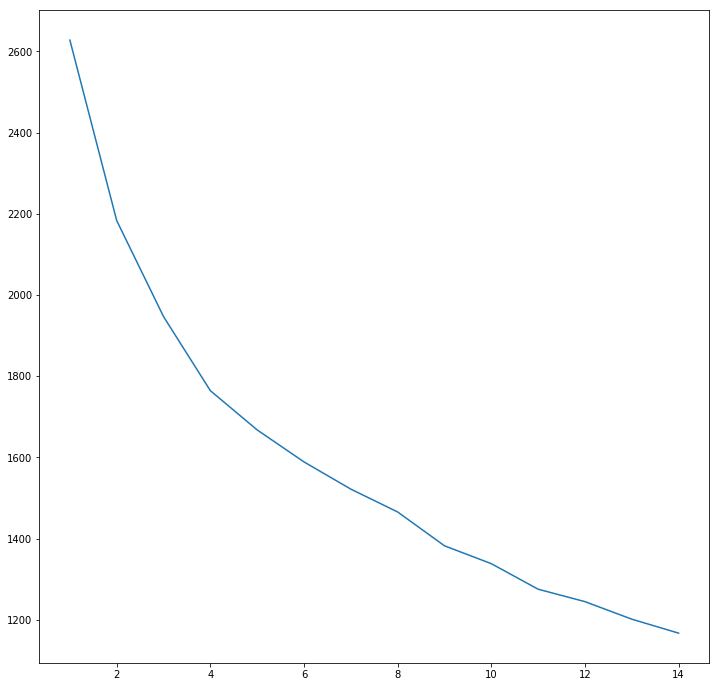

In [158]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [159]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [160]:
kmeans_ch.labels_

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [161]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [162]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [163]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.752761          -1.114598          -0.348132   
1            -1.387006          -0.333039           0.041297   
2            -0.628834           2.234144           0.613536   
3             0.081693           1.765530          -0.365668   
4             0.056206           1.646501           0.508800   
5            -0.475284           0.673200          -1.077774   
6             0.163433          -0.011304          -1.057752   
7             0.110500           0.178211          -1.394026   
8             0.595793          -0.898440           1.924099   
9            -0.017542          -1.386211           0.574605   
10            0.796579          -1.216664          -0.112327   
11            1.761253          -0.949116          -0.297777   
12            1.055147          -0.394702           1.258031   
13            1.761253          -0.435392           0.592085   
14           -0.137413          -0.980041          -1.297302   
15            0.017749          -0.936126          -1.136240   
16           -0.382429          -1.386211          -1.437693   
17           -1.227998           1.294887           2.200026   
18           -1.076569          -0.776099          -0.576736   
19           -1.180746           0.385053           2.200026   
20            1.192498          -0.224351          -0.206238   
21            1.213472           0.048184          -0.600330   
22           -0.004572          -0.052026           2.200026   
23           -0.229893           0.630662           0.484895   
24            0.217943          -0.177066           0.659322   
25           -0.333597           0.972324          -0.721724   
26           -0.602430          -0.028610          -0.826715   
27           -0.251812          -0.171571          -0.358821   
28           -0.368678           2.234146          -0.330756   
29           -0.578621           2.234146          -0.562376   
..                 ...                ...                ...   
189          -0.186741          -1.165084          -0.921181   
190          -0.163966           0.884601           1.657605   
191          -0.254097          -0.617571           0.535718   
192          -1.359431           0.228998           0.259367   
193           1.622617           2.234146          -1.127605   
194          -0.467818          -0.314482           0.014154   
195          -1.423661          -0.599038          -0.707969   
196           1.761253          -0.325612           0.357954   
197           1.761253           1.028574           1.374947   
198           1.761253           0.050043           0.687757   
199          -0.919189          -0.200271          -1.032880   
200          -0.988568          -0.189392          -1.028379   
201          -0.779270           0.427427          -0.948100   
202           1.116127          -1.139042           0.168460   
203           0.762440          -1.190866          -0.050517   
204           0.058411          -1.128496          -1.328850   
205          -0.720270          -0.697672          -0.720394   
206          -0.364461          -0.010160          -1.095500   
207          -0.272236          -0.196860          -0.727982   
208           1.761253          -0.082523          -0.122308   
209           1.573516          -0.161473          -0.359909   
210           1.761253           0.417875          -0.918851   
211           1.761253           0.145550           1.710575   
212           0.470346          -0.334996           2.200026   
213          -0.576457          -0.914445           1.070087   
214           1.761253          -0.591066          -0.690824   
215           1.490806          -1.368871          -1.151960   
216           0.191801          -1.348512          -1.315236   
217          -0.002098           2.039653          -0.752917   
218          -0.098688          -0.923087          -0.917548   

     chromagramfiles_4  chromagramfi

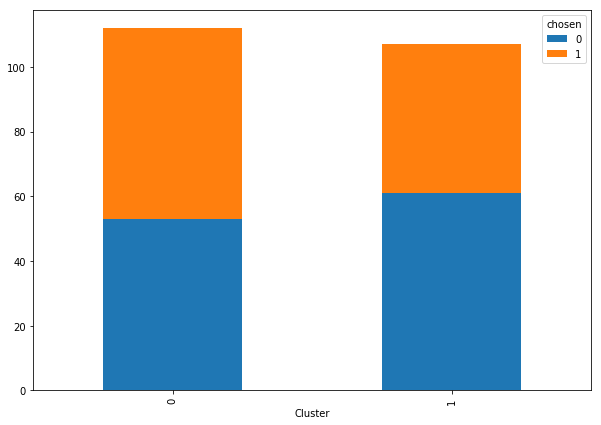

In [164]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [165]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[5]))

## Urban Place

### ANN

In [477]:
X = df_n_ps_std_ch[5]

In [478]:
y = df_n_ps[5]['chosen']

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [480]:
X_train.shape

(168, 12)

In [170]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [171]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [172]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [173]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.004, 'max_iter': 100}, que permiten obtener un Accuracy de 77.98% y un Kappa del 46.34
Tiempo total: 26.27 minutos


In [481]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr =0.004
epochs = 100

In [482]:
input_tensor = Input(shape = (n0,))

In [483]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [484]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [485]:
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 21        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [486]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 168 samples, validate on 57 samples
Epoch 1/100
168/168 [==============================] - 0s 1ms/step - loss: 0.8058 - accuracy: 0.5119 - val_loss: 0.6882 - val_accuracy: 0.6140
Epoch 2/100
168/168 [==============================] - 0s 101us/step - loss: 0.7272 - accuracy: 0.5298 - val_loss: 0.6497 - val_accuracy: 0.6316
Epoch 3/100
168/168 [==============================] - 0s 89us/step - loss: 0.6829 - accuracy: 0.5536 - val_loss: 0.6268 - val_accuracy: 0.6316
Epoch 4/100
168/168 [==============================] - 0s 101us/step - loss: 0.6512 - accuracy: 0.6012 - val_loss: 0.5988 - val_accuracy: 0.6667
Epoch 5/100
168/168 [==============================] - 0s 83us/step - loss: 0.6359 - accuracy: 0.6369 - val_loss: 0.5762 - val_accuracy: 0.6491
Epoch 6/100
168/168 [==============================] - 0s 71us/step - loss: 0.6232 - accuracy: 0.6488 - val_loss: 0.5670 - val_accuracy: 0.6667
Epoch 7/100
168/168 [==============================] - 0s 77us/step - loss: 0.6153 - accur

168/168 [==============================] - 0s 71us/step - loss: 0.5024 - accuracy: 0.7440 - val_loss: 0.4769 - val_accuracy: 0.7368
Epoch 56/100
168/168 [==============================] - 0s 77us/step - loss: 0.5020 - accuracy: 0.7440 - val_loss: 0.4774 - val_accuracy: 0.7368
Epoch 57/100
168/168 [==============================] - 0s 71us/step - loss: 0.5016 - accuracy: 0.7440 - val_loss: 0.4769 - val_accuracy: 0.7368
Epoch 58/100
168/168 [==============================] - 0s 65us/step - loss: 0.5012 - accuracy: 0.7440 - val_loss: 0.4766 - val_accuracy: 0.7368

Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 59/100
168/168 [==============================] - 0s 77us/step - loss: 0.5007 - accuracy: 0.7440 - val_loss: 0.4767 - val_accuracy: 0.7368
Epoch 60/100
168/168 [==============================] - 0s 83us/step - loss: 0.5005 - accuracy: 0.7440 - val_loss: 0.4769 - val_accuracy: 0.7368
Epoch 61/100
168/168 [==============================] - 0s 83u

range(0, 100)


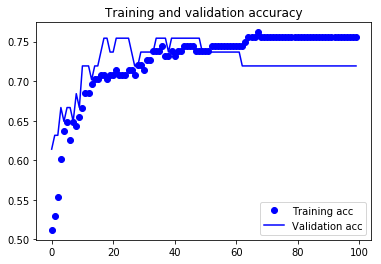

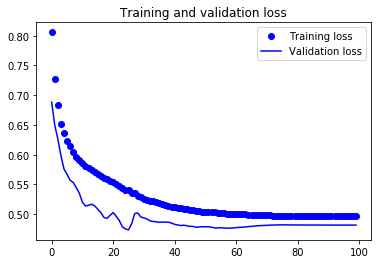

In [487]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [488]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

57/57 [==============================] - 0s 70us/step
test loss: 0.48182071510114166, test accuracy: 0.719298243522644


In [489]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.773015873015873


In [490]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.24378109452736318


### KMeans

In [66]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

In [67]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3315.0,
 2972.7888695817974,
 2748.18187155972,
 2544.9420084212106,
 2413.687059384553,
 2278.037996783226,
 2213.3487507256823,
 2123.4282707474663,
 2067.8299633414163,
 1977.777252698108,
 1956.5229777214513,
 1880.0296166971755,
 1815.5096049846275,
 1785.9955747862728]

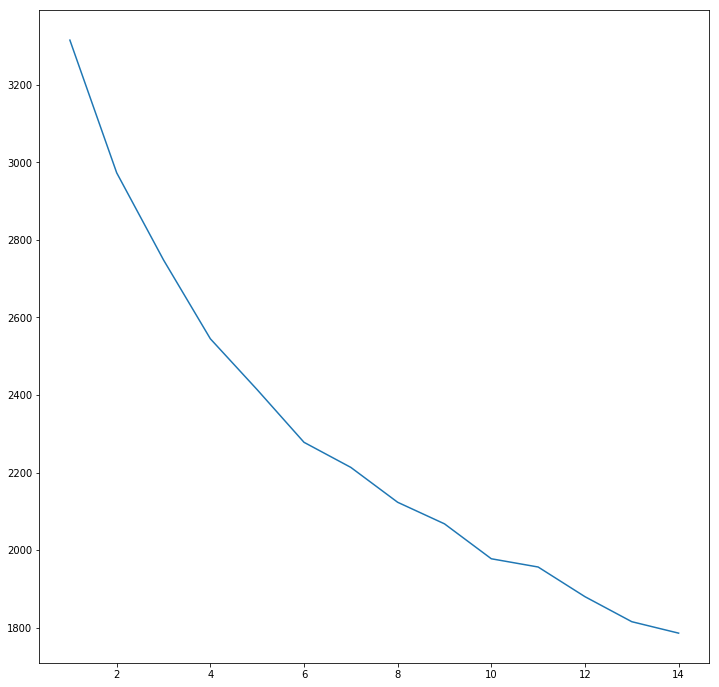

In [68]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=6

In [69]:
kmeans_ch = KMeans(n_clusters=6, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [70]:
kmeans_ch.labels_

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [71]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [72]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [73]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

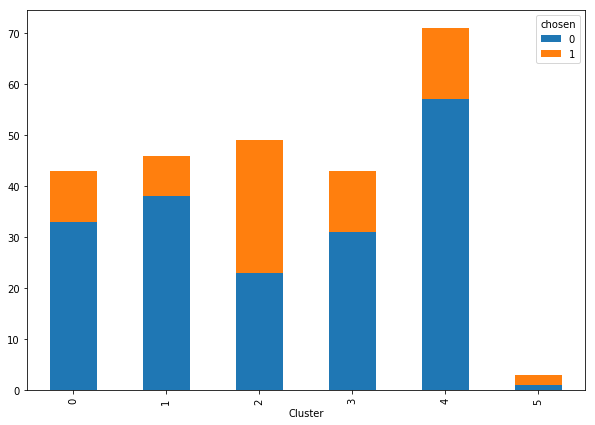

In [74]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

# Random Forest

## Arte Francés

In [513]:
X = df_n_ps[0].iloc[:,8:-1]
y = df_n_ps[0]['chosen']
X_train, X_test, y_train, y_test = train_test_split(X, y)

NameError: name 'ctree' is not defined

In [516]:
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
np.random.seed(1234)
ctree = tree.DecisionTreeClassifier(
    criterion='entropy', # el criterio de particionamiento de un conjunto de datos (gini, entropy)
    max_depth=None,      # prepoda: controla la profundidad del árbol (largo máximo de las ramas)
    min_samples_split=2, # prepoda: el mínimo número de registros necesarios para crear una nueva rama
    min_samples_leaf=1,  # prepoda: el mínimo número de registros en una hoja
    random_state=None,   # semilla del generador aleatorio utilizado para 
    max_leaf_nodes=None, # prepoda: máximo número de nodos hojas
    min_impurity_decrease=0.0, # prepoda: umbral mínimo de reducción de la impureza para aceptar la creación de una rama
    class_weight=None    # permite asociar pesos a las clases, en el caso de diferencias de importancia entre ellas
)
ctree.fit(X_train, y_train)
y_pred = ctree.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
print("Exactitud: ", accuracy_score(y_test, y_pred))
print("Kappa    : ", cohen_kappa_score(y_test, y_pred))
cm

Exactitud:  0.7634408602150538
Kappa    :  0.44067796610169496


array([[54, 14],
       [ 8, 17]], dtype=int64)

In [518]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1234)
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
cm= confusion_matrix(y_test, y_pred)
print("Exactitud: ", accuracy_score(y_test, y_pred))
print("Kappa    : ", cohen_kappa_score(y_test, y_pred))
cm

Exactitud:  0.7419354838709677
Kappa    :  0.09046454767726175


array([[67,  1],
       [23,  2]], dtype=int64)

In [521]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0], dtype=int64)

In [500]:
rforest.oob_score_

0.7777777777777778

In [501]:
X.columns[np.argsort(-rforest.feature_importances_)]

Index(['durationfiles', 'mfccfiles_13', 'pitchfiles', 'inharmonicityfiles',
       'bestkeyfiles', 'keyclarityfiles', 'modalityfiles',
       'tonalcentroidfiles_1', 'tonalcentroidfiles_2', 'tonalcentroidfiles_3',
       'tonalcentroidfiles_4', 'tonalcentroidfiles_5', 'mfccfiles_12',
       'tonalcentroidfiles_6', 'chromagramfiles_2', 'chromagramfiles_3',
       'chromagramfiles_4', 'chromagramfiles_5', 'chromagramfiles_6',
       'chromagramfiles_7', 'chromagramfiles_8', 'chromagramfiles_9',
       'chromagramfiles_10', 'chromagramfiles_11', 'chromagramfiles_12',
       'chromagramfiles_1', 'mfccfiles_11', 'mfccfiles_10', 'mfccfiles_9',
       'bitratefiles', 'rmsfiles', 'rmsmedianfiles', 'lowenergyfiles',
       'ASRfiles', 'beatspectrumfiles', 'eventdensityfiles', 'tempofiles',
       'pulseclarityfiles', 'zerocrossfiles', 'rolloffsfiles',
       'brightnessfiles', 'spreadfiles', 'centroidfiles', 'kurtosisfiles',
       'flatnessfiles', 'entropyfiles', 'mfccfiles_1', 'mfccfiles_2',


In [505]:
-rforest.feature_importances_

array([-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.,
       -0., -0., -0., -0.])

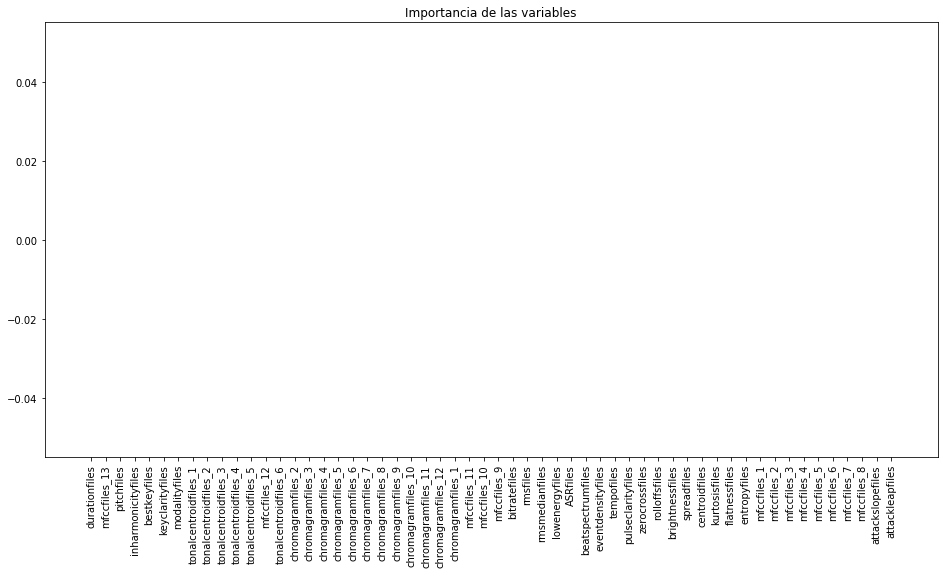

In [502]:
indices = np.argsort(-rforest.feature_importances_)#[::-1]
variables = [X.columns[i] for i in indices]
plt.figure(figsize=(16,8))
plt.title("Importancia de las variables")
plt.bar(range(X.shape[1]), rforest.feature_importances_[indices])
plt.xticks(range(X.shape[1]), variables, rotation=90)
plt.show()

### ANN

In [407]:
X = df_n_ps_std_ch[0]

In [408]:
y = df_n_ps[0]['chosen']

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [410]:
X_train.shape

(279, 12)

In [24]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [25]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [26]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [27]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (30, 30, 30), 'learning_rate_init': 0.008, 'max_iter': 100}, que permiten obtener un Accuracy de 78.49% y un Kappa del 30.33
Tiempo total: 23.83 minutos


In [411]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,30,30]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.008
epochs = 100

In [412]:
input_tensor = Input(shape = (n0,))

In [413]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [414]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [415]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_67 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_68 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 31        
Total params: 2,281
Trainable params: 2,281
Non-trainable params: 0
_________________________________________________________________


In [416]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 279 samples, validate on 93 samples
Epoch 1/100
279/279 [==============================] - 0s 792us/step - loss: 0.6389 - accuracy: 0.6452 - val_loss: 0.5521 - val_accuracy: 0.6882
Epoch 2/100
279/279 [==============================] - 0s 68us/step - loss: 0.5409 - accuracy: 0.7384 - val_loss: 0.5195 - val_accuracy: 0.7742
Epoch 3/100
279/279 [==============================] - 0s 54us/step - loss: 0.5159 - accuracy: 0.7634 - val_loss: 0.5163 - val_accuracy: 0.7742
Epoch 4/100
279/279 [==============================] - 0s 61us/step - loss: 0.4912 - accuracy: 0.7634 - val_loss: 0.5340 - val_accuracy: 0.7849
Epoch 5/100
279/279 [==============================] - 0s 57us/step - loss: 0.4777 - accuracy: 0.7706 - val_loss: 0.5239 - val_accuracy: 0.7634
Epoch 6/100
279/279 [==============================] - 0s 57us/step - loss: 0.4586 - accuracy: 0.7742 - val_loss: 0.5071 - val_accuracy: 0.7634
Epoch 7/100
279/279 [==============================] - 0s 57us/step - loss: 0.4379 - accur

279/279 [==============================] - 0s 61us/step - loss: 0.0223 - accuracy: 0.9964 - val_loss: 0.9178 - val_accuracy: 0.7742
Epoch 56/100
279/279 [==============================] - 0s 61us/step - loss: 0.0218 - accuracy: 0.9964 - val_loss: 0.9186 - val_accuracy: 0.7742
Epoch 57/100
279/279 [==============================] - 0s 57us/step - loss: 0.0216 - accuracy: 0.9964 - val_loss: 0.9237 - val_accuracy: 0.7742
Epoch 58/100
279/279 [==============================] - 0s 82us/step - loss: 0.0215 - accuracy: 1.0000 - val_loss: 0.9231 - val_accuracy: 0.7742
Epoch 59/100
279/279 [==============================] - 0s 68us/step - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.9316 - val_accuracy: 0.7742

Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 60/100
279/279 [==============================] - 0s 57us/step - loss: 0.0205 - accuracy: 1.0000 - val_loss: 0.9325 - val_accuracy: 0.7742
Epoch 61/100
279/279 [==============================] - 0s 61u

range(0, 100)


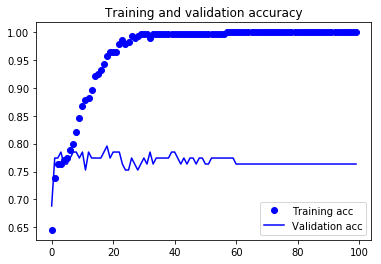

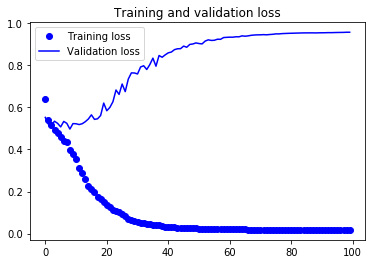

In [417]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [418]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

93/93 [==============================] - 0s 43us/step
test loss: 0.9567250449170348, test accuracy: 0.7634408473968506


In [419]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7076719576719577


In [420]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.18615751789976132


### KMeans

In [39]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.709998           0.081666           2.128489   
1             1.306748           0.425280           1.373850   
2             1.734670          -1.372888          -1.154236   
3             1.734670          -1.064259          -0.709050   
4             1.734670           1.475232           0.304731   
5            -1.357454          -1.560365          -0.993389   
6             0.321543          -0.501364          -0.339054   
7             1.097999          -0.427045          -0.234103   
8             1.734670           0.468400          -0.344386   
9            -1.359746          -1.205127          -0.671317   
10            1.587306           0.209036           1.657840   
11            1.734670           0.104209          -0.231131   
12            1.035685           0.546933           0.622772   
13            0.972281           0.789016           0.702993   
14           -1.133199           0.756391          -0.892669   
15           -0.286686          -0.893181          -0.864608   
16           -1.078617          -1.219578          -0.935650   
17           -0.779483          -0.945540          -0.338284   
18           -0.539003           0.776852           0.530745   
19           -0.654289          -0.841544           0.162215   
20            0.213529           1.051570           2.128489   
21           -1.008970           0.227216          -0.685589   
22           -0.509770          -0.100539          -0.507952   
23           -0.434214          -1.542384           0.834388   
24            1.024011          -0.133360           2.128488   
25            0.996972          -0.068300           0.463479   
26            1.734670          -0.636382           0.769493   
27            0.939519          -0.546060           1.545261   
28            0.065764          -1.072686           1.002347   
29            1.734670          -1.368860           0.533780   
..                 ...                ...                ...   
342          -0.855930           0.826496          -0.453379   
343          -1.395065          -0.085953           1.922929   
344          -0.298021          -1.181741          -0.986984   
345          -1.545817          -1.409239          -1.442796   
346          -0.346415          -1.039454          -1.018195   
347          -1.474386           0.029941          -0.538026   
348           0.118230           0.491129          -1.420467   
349           0.348396           0.059205          -0.665990   
350           1.734670          -0.003146           1.568996   
351          -0.099944          -0.751191           2.128489   
352           1.084858          -0.145339           0.813709   
353           1.187787          -0.429263          -0.071507   
354           0.816380          -0.786929          -0.447031   
355           1.118179          -0.721368          -0.381566   
356           1.226095           0.286296          -0.087024   
357           1.613198           0.199015           0.291700   
358           0.890203          -0.190496           0.624245   
359          -1.618544           2.294335          -0.896404   
360          -1.152545           1.039906          -0.408095   
361          -0.667401           2.294335           1.170804   
362          -1.723669           0.092346          -0.153795   
363          -1.723669          -0.253829           1.824256   
364          -1.723669          -0.295522           0.733720   
365          -0.736785          -0.662679           2.128489   
366           0.261615          -0.713681           2.128489   
367          -0.720122          -0.373744           1.948953   
368          -0.090607           0.425445           1.059996   
369           1.263139           0.315568           2.128489   
370          -1.393336           0.445276          -0.245554   
371           0.356389          -0.292506          -0.400481   

     chromagramfiles_4  chromagramfi

In [40]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[4464.0,
 3806.9754284522382,
 3354.365999848692,
 3107.5256199539926,
 2946.6963010094414,
 2816.3317870211076,
 2686.415552171973,
 2576.5543366887405,
 2504.325344232164,
 2391.4415220727014,
 2324.241850993652,
 2257.160251494757,
 2174.641140049278,
 2102.896301963741]

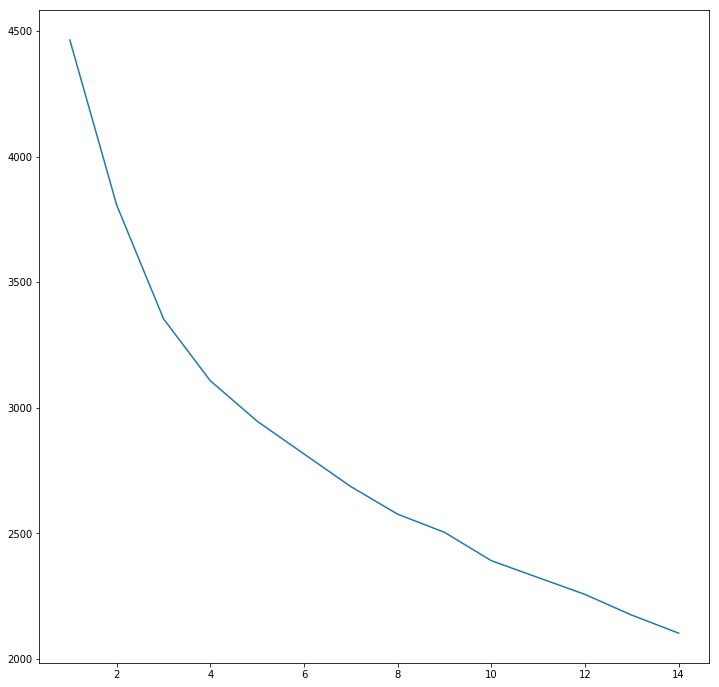

In [41]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=3

In [42]:
kmeans_ch = KMeans(n_clusters=3, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [43]:
kmeans_ch.labels_

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1,

In [44]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 2, 2, 2, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1,
       2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 0, 2, 2, 2, 1, 0, 1,
       0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 2, 2, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0, 2, 1, 1, 0, 0, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 2, 2, 2, 1, 1, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 1,
       2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 0, 0, 0, 1, 1, 2, 2, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 0, 1, 1,

In [45]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [46]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.709998           0.081666           2.128489   
1             1.306748           0.425280           1.373850   
2             1.734670          -1.372888          -1.154236   
3             1.734670          -1.064259          -0.709050   
4             1.734670           1.475232           0.304731   
5            -1.357454          -1.560365          -0.993389   
6             0.321543          -0.501364          -0.339054   
7             1.097999          -0.427045          -0.234103   
8             1.734670           0.468400          -0.344386   
9            -1.359746          -1.205127          -0.671317   
10            1.587306           0.209036           1.657840   
11            1.734670           0.104209          -0.231131   
12            1.035685           0.546933           0.622772   
13            0.972281           0.789016           0.702993   
14           -1.133199           0.756391          -0.892669   
15           -0.286686          -0.893181          -0.864608   
16           -1.078617          -1.219578          -0.935650   
17           -0.779483          -0.945540          -0.338284   
18           -0.539003           0.776852           0.530745   
19           -0.654289          -0.841544           0.162215   
20            0.213529           1.051570           2.128489   
21           -1.008970           0.227216          -0.685589   
22           -0.509770          -0.100539          -0.507952   
23           -0.434214          -1.542384           0.834388   
24            1.024011          -0.133360           2.128488   
25            0.996972          -0.068300           0.463479   
26            1.734670          -0.636382           0.769493   
27            0.939519          -0.546060           1.545261   
28            0.065764          -1.072686           1.002347   
29            1.734670          -1.368860           0.533780   
..                 ...                ...                ...   
342          -0.855930           0.826496          -0.453379   
343          -1.395065          -0.085953           1.922929   
344          -0.298021          -1.181741          -0.986984   
345          -1.545817          -1.409239          -1.442796   
346          -0.346415          -1.039454          -1.018195   
347          -1.474386           0.029941          -0.538026   
348           0.118230           0.491129          -1.420467   
349           0.348396           0.059205          -0.665990   
350           1.734670          -0.003146           1.568996   
351          -0.099944          -0.751191           2.128489   
352           1.084858          -0.145339           0.813709   
353           1.187787          -0.429263          -0.071507   
354           0.816380          -0.786929          -0.447031   
355           1.118179          -0.721368          -0.381566   
356           1.226095           0.286296          -0.087024   
357           1.613198           0.199015           0.291700   
358           0.890203          -0.190496           0.624245   
359          -1.618544           2.294335          -0.896404   
360          -1.152545           1.039906          -0.408095   
361          -0.667401           2.294335           1.170804   
362          -1.723669           0.092346          -0.153795   
363          -1.723669          -0.253829           1.824256   
364          -1.723669          -0.295522           0.733720   
365          -0.736785          -0.662679           2.128489   
366           0.261615          -0.713681           2.128489   
367          -0.720122          -0.373744           1.948953   
368          -0.090607           0.425445           1.059996   
369           1.263139           0.315568           2.128489   
370          -1.393336           0.445276          -0.245554   
371           0.356389          -0.292506          -0.400481   

     chromagramfiles_4  chromagramfi

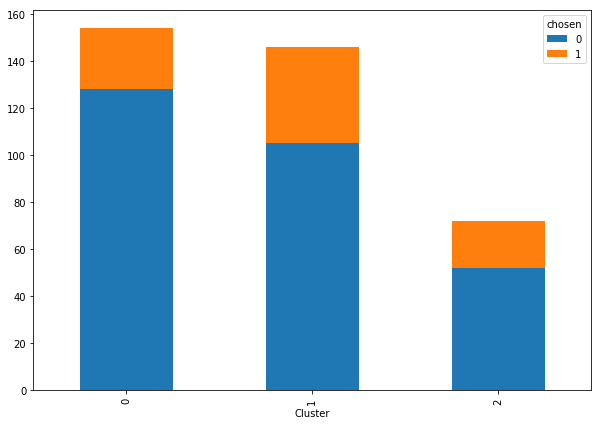

In [47]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [48]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[1]))

## Club De Banqueros y Empresarios

### ANN

In [421]:
X = df_n_ps_std_ch[1]

In [422]:
y = df_n_ps[1]['chosen']

In [423]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [424]:
X_train.shape

(191, 12)

In [53]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [54]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [55]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [60]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.004, 'max_iter': 500}, que permiten obtener un Accuracy de 78.53% y un Kappa del 40.11
Tiempo total: 24.99 minutos


In [425]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.004
epochs = 500

In [426]:
input_tensor = Input(shape = (n0,))

In [427]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [428]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [429]:
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_70 (Dense)             (None, 10)                130       
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 11        
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [430]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 191 samples, validate on 64 samples
Epoch 1/500
191/191 [==============================] - 0s 1ms/step - loss: 0.8012 - accuracy: 0.4607 - val_loss: 0.7811 - val_accuracy: 0.4688
Epoch 2/500
191/191 [==============================] - 0s 63us/step - loss: 0.7341 - accuracy: 0.4921 - val_loss: 0.7282 - val_accuracy: 0.5156
Epoch 3/500
191/191 [==============================] - 0s 68us/step - loss: 0.6797 - accuracy: 0.5602 - val_loss: 0.6882 - val_accuracy: 0.5469
Epoch 4/500
191/191 [==============================] - 0s 99us/step - loss: 0.6390 - accuracy: 0.6283 - val_loss: 0.6650 - val_accuracy: 0.5469
Epoch 5/500
191/191 [==============================] - 0s 73us/step - loss: 0.6126 - accuracy: 0.6754 - val_loss: 0.6514 - val_accuracy: 0.6250
Epoch 6/500
191/191 [==============================] - 0s 63us/step - loss: 0.5926 - accuracy: 0.6963 - val_loss: 0.6429 - val_accuracy: 0.6250
Epoch 7/500
191/191 [==============================] - 0s 63us/step - loss: 0.5764 - accurac

191/191 [==============================] - 0s 52us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 109/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 110/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 111/500
191/191 [==============================] - 0s 52us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 112/500
191/191 [==============================] - 0s 63us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 113/500
191/191 [==============================] - 0s 63us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 114/500
191/191 [==============================] - 0s 58us/step - loss: 0.4474 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy:

191/191 [==============================] - 0s 94us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 215/500
191/191 [==============================] - 0s 94us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 216/500
191/191 [==============================] - 0s 84us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00216: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
Epoch 217/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 218/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 219/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 220/500
191/191 [==============================] - 

191/191 [==============================] - 0s 68us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 268/500
191/191 [==============================] - 0s 68us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 269/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 270/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 271/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 272/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 273/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy:

191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 374/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 375/500
191/191 [==============================] - 0s 84us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 376/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562

Epoch 00376: ReduceLROnPlateau reducing learning rate to 5.820766367818295e-14.
Epoch 377/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 378/500
191/191 [==============================] - 0s 78us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 379/500
191/191 [==============================] - 

Epoch 479/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 480/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 481/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 482/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 483/500
191/191 [==============================] - 0s 58us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 484/500
191/191 [==============================] - 0s 63us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 - val_accuracy: 0.6562
Epoch 485/500
191/191 [==============================] - 0s 52us/step - loss: 0.4473 - accuracy: 0.7958 - val_loss: 0.6938 -

range(0, 500)


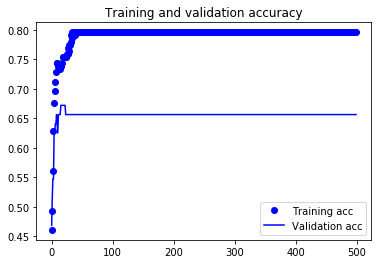

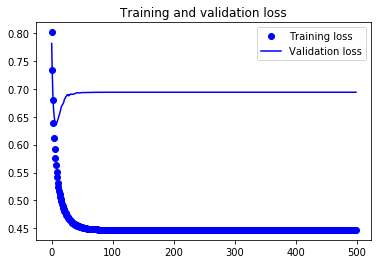

In [431]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [432]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

64/64 [==============================] - 0s 47us/step
test loss: 0.6938145160675049, test accuracy: 0.65625


In [433]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.5519480519480519


In [434]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.053763440860215006


### KMeans

In [71]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.369691          -0.881824          -0.095656   
1            -0.175875          -0.403800          -0.657709   
2             0.894452          -0.189794           1.959063   
3             0.060782          -0.392075           0.826233   
4            -1.116536          -0.923742          -1.238971   
5            -1.082752          -0.067472          -1.142511   
6            -1.202528          -0.776453          -1.135820   
7            -1.206944           0.500703          -0.243295   
8            -0.982006           0.421831           0.984997   
9             1.703175           1.029234           1.508859   
10            1.528139           0.898498           0.923889   
11            0.334361          -0.301383          -0.450307   
12            0.597458           0.773201           0.182265   
13           -0.493625           1.341798          -0.632970   
14            0.962230           0.028408           0.059003   
15           -0.843247           0.160055           1.959063   
16           -0.256403           1.322075           1.520118   
17           -0.456352           2.142046           1.959063   
18           -0.637040          -1.030219          -1.165495   
19           -1.204564          -1.022455          -0.683305   
20           -1.077420          -0.314272           1.036699   
21           -0.494728          -1.023105          -0.383945   
22           -0.525116           0.187277           1.220635   
23           -0.282675           0.571926          -0.333097   
24            1.898264           1.240876           0.302806   
25            0.449834          -0.315494          -0.187659   
26           -0.745212          -0.457525          -0.261214   
27           -1.146960           2.737908           0.205319   
28           -0.006670           2.177984          -0.364684   
29           -1.198149           1.245381           1.824748   
..                 ...                ...                ...   
225          -0.850302          -0.813520          -1.238258   
226           1.113887          -0.637363          -0.178882   
227          -0.939216          -1.028651          -1.083821   
228           0.323318          -0.538560           1.959063   
229           0.651351           0.768776           1.651644   
230           1.208263           0.590562          -0.856200   
231           1.629732          -0.424079          -0.793853   
232           1.097162           0.374225          -0.897801   
233           1.452404          -0.818664           1.001952   
234           0.687938           0.363684          -0.077785   
235          -0.511818          -1.019067           1.937312   
236          -0.649452           1.110585           0.023607   
237          -0.675917           0.864345           1.959063   
238          -0.820946           0.480728          -0.348445   
239           0.335654          -0.570366           0.440736   
240           0.772849          -0.288034           0.998235   
241          -0.725775          -0.253169          -1.058923   
242          -0.883133           0.370675          -1.102573   
243          -0.504299          -0.158035          -0.129250   
244          -0.829496           0.743464           1.959063   
245          -1.203285           0.455171           0.496797   
246          -1.122600          -0.442839           1.824660   
247          -1.206944          -0.795159          -1.159900   
248          -0.501382          -1.030219          -0.612979   
249          -0.704093          -0.985145           1.199508   
250           0.831957          -0.173367           1.636565   
251          -0.895156          -1.022380          -0.410545   
252          -0.546320          -0.631883          -0.800789   
253          -0.591349          -0.947758          -0.915262   
254          -0.072947          -0.912155           0.150662   

     chromagramfiles_4  chromagramfi

In [72]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3060.0,
 2594.1549165385713,
 2309.549481414484,
 2089.610498278143,
 1959.0566777030967,
 1842.9588281368096,
 1736.092921360928,
 1663.5689730025233,
 1609.4951000525748,
 1557.5767570007226,
 1514.8225721032359,
 1447.3960995377222,
 1422.027087832329,
 1389.3032827223215]

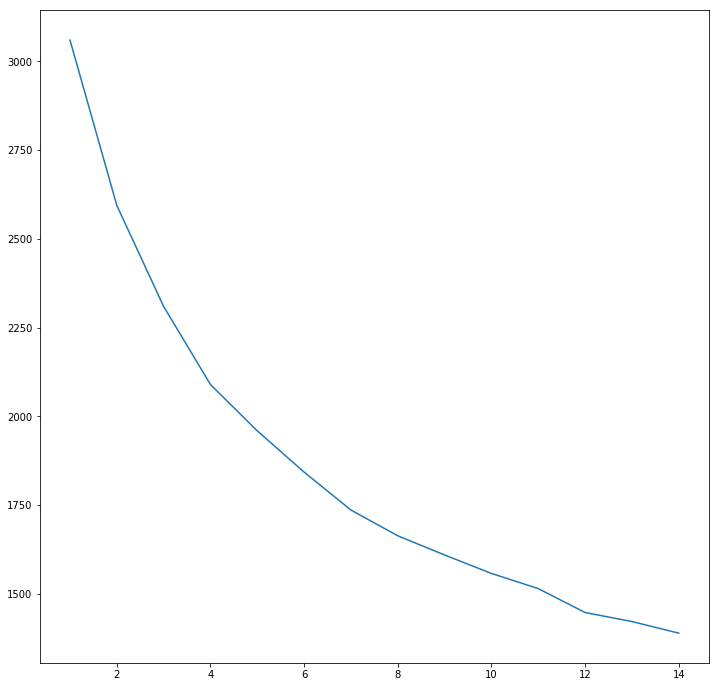

In [73]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [74]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [75]:
kmeans_ch.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [76]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1])

In [77]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [78]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.369691          -0.881824          -0.095656   
1            -0.175875          -0.403800          -0.657709   
2             0.894452          -0.189794           1.959063   
3             0.060782          -0.392075           0.826233   
4            -1.116536          -0.923742          -1.238971   
5            -1.082752          -0.067472          -1.142511   
6            -1.202528          -0.776453          -1.135820   
7            -1.206944           0.500703          -0.243295   
8            -0.982006           0.421831           0.984997   
9             1.703175           1.029234           1.508859   
10            1.528139           0.898498           0.923889   
11            0.334361          -0.301383          -0.450307   
12            0.597458           0.773201           0.182265   
13           -0.493625           1.341798          -0.632970   
14            0.962230           0.028408           0.059003   
15           -0.843247           0.160055           1.959063   
16           -0.256403           1.322075           1.520118   
17           -0.456352           2.142046           1.959063   
18           -0.637040          -1.030219          -1.165495   
19           -1.204564          -1.022455          -0.683305   
20           -1.077420          -0.314272           1.036699   
21           -0.494728          -1.023105          -0.383945   
22           -0.525116           0.187277           1.220635   
23           -0.282675           0.571926          -0.333097   
24            1.898264           1.240876           0.302806   
25            0.449834          -0.315494          -0.187659   
26           -0.745212          -0.457525          -0.261214   
27           -1.146960           2.737908           0.205319   
28           -0.006670           2.177984          -0.364684   
29           -1.198149           1.245381           1.824748   
..                 ...                ...                ...   
225          -0.850302          -0.813520          -1.238258   
226           1.113887          -0.637363          -0.178882   
227          -0.939216          -1.028651          -1.083821   
228           0.323318          -0.538560           1.959063   
229           0.651351           0.768776           1.651644   
230           1.208263           0.590562          -0.856200   
231           1.629732          -0.424079          -0.793853   
232           1.097162           0.374225          -0.897801   
233           1.452404          -0.818664           1.001952   
234           0.687938           0.363684          -0.077785   
235          -0.511818          -1.019067           1.937312   
236          -0.649452           1.110585           0.023607   
237          -0.675917           0.864345           1.959063   
238          -0.820946           0.480728          -0.348445   
239           0.335654          -0.570366           0.440736   
240           0.772849          -0.288034           0.998235   
241          -0.725775          -0.253169          -1.058923   
242          -0.883133           0.370675          -1.102573   
243          -0.504299          -0.158035          -0.129250   
244          -0.829496           0.743464           1.959063   
245          -1.203285           0.455171           0.496797   
246          -1.122600          -0.442839           1.824660   
247          -1.206944          -0.795159          -1.159900   
248          -0.501382          -1.030219          -0.612979   
249          -0.704093          -0.985145           1.199508   
250           0.831957          -0.173367           1.636565   
251          -0.895156          -1.022380          -0.410545   
252          -0.546320          -0.631883          -0.800789   
253          -0.591349          -0.947758          -0.915262   
254          -0.072947          -0.912155           0.150662   

     chromagramfiles_4  chromagramfi

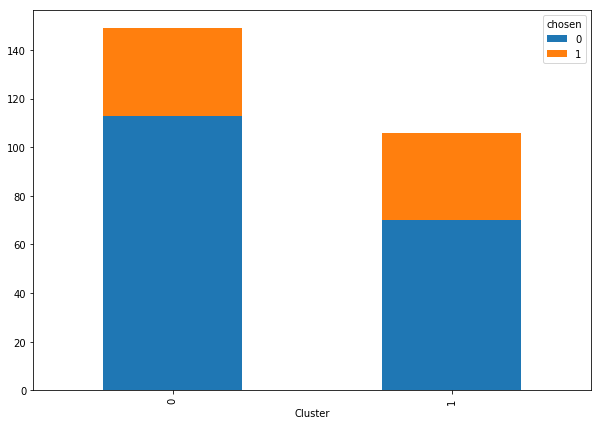

In [79]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [80]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[2]))

## Gramma

### ANN

In [435]:
X = df_n_ps_std_ch[2]

In [436]:
y = df_n_ps[2]['chosen']

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [438]:
X_train.shape

(231, 12)

In [85]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [86]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [87]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [88]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'tanh', 'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.003, 'max_iter': 100}, que permiten obtener un Accuracy de 81.39% y un Kappa del 20.50
Tiempo total: 29.47 minutos


In [439]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.003
epochs = 100

In [440]:
input_tensor = Input(shape = (n0,))

In [441]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [442]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [443]:
model.summary()

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_73 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 11        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [444]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 231 samples, validate on 78 samples
Epoch 1/100
231/231 [==============================] - 0s 805us/step - loss: 0.6917 - accuracy: 0.5714 - val_loss: 0.6342 - val_accuracy: 0.6795
Epoch 2/100
231/231 [==============================] - 0s 65us/step - loss: 0.6302 - accuracy: 0.7013 - val_loss: 0.5826 - val_accuracy: 0.7949
Epoch 3/100
231/231 [==============================] - 0s 61us/step - loss: 0.5899 - accuracy: 0.7706 - val_loss: 0.5455 - val_accuracy: 0.8205
Epoch 4/100
231/231 [==============================] - 0s 82us/step - loss: 0.5610 - accuracy: 0.7792 - val_loss: 0.5164 - val_accuracy: 0.8333
Epoch 5/100
231/231 [==============================] - 0s 78us/step - loss: 0.5344 - accuracy: 0.7965 - val_loss: 0.4901 - val_accuracy: 0.8333
Epoch 6/100
231/231 [==============================] - 0s 74us/step - loss: 0.5117 - accuracy: 0.7879 - val_loss: 0.4738 - val_accuracy: 0.8205
Epoch 7/100
231/231 [==============================] - 0s 56us/step - loss: 0.4959 - accur

231/231 [==============================] - 0s 61us/step - loss: 0.4151 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 56/100
231/231 [==============================] - 0s 61us/step - loss: 0.4149 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.375000081490725e-05.
Epoch 57/100
231/231 [==============================] - 0s 61us/step - loss: 0.4147 - accuracy: 0.8009 - val_loss: 0.4236 - val_accuracy: 0.8205
Epoch 58/100
231/231 [==============================] - 0s 91us/step - loss: 0.4146 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 59/100
231/231 [==============================] - 0s 61us/step - loss: 0.4145 - accuracy: 0.8009 - val_loss: 0.4235 - val_accuracy: 0.8205
Epoch 60/100
231/231 [==============================] - 0s 87us/step - loss: 0.4144 - accuracy: 0.8052 - val_loss: 0.4234 - val_accuracy: 0.8205
Epoch 61/100
231/231 [==============================] - 0s 65u

range(0, 100)


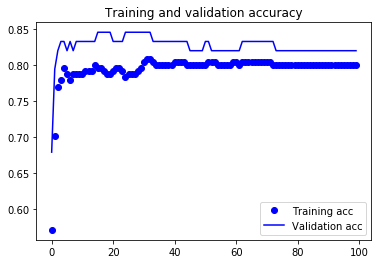

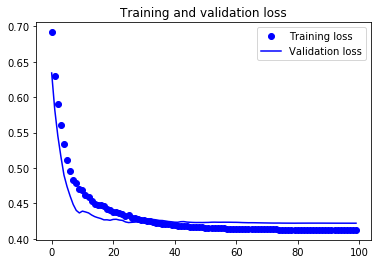

In [445]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [446]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

78/78 [==============================] - 0s 64us/step
test loss: 0.42215611384465146, test accuracy: 0.8205128312110901


In [447]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7087053571428572


In [448]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.2155172413793104


### KMeans

In [100]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.984589          -0.654155          -0.792745   
1            -0.102317           1.607758           0.006886   
2            -0.439474           2.028691          -0.353938   
3            -0.645076           0.109508          -0.651900   
4            -0.301057           0.336491           1.322422   
5            -1.259648           0.791285           0.394989   
6            -0.473744           0.544499           0.562651   
7            -0.774266           0.899101           0.080156   
8             1.984589          -0.912964           1.574884   
9             1.984589          -0.409991           1.175249   
10            1.984589          -1.189009          -0.443729   
11            1.425631          -0.405095           1.943010   
12           -0.175927          -1.348663          -0.477174   
13           -0.085508          -0.457470           0.184100   
14            0.250965           2.028690          -1.244012   
15            0.541805          -0.001425          -0.925880   
16            1.075493           1.812588          -0.957979   
17            1.162343          -1.410603           1.107861   
18           -0.350570          -0.306746           0.672887   
19            1.984589          -1.166218          -0.302121   
20           -0.344429           0.397628           0.492928   
21           -0.665123          -0.712314          -0.800151   
22           -0.034726           0.631798           1.392275   
23            1.984589          -0.007008           1.098575   
24            0.863870          -0.225984           0.529571   
25            1.984589          -0.637932           0.518394   
26           -0.534296          -0.293829          -0.533721   
27           -1.305187          -1.249514          -0.918547   
28           -0.702071           2.028691          -0.850117   
29            0.432566           0.860284          -1.227202   
..                 ...                ...                ...   
279          -1.348839           0.139880          -1.253885   
280          -0.179872           2.028690          -0.263275   
281           0.469201          -0.567649          -0.709387   
282           0.543320          -0.456381          -0.634102   
283           0.477794          -0.769583          -0.735746   
284           0.222631          -0.766506           0.927101   
285           1.911041          -1.385949           0.489432   
286           0.998963          -0.323703           1.401654   
287          -0.510470          -0.039911           1.963115   
288          -0.254650           0.178893           1.558633   
289          -0.808854          -0.341264           1.351164   
290           1.984589          -0.481795           0.508510   
291           0.998287          -0.217204           0.367127   
292           0.798451          -0.538113           1.041133   
293          -0.943702           0.737028          -0.728275   
294          -0.783173           2.028690          -0.694537   
295          -1.353539           0.236507          -1.253885   
296          -0.814494          -0.644175          -0.746555   
297          -1.328790          -0.867949          -1.235248   
298          -0.492926           0.191754           0.111709   
299          -0.170158           1.429318           0.352435   
300          -0.735769           1.192104           0.781909   
301          -0.019554           1.160350           0.498593   
302           1.400364          -1.135263          -1.004589   
303           0.689113          -1.410603          -1.223892   
304           0.922331          -1.397035          -0.464459   
305           0.750767          -0.421453          -0.860282   
306           0.961272          -0.181417          -0.598543   
307          -0.525215           1.812541          -0.767815   
308          -1.312658          -1.394783           1.272388   

     chromagramfiles_4  chromagramfi

In [101]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3708.0,
 2878.224392689417,
 2409.0313876777413,
 2245.2681343684408,
 2096.2730590487927,
 1980.9081903971983,
 1884.1812168752008,
 1782.3304172674002,
 1692.3482768291478,
 1629.7037390768492,
 1586.8745376225052,
 1530.5845891254487,
 1455.503322263105,
 1429.3496938708681]

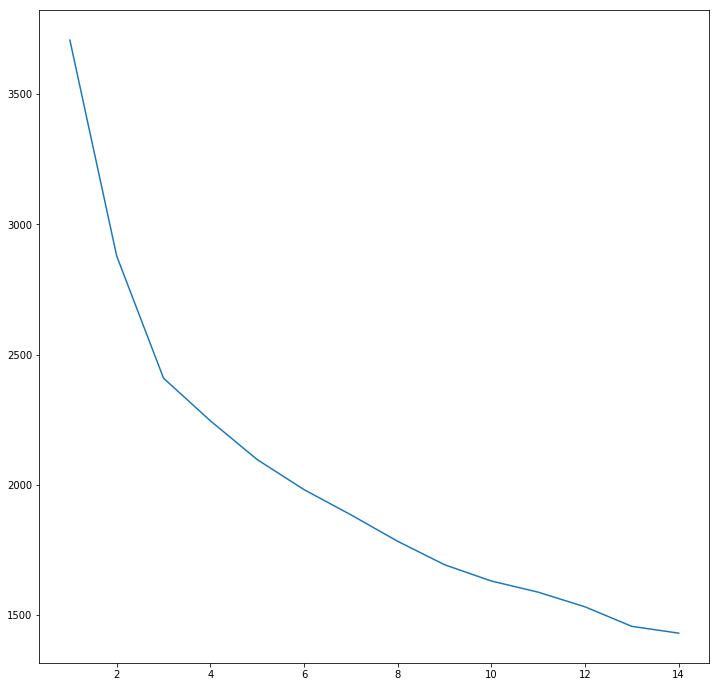

In [102]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [103]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [104]:
kmeans_ch.labels_

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [105]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [106]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [107]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.984589          -0.654155          -0.792745   
1            -0.102317           1.607758           0.006886   
2            -0.439474           2.028691          -0.353938   
3            -0.645076           0.109508          -0.651900   
4            -0.301057           0.336491           1.322422   
5            -1.259648           0.791285           0.394989   
6            -0.473744           0.544499           0.562651   
7            -0.774266           0.899101           0.080156   
8             1.984589          -0.912964           1.574884   
9             1.984589          -0.409991           1.175249   
10            1.984589          -1.189009          -0.443729   
11            1.425631          -0.405095           1.943010   
12           -0.175927          -1.348663          -0.477174   
13           -0.085508          -0.457470           0.184100   
14            0.250965           2.028690          -1.244012   
15            0.541805          -0.001425          -0.925880   
16            1.075493           1.812588          -0.957979   
17            1.162343          -1.410603           1.107861   
18           -0.350570          -0.306746           0.672887   
19            1.984589          -1.166218          -0.302121   
20           -0.344429           0.397628           0.492928   
21           -0.665123          -0.712314          -0.800151   
22           -0.034726           0.631798           1.392275   
23            1.984589          -0.007008           1.098575   
24            0.863870          -0.225984           0.529571   
25            1.984589          -0.637932           0.518394   
26           -0.534296          -0.293829          -0.533721   
27           -1.305187          -1.249514          -0.918547   
28           -0.702071           2.028691          -0.850117   
29            0.432566           0.860284          -1.227202   
..                 ...                ...                ...   
279          -1.348839           0.139880          -1.253885   
280          -0.179872           2.028690          -0.263275   
281           0.469201          -0.567649          -0.709387   
282           0.543320          -0.456381          -0.634102   
283           0.477794          -0.769583          -0.735746   
284           0.222631          -0.766506           0.927101   
285           1.911041          -1.385949           0.489432   
286           0.998963          -0.323703           1.401654   
287          -0.510470          -0.039911           1.963115   
288          -0.254650           0.178893           1.558633   
289          -0.808854          -0.341264           1.351164   
290           1.984589          -0.481795           0.508510   
291           0.998287          -0.217204           0.367127   
292           0.798451          -0.538113           1.041133   
293          -0.943702           0.737028          -0.728275   
294          -0.783173           2.028690          -0.694537   
295          -1.353539           0.236507          -1.253885   
296          -0.814494          -0.644175          -0.746555   
297          -1.328790          -0.867949          -1.235248   
298          -0.492926           0.191754           0.111709   
299          -0.170158           1.429318           0.352435   
300          -0.735769           1.192104           0.781909   
301          -0.019554           1.160350           0.498593   
302           1.400364          -1.135263          -1.004589   
303           0.689113          -1.410603          -1.223892   
304           0.922331          -1.397035          -0.464459   
305           0.750767          -0.421453          -0.860282   
306           0.961272          -0.181417          -0.598543   
307          -0.525215           1.812541          -0.767815   
308          -1.312658          -1.394783           1.272388   

     chromagramfiles_4  chromagramfi

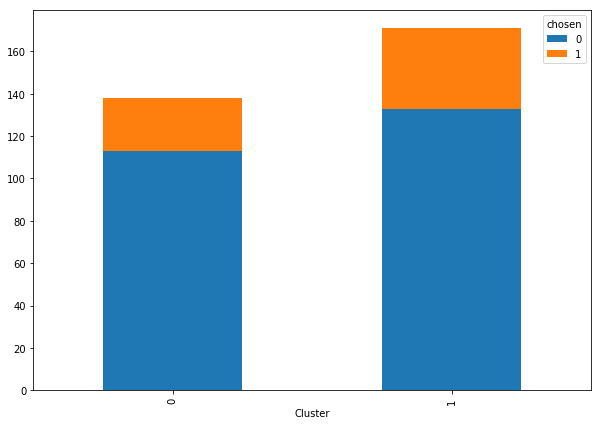

In [108]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [109]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[3]))

## Hotel Marrakech

### ANN

In [449]:
X = df_n_ps_std_ch[3]

In [450]:
y = df_n_ps[3]['chosen']

In [451]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [452]:
X_train.shape

(139, 12)

In [114]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [115]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [116]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [117]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (30, 20, 10), 'learning_rate_init': 0.005, 'max_iter': 400}, que permiten obtener un Accuracy de 74.82% y un Kappa del 36.52
Tiempo total: 20.79 minutos


In [453]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [30,20,10]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.005
epochs = 400

In [454]:
input_tensor = Input(shape = (n0,))

In [455]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [456]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [457]:
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_75 (Dense)             (None, 30)                390       
_________________________________________________________________
dense_76 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_77 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 11        
Total params: 1,231
Trainable params: 1,231
Non-trainable params: 0
_________________________________________________________________


In [458]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 139 samples, validate on 47 samples
Epoch 1/400
139/139 [==============================] - 0s 2ms/step - loss: 0.6839 - accuracy: 0.5612 - val_loss: 0.6643 - val_accuracy: 0.6596
Epoch 2/400
139/139 [==============================] - 0s 101us/step - loss: 0.6139 - accuracy: 0.6978 - val_loss: 0.6457 - val_accuracy: 0.5745
Epoch 3/400
139/139 [==============================] - 0s 86us/step - loss: 0.5802 - accuracy: 0.7050 - val_loss: 0.6362 - val_accuracy: 0.6383
Epoch 4/400
139/139 [==============================] - 0s 79us/step - loss: 0.5585 - accuracy: 0.7050 - val_loss: 0.6262 - val_accuracy: 0.6809
Epoch 5/400
139/139 [==============================] - 0s 79us/step - loss: 0.5379 - accuracy: 0.7266 - val_loss: 0.6363 - val_accuracy: 0.7234
Epoch 6/400
139/139 [==============================] - 0s 86us/step - loss: 0.5218 - accuracy: 0.7554 - val_loss: 0.6389 - val_accuracy: 0.7021
Epoch 7/400
139/139 [==============================] - 0s 72us/step - loss: 0.5042 - accura

Epoch 55/400
139/139 [==============================] - 0s 86us/step - loss: 0.2026 - accuracy: 0.9496 - val_loss: 0.7387 - val_accuracy: 0.6596

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00015624999650754035.
Epoch 56/400
139/139 [==============================] - 0s 108us/step - loss: 0.2014 - accuracy: 0.9496 - val_loss: 0.7387 - val_accuracy: 0.6596
Epoch 57/400
139/139 [==============================] - 0s 115us/step - loss: 0.2007 - accuracy: 0.9496 - val_loss: 0.7393 - val_accuracy: 0.6596
Epoch 58/400
139/139 [==============================] - 0s 101us/step - loss: 0.2001 - accuracy: 0.9496 - val_loss: 0.7398 - val_accuracy: 0.6596
Epoch 59/400
139/139 [==============================] - 0s 86us/step - loss: 0.1997 - accuracy: 0.9496 - val_loss: 0.7410 - val_accuracy: 0.6596
Epoch 60/400
139/139 [==============================] - 0s 86us/step - loss: 0.1991 - accuracy: 0.9496 - val_loss: 0.7421 - val_accuracy: 0.6596
Epoch 61/400
139/139 [=======================

139/139 [==============================] - 0s 79us/step - loss: 0.1909 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 109/400
139/139 [==============================] - 0s 79us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 110/400
139/139 [==============================] - 0s 79us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 111/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 112/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 113/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy: 0.6596
Epoch 114/400
139/139 [==============================] - 0s 72us/step - loss: 0.1908 - accuracy: 0.9496 - val_loss: 0.7486 - val_accuracy:

139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 215/400
139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00215: ReduceLROnPlateau reducing learning rate to 2.38418573772492e-09.
Epoch 216/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 217/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 218/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 219/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 220/400
139/139 [==============================] - 0

Epoch 267/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 268/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 269/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 270/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 271/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 272/400
139/139 [==============================] - 0s 101us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 273/400
139/139 [==============================] - 0s 79us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 

139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 374/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 375/400
139/139 [==============================] - 0s 93us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596

Epoch 00375: ReduceLROnPlateau reducing learning rate to 3.63797872577655e-14.
Epoch 376/400
139/139 [==============================] - 0s 72us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 377/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 378/400
139/139 [==============================] - 0s 86us/step - loss: 0.1906 - accuracy: 0.9496 - val_loss: 0.7487 - val_accuracy: 0.6596
Epoch 379/400
139/139 [==============================] - 0

range(0, 400)


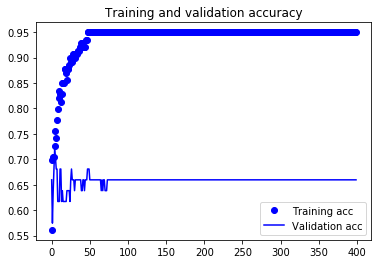

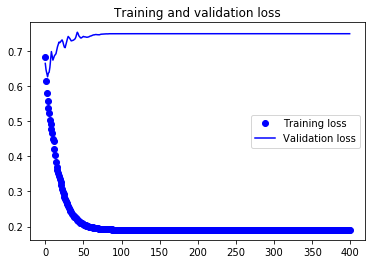

In [459]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [460]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

47/47 [==============================] - 0s 85us/step
test loss: 0.7487381544518978, test accuracy: 0.6595744490623474


In [461]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.6145833333333334


In [462]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.15695067264573992


### KMeans

In [128]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.599304          -1.060396           0.465659   
1            -0.906389           1.573440           1.673148   
2            -0.149325           0.716481          -1.280822   
3            -0.569330           0.172306          -1.126575   
4            -1.256063          -0.200780          -1.280822   
5             1.498382           0.070778           1.241647   
6             1.498381          -0.356738           0.435175   
7            -1.119602           2.289616           0.868130   
8             1.498382           0.306863          -0.233871   
9            -0.564178           0.625076          -0.818535   
10           -0.778882           1.298999           1.673148   
11           -0.644689           1.907389           0.724477   
12           -0.726607           0.659282           1.063080   
13            0.038859           1.272019          -0.111205   
14           -1.028647           1.835461           0.117175   
15           -1.170073          -1.108093           1.429803   
16            0.568533           0.319544           0.717878   
17            0.818260          -0.108057           1.673148   
18           -1.346310          -1.140106          -1.280822   
19            1.250159          -1.050602          -1.222878   
20            0.572797           2.142771           1.581524   
21            0.862369           2.221963           1.673148   
22            1.498382          -0.404560           0.195068   
23           -1.364025           1.371234           1.673148   
24            1.498382          -0.141656           1.241642   
25            1.498382          -0.280382           1.532544   
26            1.075665          -0.107428           1.673148   
27            0.540581           0.054204           0.505362   
28           -0.980545          -1.054168          -1.263653   
29           -0.441960           1.036991          -0.878755   
..                 ...                ...                ...   
156           0.964566          -0.478675           0.600961   
157           0.270654           0.971091           0.132712   
158           0.388178          -0.776533          -1.121244   
159          -0.409488          -0.518845          -0.902126   
160          -1.188703          -0.210659          -0.626345   
161          -1.476495          -1.140106          -1.266686   
162          -1.075963          -1.140106           0.768537   
163          -1.142157          -1.140106          -0.917613   
164          -0.756762          -0.149815           1.673148   
165           0.429405          -0.093236           1.263826   
166           0.553018          -0.191462           1.673148   
167           0.997841           1.111726           1.673148   
168           1.281068           0.266174           0.446982   
169           0.013523          -0.761110          -1.031584   
170           0.666873          -0.889641           1.409534   
171          -0.179155          -0.647105           1.673148   
172          -0.698104          -1.140106           1.673147   
173          -0.221070          -1.120261           0.098266   
174          -0.987264          -1.140106           1.430551   
175          -0.001472           2.289616          -0.469230   
176           0.759267           2.289616          -0.807487   
177           0.303330           1.071917           0.410221   
178           0.371415           0.428878          -0.437216   
179          -1.106214           0.339351          -0.739020   
180           0.970965           1.730559           1.300739   
181          -1.092848          -1.140019          -1.014068   
182          -0.432669          -1.140106          -1.275255   
183          -1.222408          -1.109984           0.115563   
184           1.498382           0.114899           0.573155   
185          -0.252632          -0.228432          -0.156977   

     chromagramfiles_4  chromagramfi

In [129]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2232.0,
 1887.86126663073,
 1710.7260050049272,
 1558.3692212048186,
 1444.9563111647813,
 1360.8980768251936,
 1285.0938986929364,
 1227.1073156803282,
 1175.9593811616949,
 1123.763719209633,
 1080.6180773747733,
 1058.1006766601422,
 1021.9523094285516,
 986.031006954783]

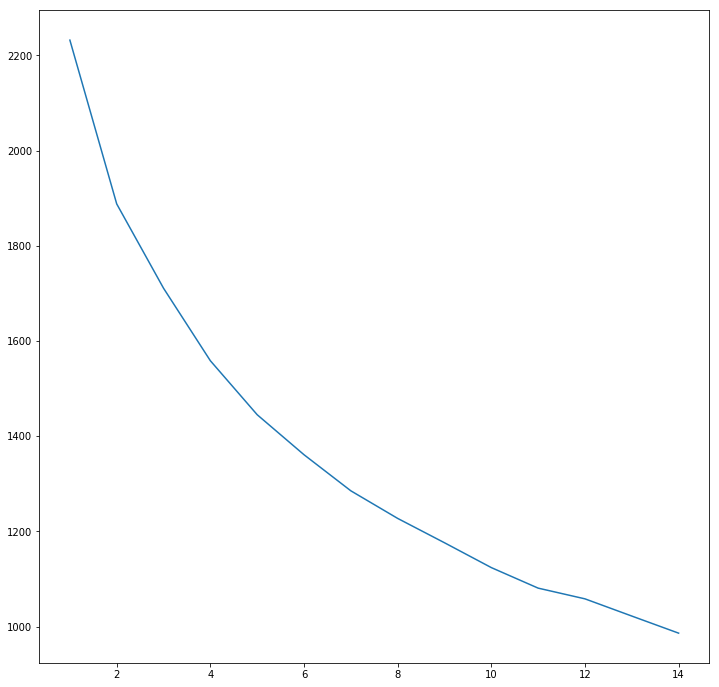

In [130]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [131]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [132]:
kmeans_ch.labels_

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [133]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0])

In [134]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [135]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0            -0.599304          -1.060396           0.465659   
1            -0.906389           1.573440           1.673148   
2            -0.149325           0.716481          -1.280822   
3            -0.569330           0.172306          -1.126575   
4            -1.256063          -0.200780          -1.280822   
5             1.498382           0.070778           1.241647   
6             1.498381          -0.356738           0.435175   
7            -1.119602           2.289616           0.868130   
8             1.498382           0.306863          -0.233871   
9            -0.564178           0.625076          -0.818535   
10           -0.778882           1.298999           1.673148   
11           -0.644689           1.907389           0.724477   
12           -0.726607           0.659282           1.063080   
13            0.038859           1.272019          -0.111205   
14           -1.028647           1.835461           0.117175   
15           -1.170073          -1.108093           1.429803   
16            0.568533           0.319544           0.717878   
17            0.818260          -0.108057           1.673148   
18           -1.346310          -1.140106          -1.280822   
19            1.250159          -1.050602          -1.222878   
20            0.572797           2.142771           1.581524   
21            0.862369           2.221963           1.673148   
22            1.498382          -0.404560           0.195068   
23           -1.364025           1.371234           1.673148   
24            1.498382          -0.141656           1.241642   
25            1.498382          -0.280382           1.532544   
26            1.075665          -0.107428           1.673148   
27            0.540581           0.054204           0.505362   
28           -0.980545          -1.054168          -1.263653   
29           -0.441960           1.036991          -0.878755   
..                 ...                ...                ...   
156           0.964566          -0.478675           0.600961   
157           0.270654           0.971091           0.132712   
158           0.388178          -0.776533          -1.121244   
159          -0.409488          -0.518845          -0.902126   
160          -1.188703          -0.210659          -0.626345   
161          -1.476495          -1.140106          -1.266686   
162          -1.075963          -1.140106           0.768537   
163          -1.142157          -1.140106          -0.917613   
164          -0.756762          -0.149815           1.673148   
165           0.429405          -0.093236           1.263826   
166           0.553018          -0.191462           1.673148   
167           0.997841           1.111726           1.673148   
168           1.281068           0.266174           0.446982   
169           0.013523          -0.761110          -1.031584   
170           0.666873          -0.889641           1.409534   
171          -0.179155          -0.647105           1.673148   
172          -0.698104          -1.140106           1.673147   
173          -0.221070          -1.120261           0.098266   
174          -0.987264          -1.140106           1.430551   
175          -0.001472           2.289616          -0.469230   
176           0.759267           2.289616          -0.807487   
177           0.303330           1.071917           0.410221   
178           0.371415           0.428878          -0.437216   
179          -1.106214           0.339351          -0.739020   
180           0.970965           1.730559           1.300739   
181          -1.092848          -1.140019          -1.014068   
182          -0.432669          -1.140106          -1.275255   
183          -1.222408          -1.109984           0.115563   
184           1.498382           0.114899           0.573155   
185          -0.252632          -0.228432          -0.156977   

     chromagramfiles_4  chromagramfi

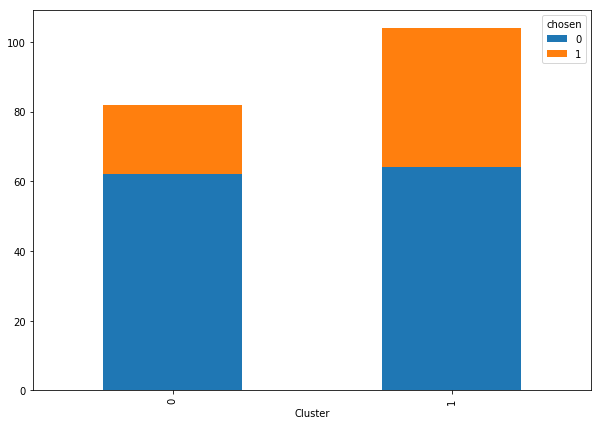

In [136]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [137]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[4]))

## Specialized

### ANN

In [463]:
X = df_n_ps_std_ch[4]

In [464]:
y = df_n_ps[4]['chosen']

In [465]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [466]:
X_train.shape

(164, 12)

In [142]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [143]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [144]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [145]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20, 20), 'learning_rate_init': 0.001, 'max_iter': 500}, que permiten obtener un Accuracy de 64.63% y un Kappa del 27.16
Tiempo total: 22.23 minutos


In [467]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20,20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr = 0.001
epochs = 500

In [468]:
input_tensor = Input(shape = (n0,))

In [469]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [470]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [471]:
model.summary()

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_80 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 21        
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [472]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 164 samples, validate on 55 samples
Epoch 1/500
164/164 [==============================] - 0s 1ms/step - loss: 0.7345 - accuracy: 0.5488 - val_loss: 0.6907 - val_accuracy: 0.5455
Epoch 2/500
164/164 [==============================] - 0s 110us/step - loss: 0.7152 - accuracy: 0.5732 - val_loss: 0.6766 - val_accuracy: 0.5636
Epoch 3/500
164/164 [==============================] - 0s 79us/step - loss: 0.7022 - accuracy: 0.5610 - val_loss: 0.6723 - val_accuracy: 0.5636
Epoch 4/500
164/164 [==============================] - 0s 73us/step - loss: 0.6954 - accuracy: 0.5549 - val_loss: 0.6718 - val_accuracy: 0.5818
Epoch 5/500
164/164 [==============================] - 0s 85us/step - loss: 0.6887 - accuracy: 0.5549 - val_loss: 0.6672 - val_accuracy: 0.5818
Epoch 6/500
164/164 [==============================] - 0s 79us/step - loss: 0.6837 - accuracy: 0.5671 - val_loss: 0.6599 - val_accuracy: 0.6000
Epoch 7/500
164/164 [==============================] - 0s 79us/step - loss: 0.6786 - accura

164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 109/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 110/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 111/500
164/164 [==============================] - 0s 91us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 112/500
164/164 [==============================] - 0s 85us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 113/500
164/164 [==============================] - 0s 85us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy: 0.6545
Epoch 114/500
164/164 [==============================] - 0s 67us/step - loss: 0.6230 - accuracy: 0.6341 - val_loss: 0.6201 - val_accuracy:

164/164 [==============================] - 0s 97us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 215/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 216/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00216: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
Epoch 217/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 218/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 219/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 220/500
164/164 [==============================] - 

164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 268/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 269/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 270/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 271/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 272/500
164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 273/500
164/164 [==============================] - 0s 61us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy:

164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 374/500
164/164 [==============================] - 0s 85us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 375/500
164/164 [==============================] - 0s 79us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 376/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545

Epoch 00376: ReduceLROnPlateau reducing learning rate to 1.4551915919545737e-14.
Epoch 377/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 378/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 379/500
164/164 [==============================] -

Epoch 479/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 480/500
164/164 [==============================] - 0s 91us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 481/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 482/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 483/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 484/500
164/164 [==============================] - 0s 67us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 - val_accuracy: 0.6545
Epoch 485/500
164/164 [==============================] - 0s 73us/step - loss: 0.6229 - accuracy: 0.6341 - val_loss: 0.6202 -

range(0, 500)


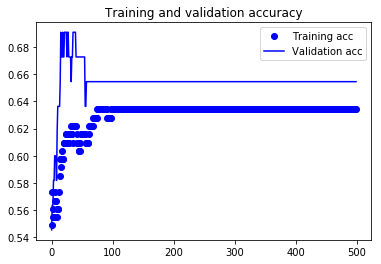

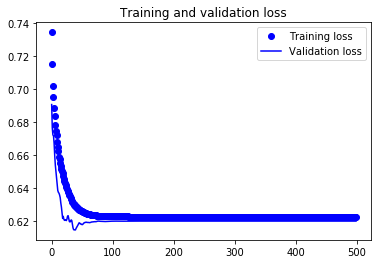

In [473]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [474]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

55/55 [==============================] - 0s 55us/step
test loss: 0.6201585899699819, test accuracy: 0.6545454263687134


In [475]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.7365591397849462


In [476]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.2943956785955435


### KMeans

In [156]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.752761          -1.114598          -0.348132   
1            -1.387006          -0.333039           0.041297   
2            -0.628834           2.234144           0.613536   
3             0.081693           1.765530          -0.365668   
4             0.056206           1.646501           0.508800   
5            -0.475284           0.673200          -1.077774   
6             0.163433          -0.011304          -1.057752   
7             0.110500           0.178211          -1.394026   
8             0.595793          -0.898440           1.924099   
9            -0.017542          -1.386211           0.574605   
10            0.796579          -1.216664          -0.112327   
11            1.761253          -0.949116          -0.297777   
12            1.055147          -0.394702           1.258031   
13            1.761253          -0.435392           0.592085   
14           -0.137413          -0.980041          -1.297302   
15            0.017749          -0.936126          -1.136240   
16           -0.382429          -1.386211          -1.437693   
17           -1.227998           1.294887           2.200026   
18           -1.076569          -0.776099          -0.576736   
19           -1.180746           0.385053           2.200026   
20            1.192498          -0.224351          -0.206238   
21            1.213472           0.048184          -0.600330   
22           -0.004572          -0.052026           2.200026   
23           -0.229893           0.630662           0.484895   
24            0.217943          -0.177066           0.659322   
25           -0.333597           0.972324          -0.721724   
26           -0.602430          -0.028610          -0.826715   
27           -0.251812          -0.171571          -0.358821   
28           -0.368678           2.234146          -0.330756   
29           -0.578621           2.234146          -0.562376   
..                 ...                ...                ...   
189          -0.186741          -1.165084          -0.921181   
190          -0.163966           0.884601           1.657605   
191          -0.254097          -0.617571           0.535718   
192          -1.359431           0.228998           0.259367   
193           1.622617           2.234146          -1.127605   
194          -0.467818          -0.314482           0.014154   
195          -1.423661          -0.599038          -0.707969   
196           1.761253          -0.325612           0.357954   
197           1.761253           1.028574           1.374947   
198           1.761253           0.050043           0.687757   
199          -0.919189          -0.200271          -1.032880   
200          -0.988568          -0.189392          -1.028379   
201          -0.779270           0.427427          -0.948100   
202           1.116127          -1.139042           0.168460   
203           0.762440          -1.190866          -0.050517   
204           0.058411          -1.128496          -1.328850   
205          -0.720270          -0.697672          -0.720394   
206          -0.364461          -0.010160          -1.095500   
207          -0.272236          -0.196860          -0.727982   
208           1.761253          -0.082523          -0.122308   
209           1.573516          -0.161473          -0.359909   
210           1.761253           0.417875          -0.918851   
211           1.761253           0.145550           1.710575   
212           0.470346          -0.334996           2.200026   
213          -0.576457          -0.914445           1.070087   
214           1.761253          -0.591066          -0.690824   
215           1.490806          -1.368871          -1.151960   
216           0.191801          -1.348512          -1.315236   
217          -0.002098           2.039653          -0.752917   
218          -0.098688          -0.923087          -0.917548   

     chromagramfiles_4  chromagramfi

In [157]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[2628.0,
 2183.3505259693475,
 1946.7709026205612,
 1764.2381744586387,
 1667.52081260375,
 1588.695626080069,
 1521.6546082793252,
 1465.3583612489235,
 1381.9950671234758,
 1338.0035802619554,
 1275.054416118868,
 1244.4334212962274,
 1201.2393010186188,
 1166.7934845697623]

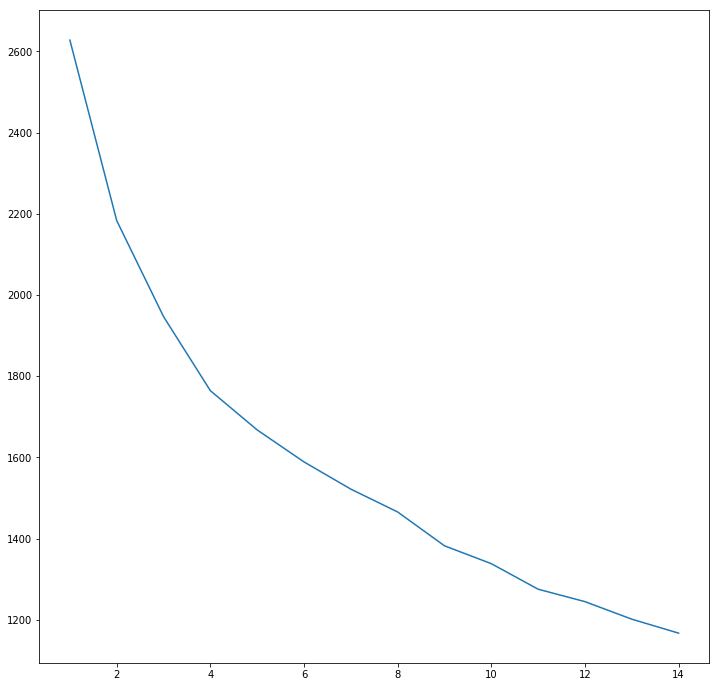

In [158]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=2

In [159]:
kmeans_ch = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [160]:
kmeans_ch.labels_

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [161]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [162]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [163]:
X

chromagramfiles_1  chromagramfiles_2  chromagramfiles_3  \
0             1.752761          -1.114598          -0.348132   
1            -1.387006          -0.333039           0.041297   
2            -0.628834           2.234144           0.613536   
3             0.081693           1.765530          -0.365668   
4             0.056206           1.646501           0.508800   
5            -0.475284           0.673200          -1.077774   
6             0.163433          -0.011304          -1.057752   
7             0.110500           0.178211          -1.394026   
8             0.595793          -0.898440           1.924099   
9            -0.017542          -1.386211           0.574605   
10            0.796579          -1.216664          -0.112327   
11            1.761253          -0.949116          -0.297777   
12            1.055147          -0.394702           1.258031   
13            1.761253          -0.435392           0.592085   
14           -0.137413          -0.980041          -1.297302   
15            0.017749          -0.936126          -1.136240   
16           -0.382429          -1.386211          -1.437693   
17           -1.227998           1.294887           2.200026   
18           -1.076569          -0.776099          -0.576736   
19           -1.180746           0.385053           2.200026   
20            1.192498          -0.224351          -0.206238   
21            1.213472           0.048184          -0.600330   
22           -0.004572          -0.052026           2.200026   
23           -0.229893           0.630662           0.484895   
24            0.217943          -0.177066           0.659322   
25           -0.333597           0.972324          -0.721724   
26           -0.602430          -0.028610          -0.826715   
27           -0.251812          -0.171571          -0.358821   
28           -0.368678           2.234146          -0.330756   
29           -0.578621           2.234146          -0.562376   
..                 ...                ...                ...   
189          -0.186741          -1.165084          -0.921181   
190          -0.163966           0.884601           1.657605   
191          -0.254097          -0.617571           0.535718   
192          -1.359431           0.228998           0.259367   
193           1.622617           2.234146          -1.127605   
194          -0.467818          -0.314482           0.014154   
195          -1.423661          -0.599038          -0.707969   
196           1.761253          -0.325612           0.357954   
197           1.761253           1.028574           1.374947   
198           1.761253           0.050043           0.687757   
199          -0.919189          -0.200271          -1.032880   
200          -0.988568          -0.189392          -1.028379   
201          -0.779270           0.427427          -0.948100   
202           1.116127          -1.139042           0.168460   
203           0.762440          -1.190866          -0.050517   
204           0.058411          -1.128496          -1.328850   
205          -0.720270          -0.697672          -0.720394   
206          -0.364461          -0.010160          -1.095500   
207          -0.272236          -0.196860          -0.727982   
208           1.761253          -0.082523          -0.122308   
209           1.573516          -0.161473          -0.359909   
210           1.761253           0.417875          -0.918851   
211           1.761253           0.145550           1.710575   
212           0.470346          -0.334996           2.200026   
213          -0.576457          -0.914445           1.070087   
214           1.761253          -0.591066          -0.690824   
215           1.490806          -1.368871          -1.151960   
216           0.191801          -1.348512          -1.315236   
217          -0.002098           2.039653          -0.752917   
218          -0.098688          -0.923087          -0.917548   

     chromagramfiles_4  chromagramfi

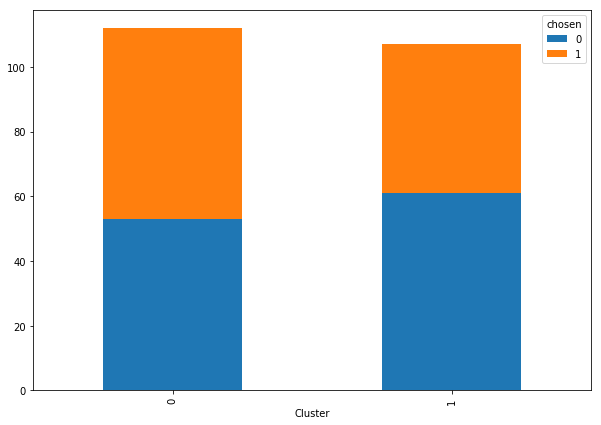

In [164]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))

In [165]:
from IPython.display import display, Markdown, Latex
display(Markdown('## '+companies[5]))

## Urban Place

### ANN

In [477]:
X = df_n_ps_std_ch[5]

In [478]:
y = df_n_ps[5]['chosen']

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [480]:
X_train.shape

(168, 12)

In [170]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [171]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]
batch_size_vec = [10, 20, 40, 60, 80, 100, 150]

In [172]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec#,
              #'batch_size': batch_size_vec
              }
scoring = {'kappa':make_scorer(cohen_kappa_score), 'accuracy':'accuracy'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='accuracy', n_jobs=-1, iid=True)

In [173]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un Accuracy de {1:.2f}% y un Kappa del {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_kappa'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20,), 'learning_rate_init': 0.004, 'max_iter': 100}, que permiten obtener un Accuracy de 77.98% y un Kappa del 46.34
Tiempo total: 26.27 minutos


In [481]:
n0=X_train.shape[1]
grid.best_params_['hidden_layer_sizes'] = [20]
### hidden_layer_sizes
ns = []
for i in range (len(grid.best_params_['hidden_layer_sizes'])):
    ns.append(grid.best_params_['hidden_layer_sizes'][i])

ns.append(1)
lr =0.004
epochs = 100

In [482]:
input_tensor = Input(shape = (n0,))

In [483]:
hidden_outputs = [input_tensor]
for i in range (len(ns)-1):
    hidden_outputs.append(Dense(ns[i], activation = 'tanh')(hidden_outputs[i]))
    
classification_output = Dense(ns[-1], activation = 'sigmoid')(hidden_outputs[-1])

In [484]:
model = Model([input_tensor], [classification_output])
weights = model.get_weights()

In [485]:
model.summary()

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 12)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 20)                260       
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 21        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [486]:
model.set_weights(weights)
adam = keras.optimizers.Adam(lr=lr)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), 
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(
                    monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1
                )
            ]
         )

Train on 168 samples, validate on 57 samples
Epoch 1/100
168/168 [==============================] - 0s 1ms/step - loss: 0.8058 - accuracy: 0.5119 - val_loss: 0.6882 - val_accuracy: 0.6140
Epoch 2/100
168/168 [==============================] - 0s 101us/step - loss: 0.7272 - accuracy: 0.5298 - val_loss: 0.6497 - val_accuracy: 0.6316
Epoch 3/100
168/168 [==============================] - 0s 89us/step - loss: 0.6829 - accuracy: 0.5536 - val_loss: 0.6268 - val_accuracy: 0.6316
Epoch 4/100
168/168 [==============================] - 0s 101us/step - loss: 0.6512 - accuracy: 0.6012 - val_loss: 0.5988 - val_accuracy: 0.6667
Epoch 5/100
168/168 [==============================] - 0s 83us/step - loss: 0.6359 - accuracy: 0.6369 - val_loss: 0.5762 - val_accuracy: 0.6491
Epoch 6/100
168/168 [==============================] - 0s 71us/step - loss: 0.6232 - accuracy: 0.6488 - val_loss: 0.5670 - val_accuracy: 0.6667
Epoch 7/100
168/168 [==============================] - 0s 77us/step - loss: 0.6153 - accur

range(0, 100)


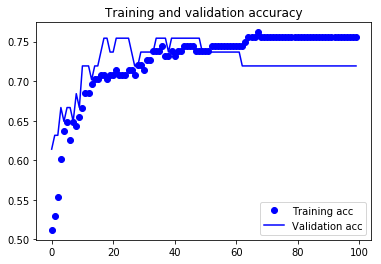

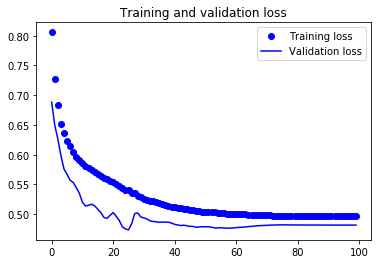

In [487]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

print(epochs)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [488]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("test loss: {}, test accuracy: {}".format(test_loss, test_acc))

57/57 [==============================] - 0s 70us/step
test loss: 0.48182071510114166, test accuracy: 0.719298243522644


In [489]:
y_pred = model.predict(X_test)
print("AUC ROC: ",roc_auc_score(y_test, y_pred))

AUC ROC:  0.773015873015873


In [490]:
y_pred = list(map(lambda i: int(i>=0.5), y_pred))
print("Kappa: ",cohen_kappa_score(y_test, y_pred))

Kappa:  0.24378109452736318


### KMeans

In [66]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

In [67]:
WSSs = []
for i in range(1,15) :
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(X)
    WSSs.append(km.inertia_)
WSSs

[3315.0,
 2972.7888695817974,
 2748.18187155972,
 2544.9420084212106,
 2413.687059384553,
 2278.037996783226,
 2213.3487507256823,
 2123.4282707474663,
 2067.8299633414163,
 1977.777252698108,
 1956.5229777214513,
 1880.0296166971755,
 1815.5096049846275,
 1785.9955747862728]

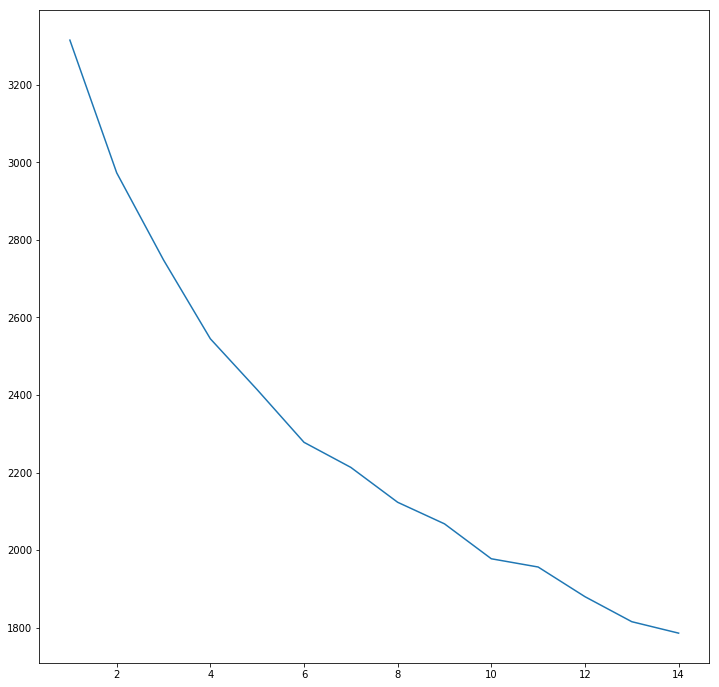

In [68]:
plt.figure(figsize=(12,12))
plt.plot(range(1, 15), WSSs)

K=6

In [69]:
kmeans_ch = KMeans(n_clusters=6, random_state=0, n_init=10)
kmeans_ch.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [70]:
kmeans_ch.labels_

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [71]:
clusters_ch = kmeans_ch.predict(X)
clusters_ch

array([4, 2, 2, 2, 0, 1, 1, 0, 1, 4, 4, 4, 1, 4, 4, 3, 4, 4, 4, 4, 4, 0,
       0, 4, 4, 4, 4, 3, 4, 3, 4, 4, 3, 1, 3, 1, 4, 4, 3, 1, 1, 1, 4, 4,
       2, 1, 1, 1, 4, 1, 1, 1, 4, 3, 3, 4, 4, 1, 4, 1, 0, 4, 4, 4, 3, 3,
       3, 4, 3, 0, 4, 2, 1, 4, 0, 4, 4, 3, 3, 0, 0, 2, 1, 4, 1, 0, 0, 3,
       4, 1, 4, 4, 4, 4, 1, 1, 0, 3, 3, 3, 4, 1, 1, 4, 1, 4, 0, 3, 1, 1,
       1, 0, 3, 2, 4, 4, 0, 1, 5, 3, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       4, 4, 0, 0, 2, 2, 2, 4, 4, 4, 2, 2, 2, 3, 0, 4, 1, 3, 3, 3, 3, 3,
       4, 3, 1, 0, 0, 0, 1, 1, 0, 2, 2, 0, 3, 0, 1, 0, 0, 0, 0, 1, 3, 2,
       4, 4, 1, 2, 4, 3, 2, 3, 4, 4, 4, 1, 2, 3, 3, 0, 2, 2, 2, 1, 0, 1,
       4, 2, 0, 4, 3, 3, 2, 3, 5, 5, 2, 3, 3, 2, 0, 3, 0, 2, 4, 2, 1, 2,
       1, 3, 4, 4, 4, 1, 0, 1, 2, 2, 3, 0, 4, 2, 2, 4, 0, 2, 2, 2, 1, 3,
       4, 4, 2, 2, 2, 4, 0, 0, 2, 2, 2, 2, 2])

In [72]:
X.loc[:,'Cluster'] = clusters_ch
X.loc[:,'chosen'] = list(y)

In [73]:
X

mfccfiles_1  mfccfiles_2  mfccfiles_3  mfccfiles_4  mfccfiles_5  \
0      -0.339415     0.847773     0.497198    -0.389310     1.225458   
1       0.587658    -1.195426     0.636375     0.199876     0.765321   
2       1.465595    -2.307943     0.354567    -0.058273    -1.298853   
3       0.749403    -1.690498    -0.125200    -1.016135     0.825845   
4      -0.280577     0.393332     0.744917     2.411400    -0.777421   
5      -0.158690     0.404891    -0.147920    -0.299241    -0.786974   
6       1.646777     0.772744    -1.425228    -0.562610    -1.556076   
7       1.124970     0.506236     0.738993     1.984485    -0.928706   
8       0.920059     1.438862    -2.048354     1.503567    -2.801303   
9       0.182544     0.310622     0.067722     0.870138     0.168366   
10      0.168663     0.389450     0.034360     1.213392     0.248437   
11      0.153010    -0.118336     0.639531     1.504522     0.937909   
12      0.132578     0.261966    -2.871493    -3.398160    -0.256458   
13      1.094629     0.885150    -1.130672    -0.083270     0.672482   
14      0.771472     0.364448    -0.454696     0.434253     0.912699   
15      0.677561     0.166795     0.746471     0.075191     0.867924   
16     -0.032353     1.227345    -0.188580     0.927210     0.016663   
17      0.459031     1.258961    -0.329412     1.391790    -0.208888   
18     -0.359172     0.051214    -0.603962     0.778896     1.630471   
19      0.209859    -0.615399    -0.676895     0.735655     0.805509   
20      0.127381    -0.265099    -0.258801    -0.127568     0.649447   
21      1.222717     0.409860     1.311826     0.703873     0.322062   
22      1.173352     0.490500     0.742825    -0.028159    -0.272396   
23      1.069960     0.858822    -0.795544     0.076688     0.851875   
24      0.581377    -0.804045     0.399887     1.535671     0.245878   
25      0.161110     0.025075     0.716318     1.532230     0.889883   
26      0.431443     0.442713     0.259120     0.045533     0.102675   
27      0.344525    -1.140315    -0.725453    -0.547965     0.449924   
28     -0.041565     0.671274     0.195143     0.247294     0.531620   
29      0.417845    -1.134173    -0.760709    -0.605264     0.077464   
..           ...          ...          ...          ...          ...   
225     1.532114    -1.060006    -0.434145    -0.999435    -1.259462   
226    -0.942320     1.172080     0.506725    -0.230675    -0.104635   
227     1.421974     0.631029    -0.563813    -0.694595    -0.673270   
228    -1.473385    -0.806223     1.849423    -1.252541     0.941013   
229    -1.135926    -0.772372     1.164844    -1.022517     0.630202   
230    -1.085049     0.879566     0.442593     0.128917     0.393498   
231    -0.352258     0.556982     0.530520     0.443818     0.300921   
232    -1.190363     0.797356     0.758472     0.587917     0.890540   
233    -0.651003    -0.586618     1.326854    -0.451354     0.507113   
234    -1.459511    -0.516281     1.631699    -1.141842     0.584621   
235    -0.726984     0.702447     0.798069    -0.320660     0.530902   
236    -0.300986    -0.404923     0.715406     0.245380    -0.427936   
237    -0.736244     0.088611     0.910051     0.437100     0.258256   
238     0.610473    -2.664315     1.303652    -2.022376     1.500032   
239    -2.045424    -2.954642     0.302601    -0.868092    -1.038134   
240     0.329793    -1.367570    -1.454329    -0.207924    -0.723609   
241    -1.919591     1.382172    -0.134161     0.837967    -0.687780   
242    -2.087669     1.400006    -0.494964     0.451717    -0.759188   
243    -2.131652     0.439305    -0.612226     0.854126    -0.494550   
244    -1.611989    -0.756403    -0.410917     1.075909     0.297336   
245    -0.142010     0.000190    -0.063461    -0.506353    -0.386942   
246    -1.263975    -1.168117    -1.396090    -0.312016     1.862268   
247    -0.507700     0.899825     1.510153     1.083642     2.081451   
248    -0.159768     0.518093     2.197018   

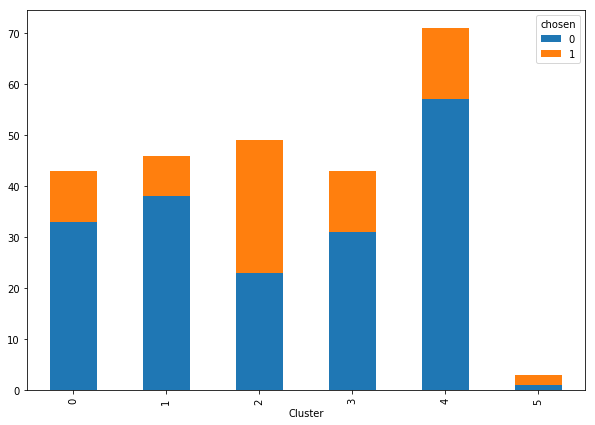

In [74]:
stacked = X.groupby(['chosen','Cluster']).size().reset_index()
pivot_df = stacked.pivot(index='Cluster', columns='chosen', values=0)
pivot_df.loc[:,[0,1]].plot.bar(stacked=True, figsize=(10,7))